# Imports

In [1]:
#for reading files
import glob
import tifffile

#math computation and data organization
import numpy as np
import math
import scipy
from scipy.ndimage import binary_erosion, binary_fill_holes
from scipy import optimize
from scipy.optimize import curve_fit
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

#for saving data
import csv
import h5py

# #custom analysis packages
# import aster_packages as ap #### commented out 20241114 since lucida fonts are not installed...

# Thing to enable lovely parallelization
import concurrent.futures

# Enable repeat from itertools for parallel
import itertools

#time elements for testing runtimes and using todays date
import time
from datetime import datetime

#read strings?
import ast

/home/aduarte/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Functions

Read ome files

In [2]:
def parse_ome(file, channel_list=['405', '480']):
    """
    Extracts image arrays from an ome.tif file.
    
    Parameters:
    file (string): Data file path.
    channel_list (list of strings): Names of fluorescent channels taken in this dataset
    
    Returns:
    (list): List of images (as 3D numpy.ndarrays) for each fluorescent channel with shape (# images, m, n).
    """
    
    images = []
    # Open and read the OME-TIFF file
    with tifffile.TiffFile(file) as tif:

        for i, page in enumerate(tif.pages):
            image_data = page.asarray()
            images.append(image_data)

        # Access the OME metadata if needed
        ome_metadata = tif.ome_metadata
        
    #how the pages are stored in ome
    ch1 = images[0::2] #0 for first channel : : 2 for 2 total channels
    ch2 = images[1::2] #1 for first channel : : 2 for 2 total channels
    
    return [np.array(ch1), np.array(ch2)]

read images from filed names

In [3]:
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list = list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))

    return np.array(im_list)

read in a dark image

In [4]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

subtract dark images from image arrays

In [5]:
def backSubtract(arrs, dark_avg):
    """
    Subtracts camera dark noise from images
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    dark_avg (numpy.ndarray): 2D array image taken with the camera shutter closed of shape (m, n)
    
    Returns:
    (list): list of 3D numpy.ndarray's with dark camera noise subtracted.
    """
    return [arr-dark_avg for arr in arrs] # save processed images

Normalization scheme

In [6]:
def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted


def norm_unev(arr):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arr (np.array): Dark image subtracted image array.
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (np.array): image array after the evening process.
    norm_mat (np.array): array to use to normalize uneven illumination.
    """
    #norm_mats = []
    arrs_ev = []
    
    #compute the bivariate filter
    biv_filt = np.zeros_like(arr[0]) 
    biv_filt = evaluateBivPoly(arr[0, :, :])
    #norm_mats.append(norm_mat)
    #print("time after polynomial fitting", time.time());
    #scale the normalization matrix such that the average value after multiplication is the same as the bs image

    scalar = np.mean(arr[0])/np.mean(arr[0]/biv_filt)

    # Normalisation
    norm_mat = scalar/biv_filt
    # print("shape of norm mat", norm_mat.shape)
    # print("shape of arr", arr.shape)
    # print("time after normalising matrix", time.time());

    arrs_ev = np.zeros_like(arr)
    arrs_ev=arr*norm_mat; 
    #print("time after multiplying arr with norm_mat", time.time());
        
    return arrs_ev

Identify experimental params from file names and read in images

In [7]:
def parseIms(directory):
    """
    Given a directory path, read in images and parse experimental parameters form the file name
    """
    
    fname = directory.split('/')[-1]

    #define the interval between images
    if fname.split('s')[0].isdigit():
        interval = float(fname.split('s')[0]) #interval of frame acquisitions in seconds
    else:
        interval = float(fname.split('ms')[0])/1000 #interval of frame acquisitions in seconds

    atp = float(fname.split('uMATP')[0].split('_')[-1])
    expo405 = float(fname.split('405exp')[1].split('ms')[0])
    expo480 = float(fname.split('480exp')[1].split('ms')[0])
    rep = int(fname.split('_MMStack')[0].split('_')[-1])
    pos = fname.split('Pos')[-1].split('.ome')[0]

    params = {'atp': atp,
              'expo405': expo405,
              'expo480': expo480,
              'rep': rep,
              'pos': pos,
              'interval': interval,
             }

    ims = parse_ome(directory)
    ims405 = ims[0]
    ims480 = ims[1]
    times = np.arange(len(ims405))*interval #seconds

    return params, ims405, ims480, times

process images and returned averaged intensity values at each timepoint

In [8]:
def photobleachCurves(gname, darkPath, cropAcrossTimes = np.s_[:, 300:900, 700:1300], return_flag=False):
    params, ims405, ims480, times = parseIms(gname)
    #params['cropAcrossTimes'] = cropAcrossTimes
    
    dark_avg = grab_dark_avg(darkPath)
    
    ims405bs = backSubtract(ims405, dark_avg)
    ims405even = norm_unev(np.array(ims405bs)[cropAcrossTimes])
    ims405avg = np.mean(ims405even, axis=(1,2))
    
    ims480bs = backSubtract(ims480, dark_avg)
    ims480even = norm_unev(np.array(ims480bs)[cropAcrossTimes])
    ims480avg = np.mean(ims480even, axis=(1,2))

    # mkdir should not overwrite if already exists
    desiredSavePathName=gname.split('data')[0]+'analyzed_data'+gname.split('data')[1].split('.ome')[0]
    #print(desiredSavePathName)
    os.system("mkdir -p "+desiredSavePathName)

    #save name with timestamp
    now = datetime.now()
    save_name = now.strftime("%Y%m%d_%H%M%S")
    
    # permits saving into the new directory we just created
    localNewDirName=desiredSavePathName.split('/')[-1]+'_'
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'params.h5', 'w') as h5file: #h5py.File(desiredSavePathName+save_name+'ATP.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'params', data=str(params))
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'timesSeconds.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'timesSeconds', data=times.astype(np.float16))
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'ims405avg.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'ims405avg', data=ims405avg)
    with h5py.File(desiredSavePathName+'/'+localNewDirName+save_name+'ims480avg.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'ims480avg', data=ims405avg)
    
    if return_flag:
        return (params, times, ims405avg, ims480avg)

In [130]:
tol=1e-7 #if you want to set a precision to the solver

def singExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1], where w1 is the weight of the exponential, 
        tau1 is the decay constant of the exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]

    return w1*np.exp(-times/tau1)
    
def singExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def singExpConst(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, Iinf], where w1 is the weight of the exponential,
        tau1 is the decay constant of the exponential and w2 is the limit of the intensity as you go to infinity
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]

    return w1*np.exp(-times/tau1)+w2
    
def singExpConstFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExpConst(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def doubExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2], where w1(w2) is the weight of the first(second) exponential, 
        tau1(tau2) is the decay constant of the first(second) exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    
def doubExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def doubExp_tau2fit(times, pfit, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2], where w1(w2) is the weight of the first(second) exponential, 
        tau1(tau2) is the decay constant of the first(second) exponential 
    """
    w1 = pfit[0]
    tau1 = pfit[1]
    w2 = pfit[2]
    tau2 = p0[0]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    
def doubExpFit_tau2fit(times, vals, pfit, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp_tau2fit(times, pfit, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def tripExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2, w3, tau3], where w1(w2,w3) is the weight of the first(second, third) exponential, 
        tau1(tau2, tau3) is the decay constant of the first(second, third) exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]
    w3 = p0[4]
    tau3 = p0[5]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)+w3*np.exp(-times/tau3)
    
def tripExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-tripExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

# Run processing
define directory paths

In [10]:
#list all the image directories
srcdir = '../../data/atp_cal/photobleaching/'
directories1 = glob.glob(srcdir+'*Tub*/*.ome*')
directories2 = glob.glob(srcdir+'*/*/*.ome*')
directories = directories1+directories2
print(len(directories))

35


### Make a CSV with all paths

In [305]:
interval_list = []
atp_list = []
A81D_list = []
Tubulin_list = []
expo405_list = []
expo480_list = []
rep_list = []
pos_list = []
date_list = []
key_list = []

for d in directories:
    fname = d.split('/')[-1]
    
    #define the interval between images
    if fname.split('s')[0].isdigit():
        interval = float(fname.split('s')[0]) #interval of frame acquisitions in seconds
    else:
        interval = float(fname.split('ms')[0])/1000 #interval of frame acquisitions in seconds
    interval_list.append(interval)

    atp = float(fname.split('uMATP')[0].split('_')[-1])
    atp_list.append(atp)
    A81D = float(fname.split('uMA81D')[0].split('_')[-1])
    A81D_list.append(A81D)
    Tubulin = float(fname.split('Tubulin')[1].split('uM_')[0])
    Tubulin_list.append(Tubulin)
    expo405 = float(fname.split('405exp')[1].split('ms')[0])
    expo405_list.append(expo405)
    expo480 = float(fname.split('480exp')[1].split('ms')[0])
    expo480_list.append(expo480)
    rep = int(fname.split('_MMStack')[0].split('_')[-1])
    rep_list.append(rep)
    pos = int(fname.split('Pos')[-1].split('.ome')[0])
    pos_list.append(pos)

    if len(d.split('/')[5]) != 10:
        date = '02_06_2025'
    else:
        date = d.split('/')[5]
    date_list.append(date)

    tempkey = (atp, A81D, Tubulin, expo405, expo480, interval, rep, pos, date)
    key_list.append(tempkey)

dirInfo = pd.DataFrame({'directory': directories, 
                        'key' : key_list,
                        'atp (uM)': atp_list, 
                        'A81D (uM)': A81D_list,
                        'Tubulin (uM)' : Tubulin_list,
                        'expo405 (ms)' : expo405_list,
                        'expo480 (ms)' : expo480_list,
                        'interval (s)' : interval_list, 
                        'rep' : rep_list,
                        'pos' : pos_list,
                        'date' : date_list,
                       })

In [352]:
#decide on stop index by hand (cutsoff data before the big microscope drops in intensity)
stop_idx = [71, 71, 70, 200, 200, 28, 28, 74, 73, 73, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 34, 34, 34, 200, 200, 180, 180, 180, 97, 200, 200, 200, ]
dirInfo['stop_idx'] = stop_idx

### Run all the saves

# Read the Data

In [11]:
def read_h5py(path_name, excludes=[]):
    # Glob for directory parsing to get all .h5 files in the specified path
    h5files = glob.glob(path_name + '/*.h5')
    for excl in excludes:
        h5files=[file for file in h5files if excl not in file]
    #print("HDF5 files found:", h5files)
    
    # Dictionary to store arrays from each file
    all_data = {}
    
    for file in h5files:
        file_data = []  # List to hold datasets for the current file

        if 'params' not in file:
            with h5py.File(file, 'r') as h5file:
                def load_data(name, obj):
                    if isinstance(obj, h5py.Dataset):
                        file_data.append(obj[:])  # Append dataset as a NumPy array
                
                # Visit all datasets in the file and load them into file_data
                #print(type(h5file))
                h5file.visititems(load_data)
                
            #slice by 8 since the date has 8 didgits
            field_name = file.split('.h5')[0].split('Pos')[-1][17:] #BRO, 15 is the number of digits in how we save datetime -> 20241114_201131 (formerly we had 8 since we didnt include time)
            # print(file + '\n')
            # print(field_name+ '\n')
            # print(file_data)
                
            # Add this file's data to all_data with the filename as the key
            all_data[field_name] = file_data[0]
        
        # else:
        #     dataset_name=gname.split('data')[0]+'analyzed_data'+gname.split('data')[1].split('.ome')[0]+file.split('Pos')[-1][2:].split('.h5')[0]
        #     print(dataset_name)
        #     with h5py.File(file, "r") as h5file:
        #         params_str = h5file[dataset_name][()].decode("utf-8")  # Read and decode string
        #         params_dict = ast.literal_eval(params_str)      
        #     # Add this file's data to all_data with the filename as the key
        #     all_data['params'] = params_dict
             
    return all_data

In [382]:
#list all the image directories
srcdir_anal = '../../analyzed_data/atp_cal/photobleaching/'
directories1_anal = glob.glob(srcdir_anal+'*Tub*/*.h5*')
directories2_anal = glob.glob(srcdir_anal+'*/*/*.h5*')
directories_anal = directories1_anal+directories2_anal
print(len(directories_anal))

112


In [390]:
pd.read_csv(srcdir_anal+'dirInfo.csv')['key'].iloc[0]

"(500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 2, 1, '02_06_2025')"

In [388]:
dirInfo['key'].iloc[0]

(500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 2, 1, '02_06_2025')

In [52]:
datadir = {}
for d, dname in enumerate(directories):
    dname_anal = dname.split('data')[0]+'analyzed_data'+dname.split('data')[1].split('.ome')[0]
    
    if len(dname_anal.split('/')[5]) != 10:
        date = '02_06_2025'
    else:
        date = dname_anal.split('/')[5]
    #params
    fname = dname_anal.split('/')[-1]

    #define the interval between images
    if fname.split('s')[0].isdigit():
        interval = float(fname.split('s')[0]) #interval of frame acquisitions in seconds
    else:
        interval = float(fname.split('ms')[0])/1000 #interval of frame acquisitions in seconds

    atp = float(fname.split('uMATP')[0].split('_')[-1])
    expo405 = float(fname.split('405exp')[1].split('ms')[0])
    expo480 = float(fname.split('480exp')[1].split('ms')[0])
    rep = int(fname.split('_MMStack')[0].split('_')[-1])
    pos = int(fname.split('Pos')[-1])
    A81D = float(fname.split('uMA81D')[0].split('_')[-1])
    Tubulin = float(fname.split('Tubulin')[1].split('uM_')[0])
    
    dnamedir = read_h5py(dname_anal)
    datadir[atp, A81D, Tubulin, expo405, expo480, interval, rep, pos, date] = dnamedir

In [59]:
regExpTime_idx = np.where(np.array(list(datadir.keys()))[:,3].astype(float) == 150)
doubExpTime_idx = np.where(np.array(list(datadir.keys()))[:,3].astype(float) == 300)

In [170]:
list(datadir.keys())

[(500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 2, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 2, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 2, 2, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 3, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 1.0, 2, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 3, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 3, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 1, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 1, 2, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 1, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 5.0, 2, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 5.0, 2, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 5.0, 1, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 2, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 2, 2, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 2, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 2, 0, '

# Look at the data!

(70.0, 120.0)

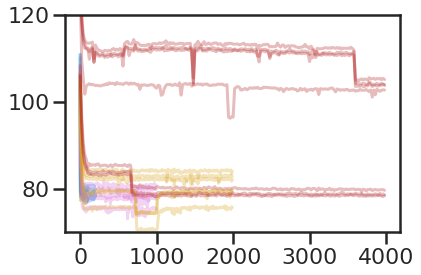

In [16]:
colors = ['olive', 'dodgerblue', 'orchid', 'goldenrod', 'firebrick']
for i, inter in enumerate(np.unique(np.array(list(datadir.keys()))[:,5].astype(float))):
    datasets = [datadir[key] for key in datadir.keys() if key[5]==inter and key[4]==160]
    [plt.plot(dset['timesSeconds'],dset['ims405avg'], color = colors[i], alpha=0.3) for dset in datasets]
plt.ylim(70,120)

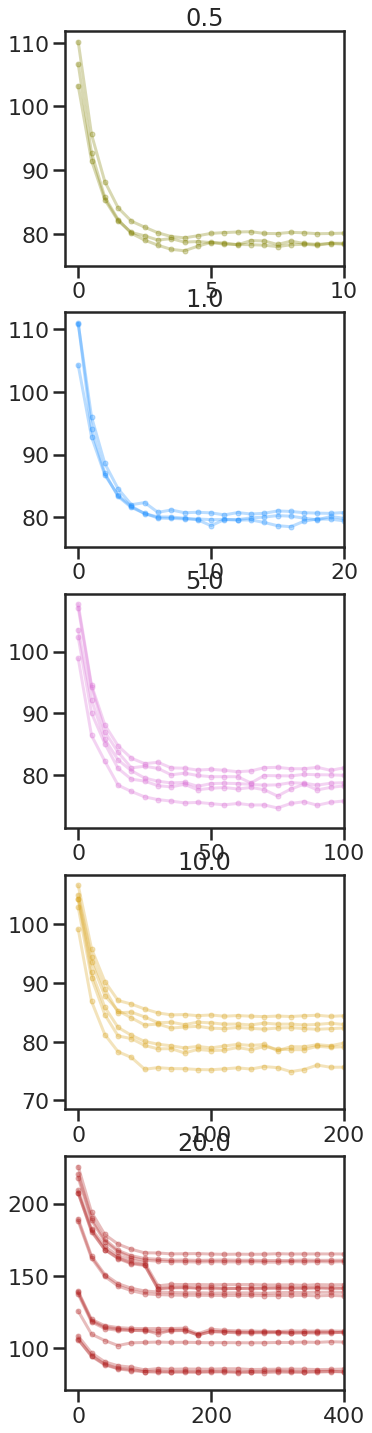

In [17]:
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
fig, ax = plt.subplots(len(intervals), figsize = (5, 25))
for i, inter in enumerate(intervals):
    datasets = [datadir[key] for key in datadir.keys() if key[5]==inter and key[4]==160]
    [ax[i].plot(dset['timesSeconds'],dset['ims405avg'], 'o-', ms=5, color = colors[i], alpha=0.3) for dset in datasets]
    ax[i].set_title(inter)
    ax[i].set_xlim(-1*inter, 20*inter)

In [18]:
list(datadir.keys())

[(500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 2, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 2, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 2, 2, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 3, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 1.0, 2, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 3, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 20.0, 3, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 1, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 1, 2, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 1, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 5.0, 2, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 5.0, 2, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 5.0, 1, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 2, 1, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 2, 2, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 10.0, 2, 0, '02_06_2025'),
 (500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 2, 0, '

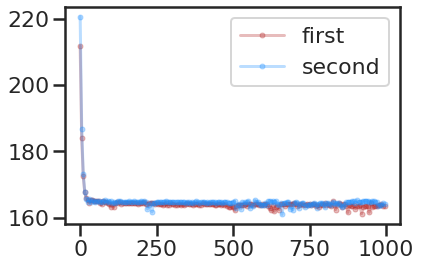

In [19]:
dset=datadir[(500.0, 2.8, 1.3, 300.0, 320.0, 5.0, 1, 0, '02_06_2025')]
plt.plot(dset['timesSeconds'],dset['ims405avg'], 'o-', ms=5, color = 'firebrick', alpha=0.3, label='first') 

dset=datadir[(500.0, 2.8, 1.3, 300.0, 320.0, 5.0, 2, 0, '02_06_2025')]
plt.plot(dset['timesSeconds'],dset['ims405avg'], 'o-', ms=5, color = 'dodgerblue', alpha=0.3, label='second') 

plt.legend()

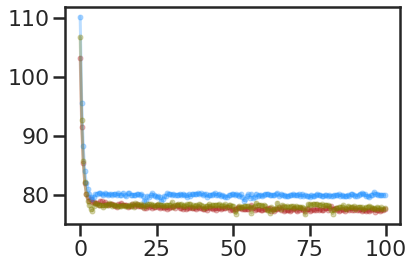

In [20]:
dset=datadir[(500.0, 2.8, 1.3, 150, 160, 0.5, 1, 0, '02_06_2025')]
plt.plot(dset['timesSeconds'],dset['ims405avg'], 'o-', ms=5, color = 'firebrick', alpha=0.3, label='first') 

dset=datadir[(500.0, 2.8, 1.3, 150, 160, 0.5, 2, 0, '02_06_2025')]
plt.plot(dset['timesSeconds'],dset['ims405avg'], 'o-', ms=5, color = 'dodgerblue', alpha=0.3, label='first') 

dset=datadir[(500.0, 2.8, 1.3, 150, 160, 0.5, 3, 0, '02_06_2025')]
plt.plot(dset['timesSeconds'],dset['ims405avg'], 'o-', ms=5, color = 'olive', alpha=0.3, label='first') 


In [21]:
len([datadir[key] for key in datadir.keys() if key[5]==0.5])

3

(-5.0, 300.0)

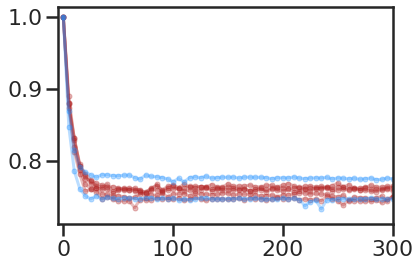

In [22]:
datasets = [datadir[key] for key in datadir.keys() if key[5]==5 and key[4]==160]
[plt.plot(dset['timesSeconds'],dset['ims405avg']/dset['ims405avg'].max(), 'o-', ms=5, color = 'firebrick', alpha=0.3) for dset in datasets]

datasets = [datadir[key] for key in datadir.keys() if key[5]==5 and key[4]==320]
[plt.plot(dset['timesSeconds'],dset['ims405avg']/dset['ims405avg'].max(), 'o-', ms=5, color = 'dodgerblue', alpha=0.3) for dset in datasets]
plt.xlim(-5, 300)

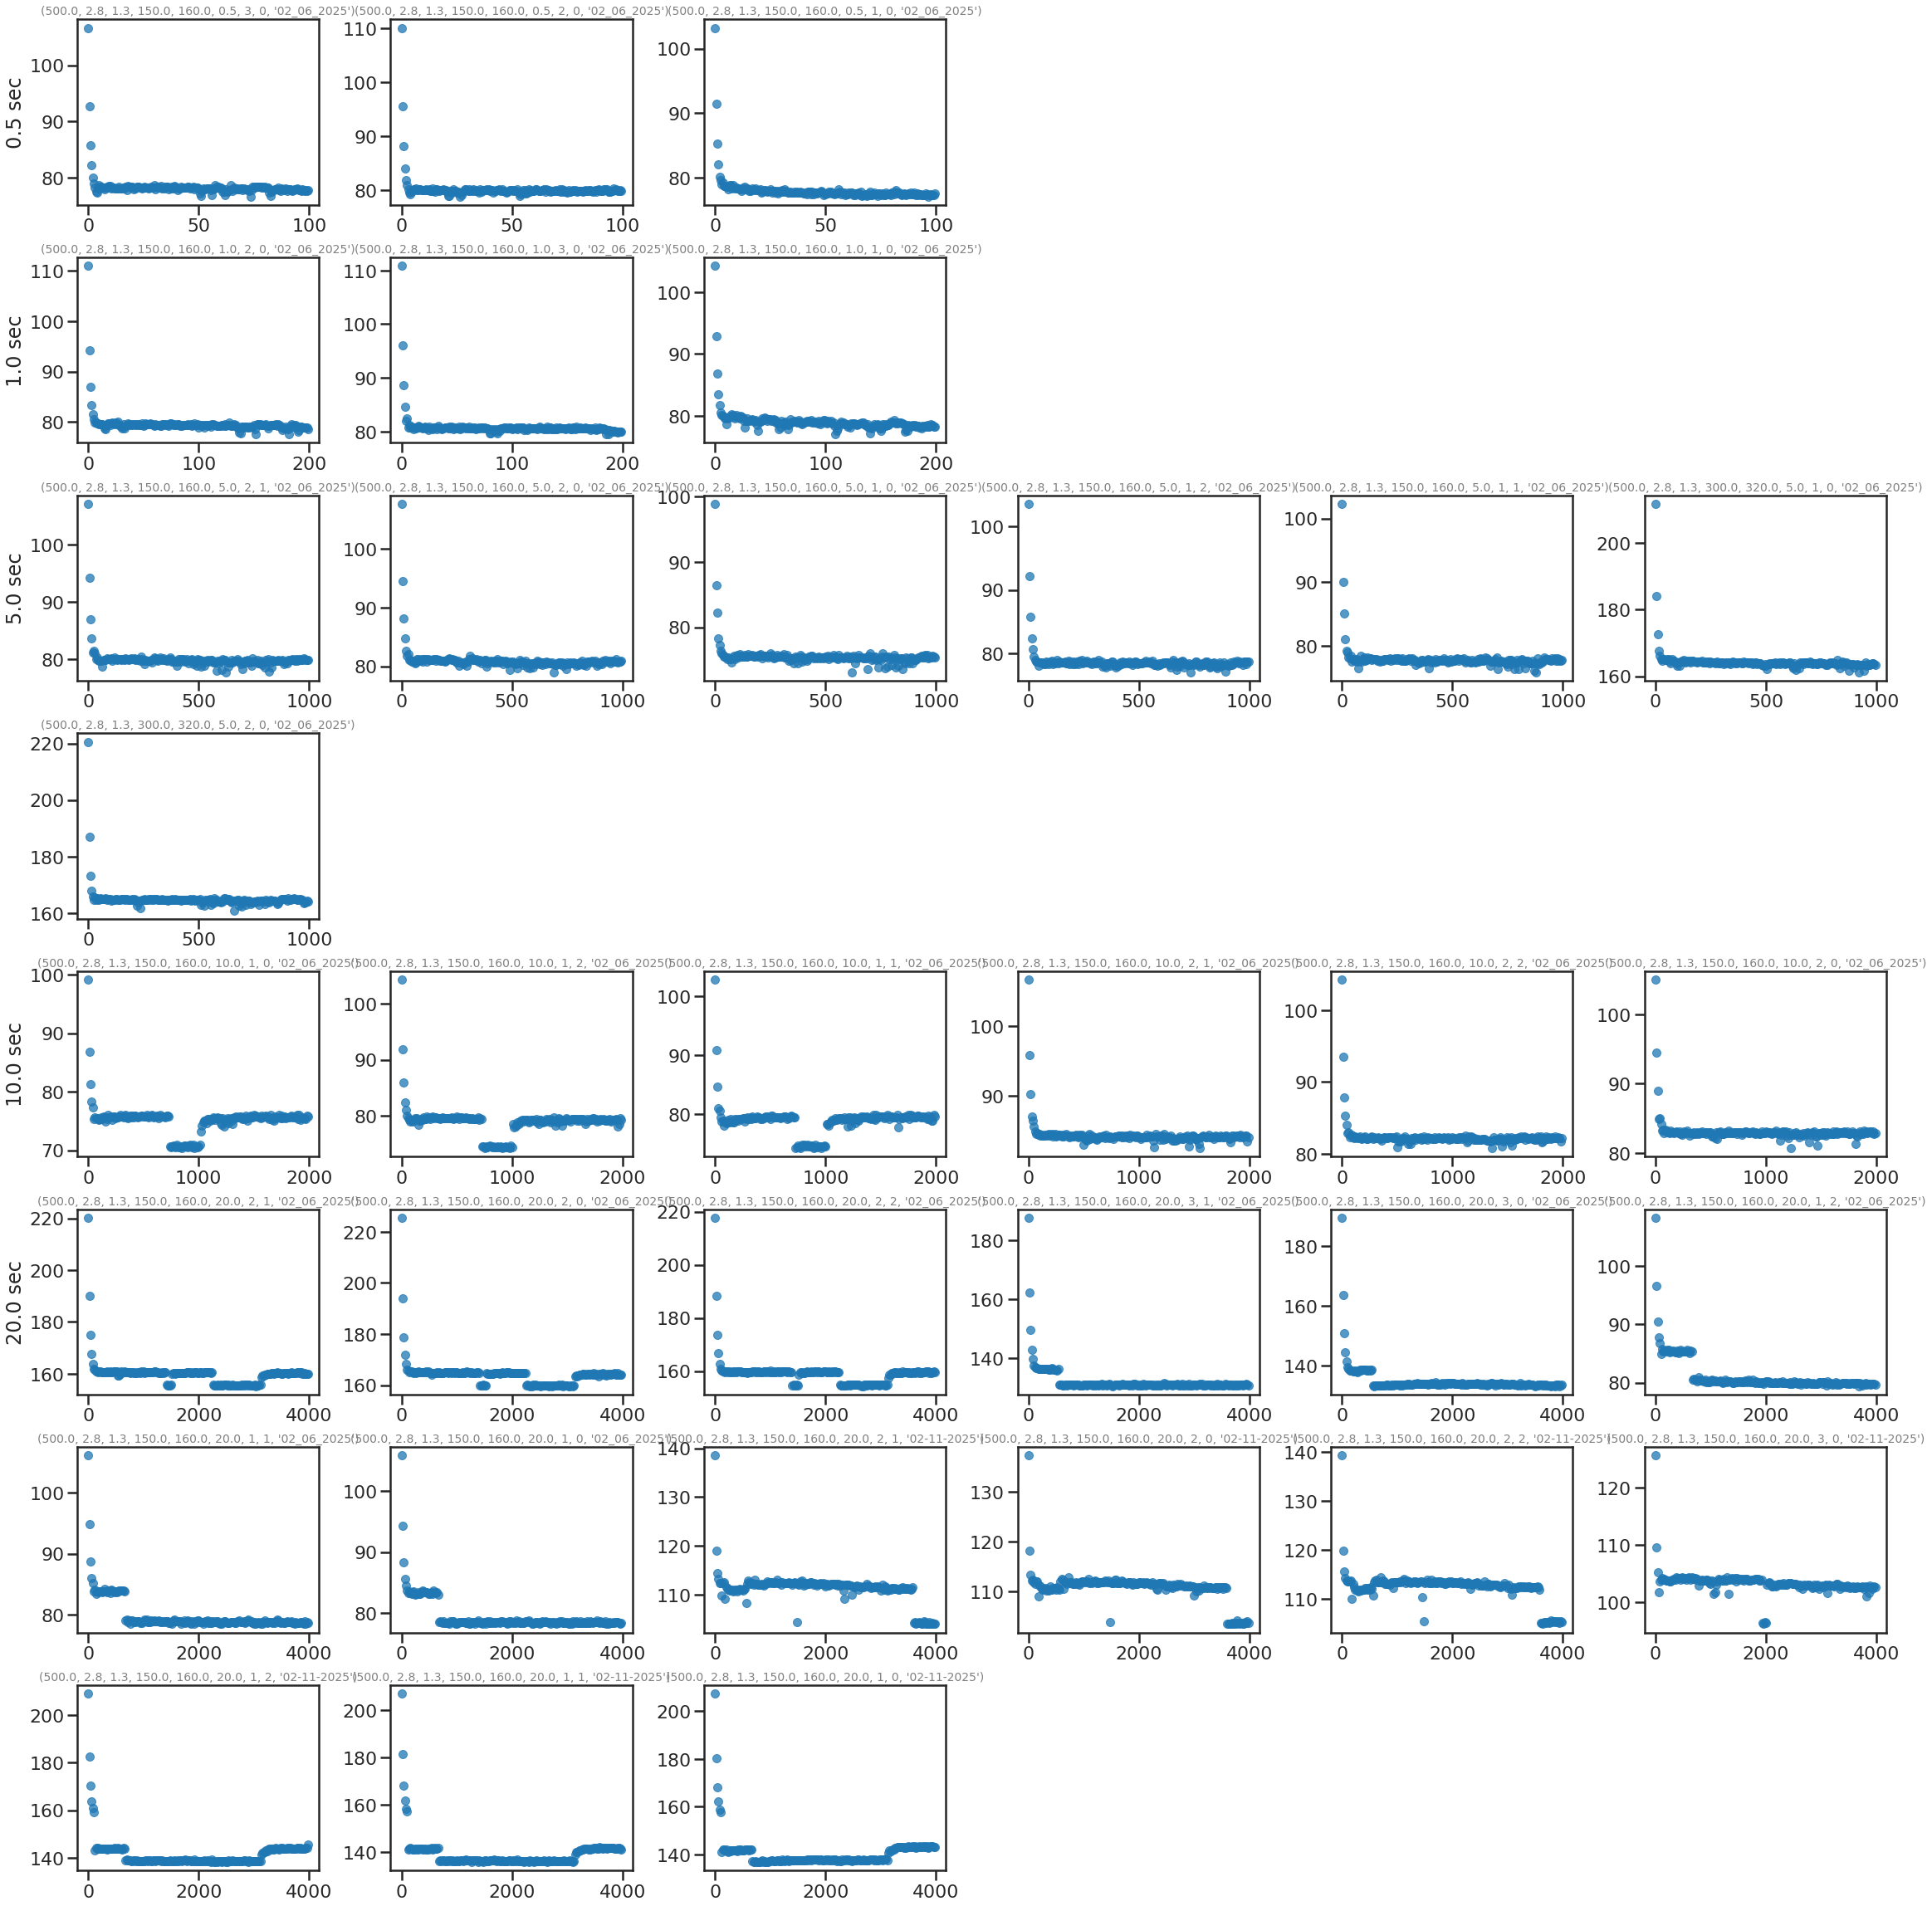

In [23]:
### Intervals
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
#uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(32, 32))
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(intervals)):
    c = intervals[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(np.array(list(datadir.keys()))[:,5].astype(float) == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(str(intervals[ii]) + ' sec')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        jkey = list(datadir.keys())[idxsForThisC[j]]
        axs[rowCounter, colCounter].set_title(jkey, fontsize=14, color='grey')
        # Plot data
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'],
                                    datadir[jkey]['ims405avg'], 'o', ms=10, alpha=0.75)       

        
        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

# Adjust layout and display the plot
plt.tight_layout()

# # plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_Motors_globalTimeCmap.pdf', 
# #             bbox_inches='tight')

### Fit single exp+const

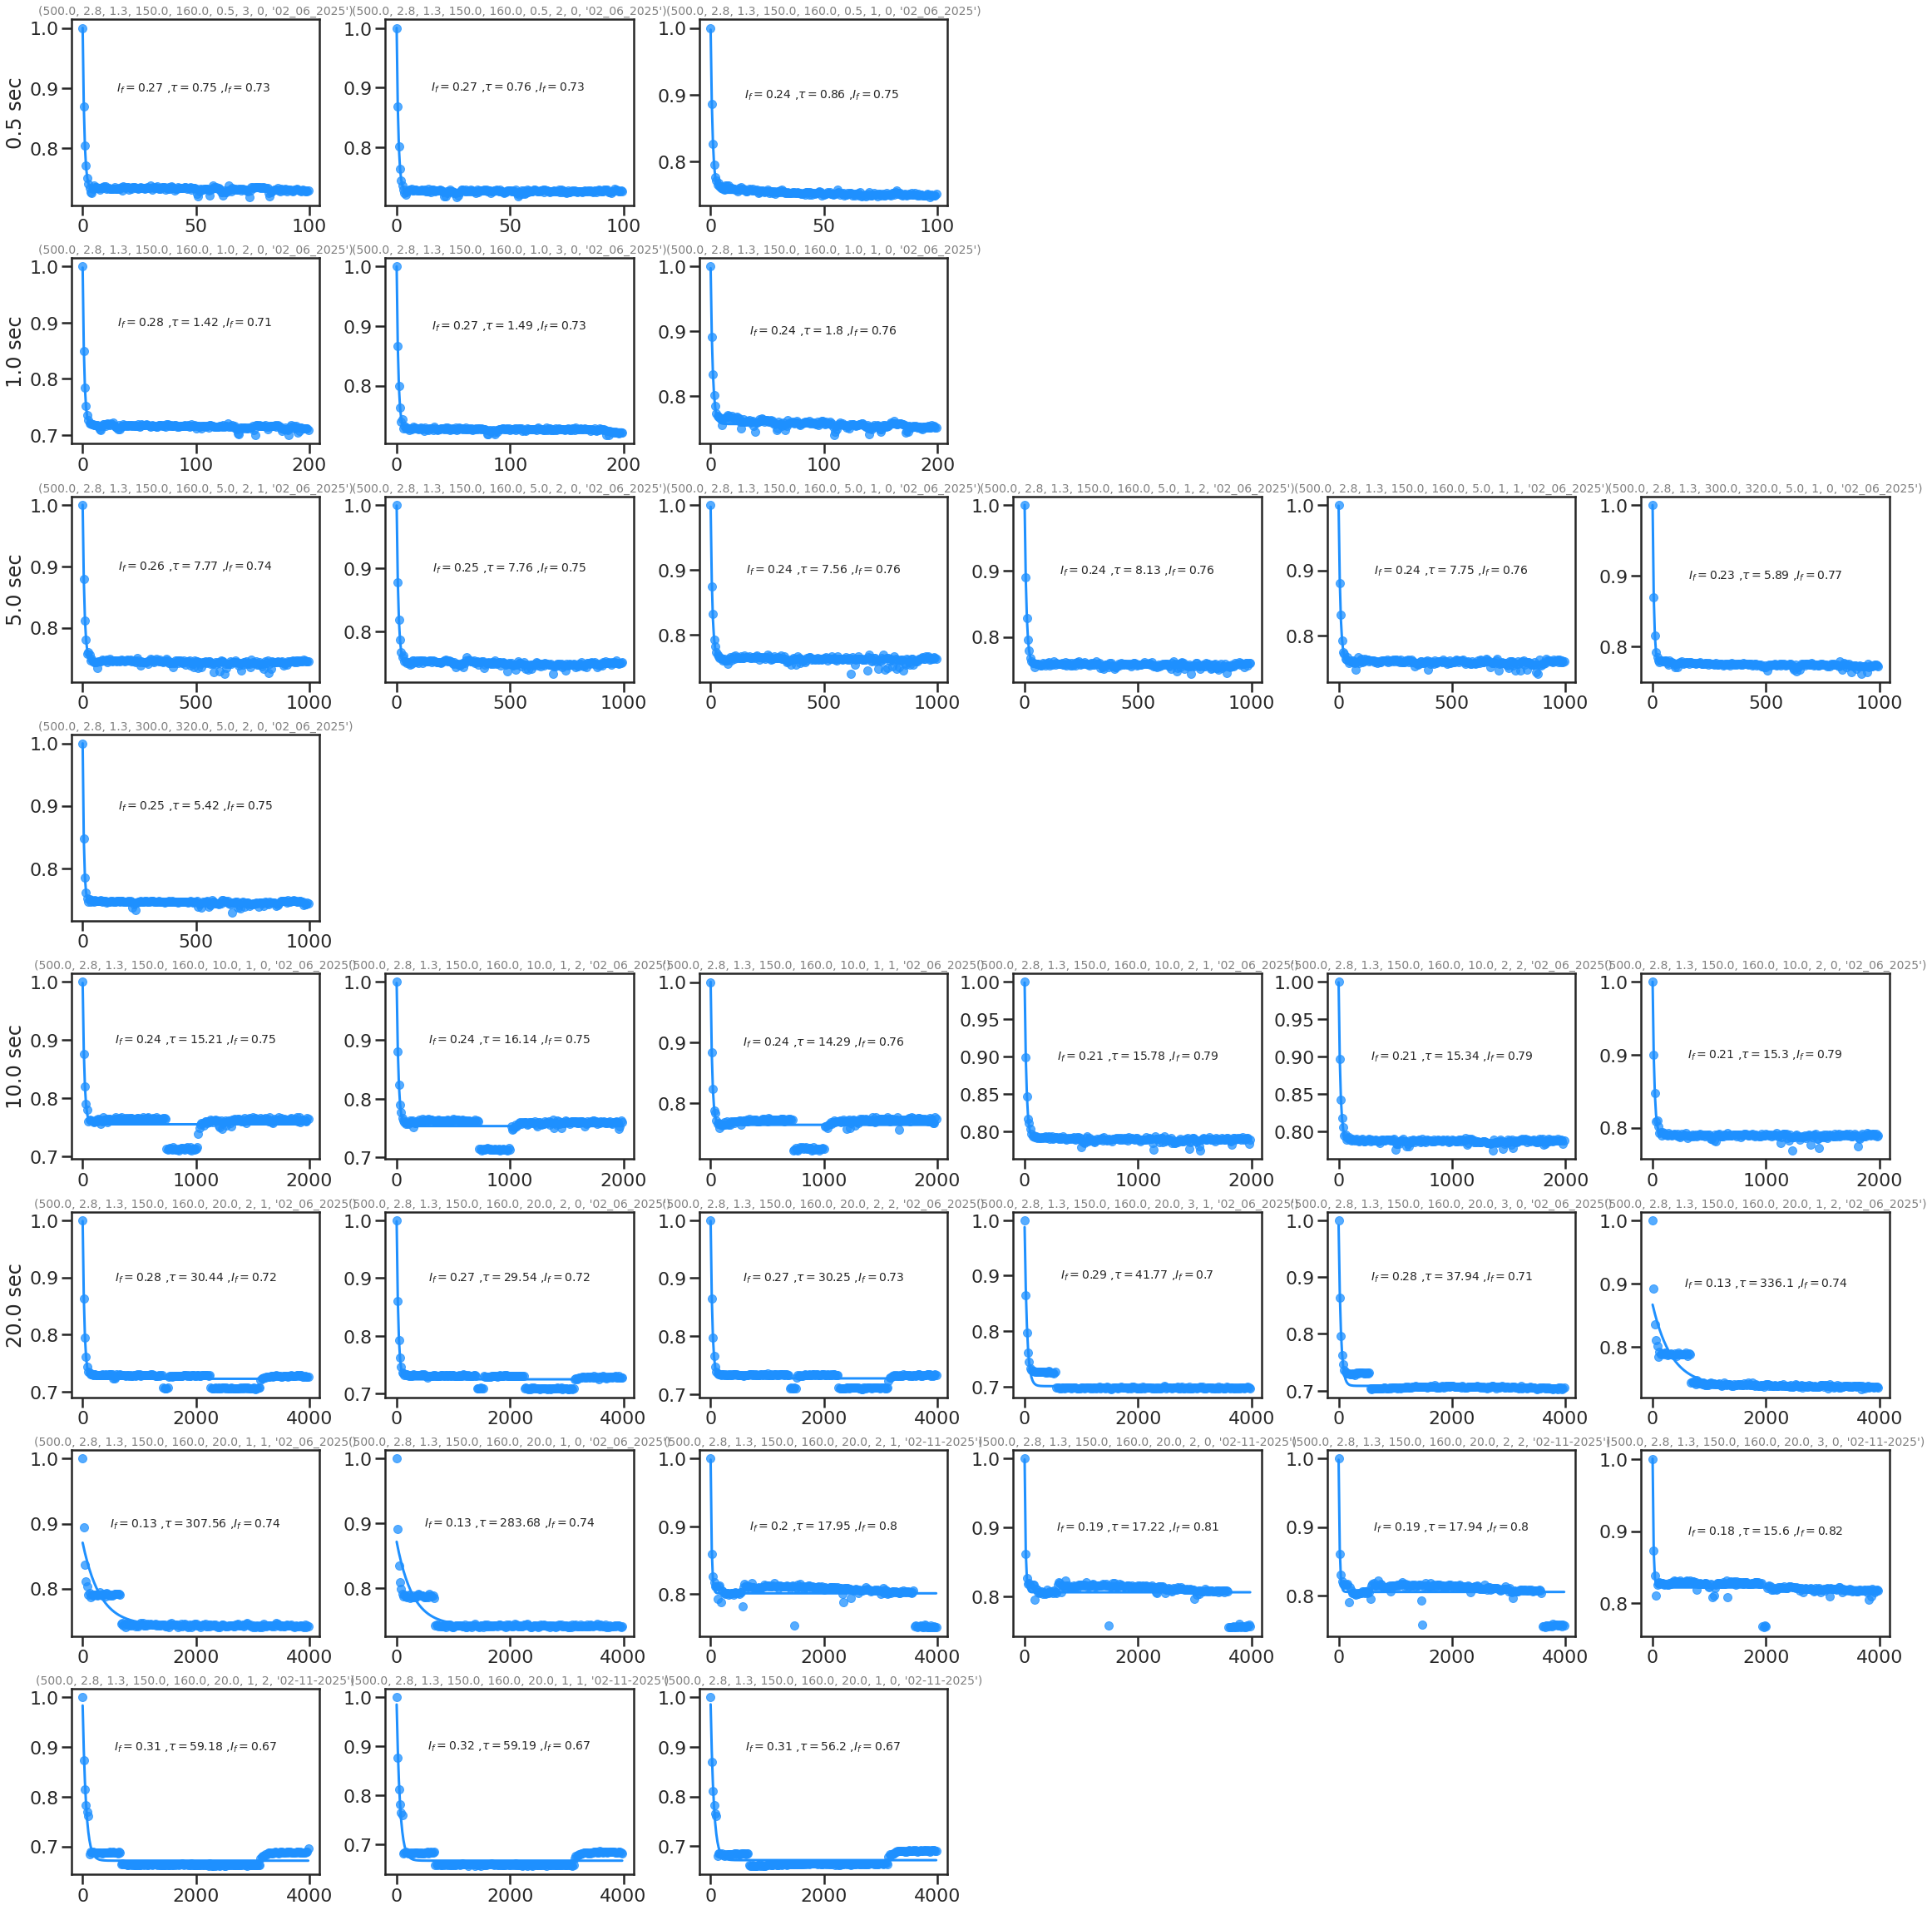

In [374]:
### Intervals
dataFitdir_unsrt = {}
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
#uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(32, 32))
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(intervals)):
    c = intervals[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(np.array(list(datadir.keys()))[:,5].astype(float) == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(str(intervals[ii]) + ' sec')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        jkey = list(datadir.keys())[idxsForThisC[j]]
        axs[rowCounter, colCounter].set_title(jkey, fontsize=14, color='grey')
        # Plot data
        fitSingExpConst= singExpConstFit(datadir[jkey]['timesSeconds'], datadir[jkey]['ims405avg']/datadir[jkey]['ims405avg'].max(), [0.35, c,0.65])
        dataFitdir_unsrt[jkey]=fitSingExpConst.x
        c


        fitString=r'$I_f=$'+str(round(fitSingExpConst.x[0],2))+' ,'+r'$\tau=$'+str(round(fitSingExpConst.x[1],2))+' ,'+r'$I_f=$'+str(round(fitSingExpConst.x[-1],2))
        axs[rowCounter, colCounter].text(datadir[jkey]['timesSeconds'][-1]//2, 0.9, fitString, ha='center', va='center', fontsize=14)
        
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'],
                                    datadir[jkey]['ims405avg']/datadir[jkey]['ims405avg'].max(), 'o', ms=10, alpha=0.75, color='dodgerblue')       

        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

# Adjust layout and display the plot
plt.tight_layout()

#put the keys of the fit dictionary in the same order as datadir
dataFitdir_SEC = {}
for item in list(datadir.keys()):
    dataFitdir_SEC[item] = dataFitdir_unsrt[item]

# # plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_Motors_globalTimeCmap.pdf', 
# #             bbox_inches='tight')

fit to a crop before there are the big spikes down

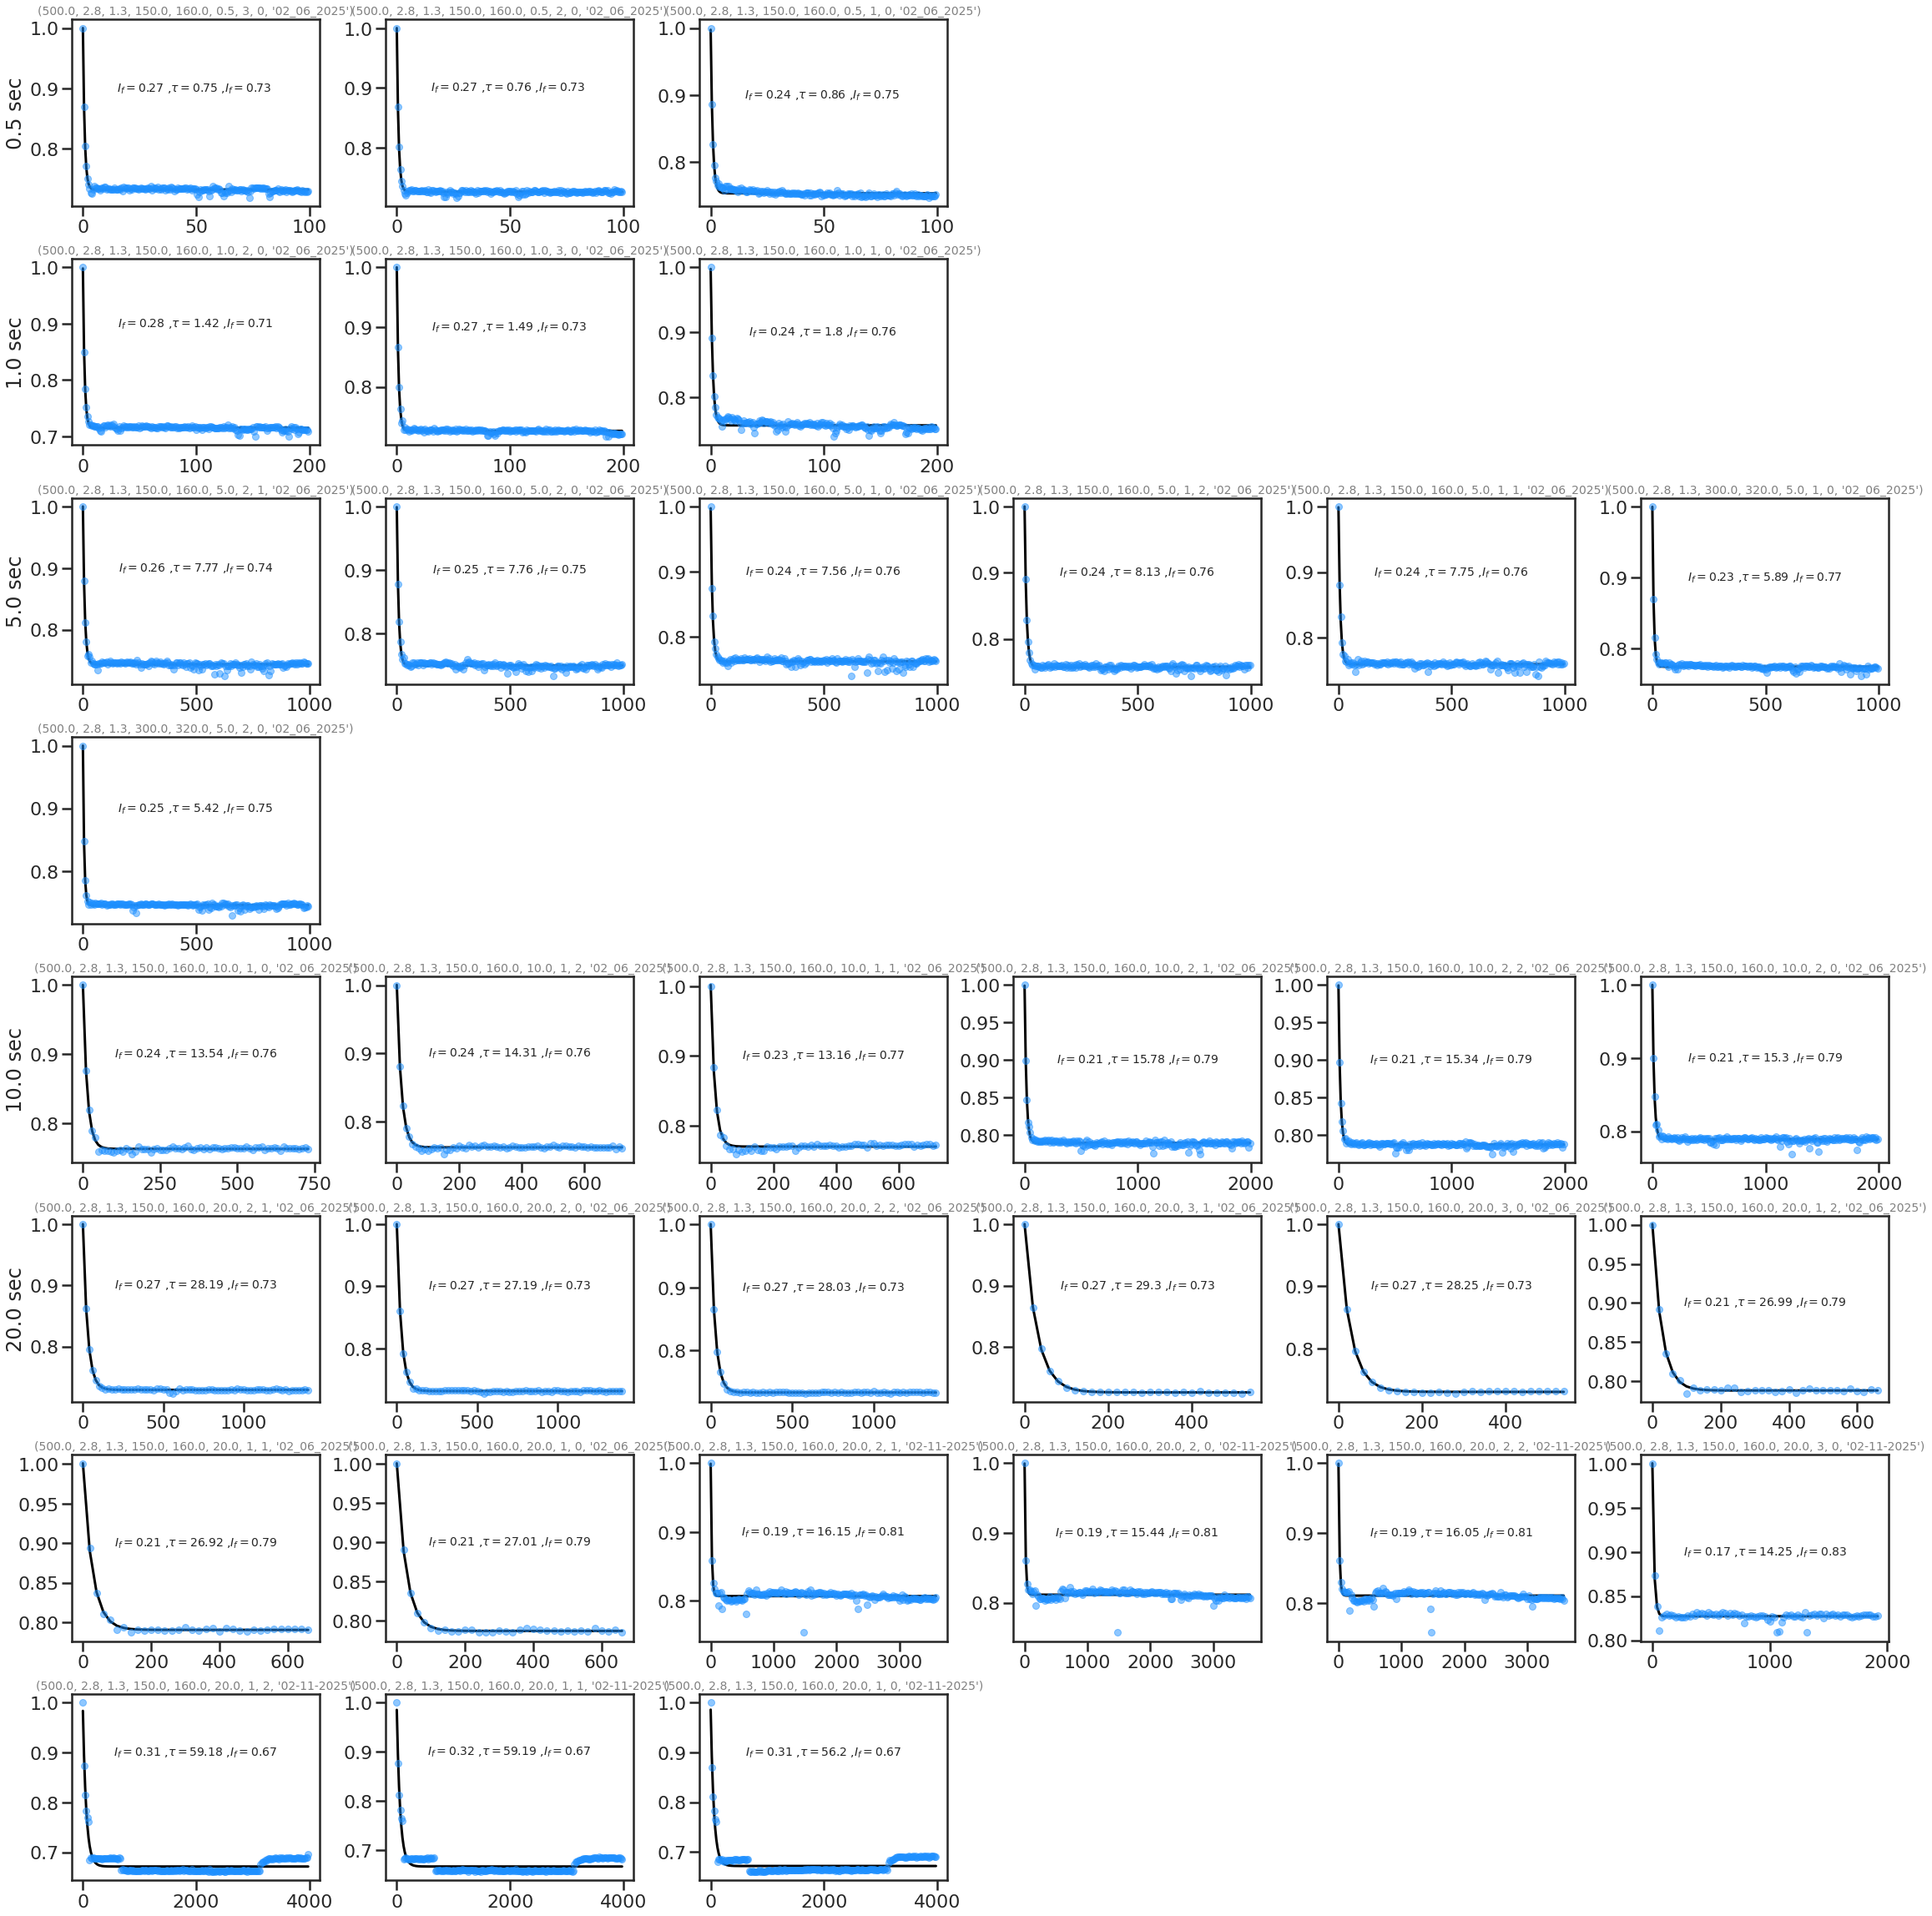

In [375]:
### Intervals
dataFitdir_unsrt = {}
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
#uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(32, 32))
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(intervals)):
    c = intervals[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(np.array(list(datadir.keys()))[:,5].astype(float) == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(str(intervals[ii]) + ' sec')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        jkey = list(datadir.keys())[idxsForThisC[j]]
        dirInfoKeyIdx = np.where(dirInfo['key'] == jkey)[0][0]
        jstop = dirInfo.iloc[dirInfoKeyIdx]['stop_idx']
        
        axs[rowCounter, colCounter].set_title(jkey, fontsize=14, color='grey')
        # Plot data
        fitSingExpConst= singExpConstFit(datadir[jkey]['timesSeconds'][:jstop], datadir[jkey]['ims405avg'][:jstop]/datadir[jkey]['ims405avg'][:jstop].max(), [0.35, c,0.65])
        dataFitdir_unsrt[jkey]=fitSingExpConst.x
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'][:jstop], singExpConst(datadir[jkey]['timesSeconds'][:jstop], fitSingExpConst.x), ls='-', color='k')


        fitString=r'$I_f=$'+str(round(fitSingExpConst.x[0],2))+' ,'+r'$\tau=$'+str(round(fitSingExpConst.x[1],2))+' ,'+r'$I_f=$'+str(round(fitSingExpConst.x[-1],2))
        axs[rowCounter, colCounter].text(datadir[jkey]['timesSeconds'][:jstop][-1]//2, 0.9, fitString, ha='center', va='center', fontsize=14)
        
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'][:jstop],
                                    datadir[jkey]['ims405avg'][:jstop]/datadir[jkey]['ims405avg'][:jstop].max(), 'o', ms=8, alpha=0.5, color='dodgerblue')       

        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

# Adjust layout and display the plot
plt.tight_layout()

#put the keys of the fit dictionary in the same order as datadir
dataFitdir_SECcrop = {}
for item in list(datadir.keys()):
    dataFitdir_SECcrop[item] = dataFitdir_unsrt[item]

# # plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_Motors_globalTimeCmap.pdf', 
# #             bbox_inches='tight')

### Fite double exp

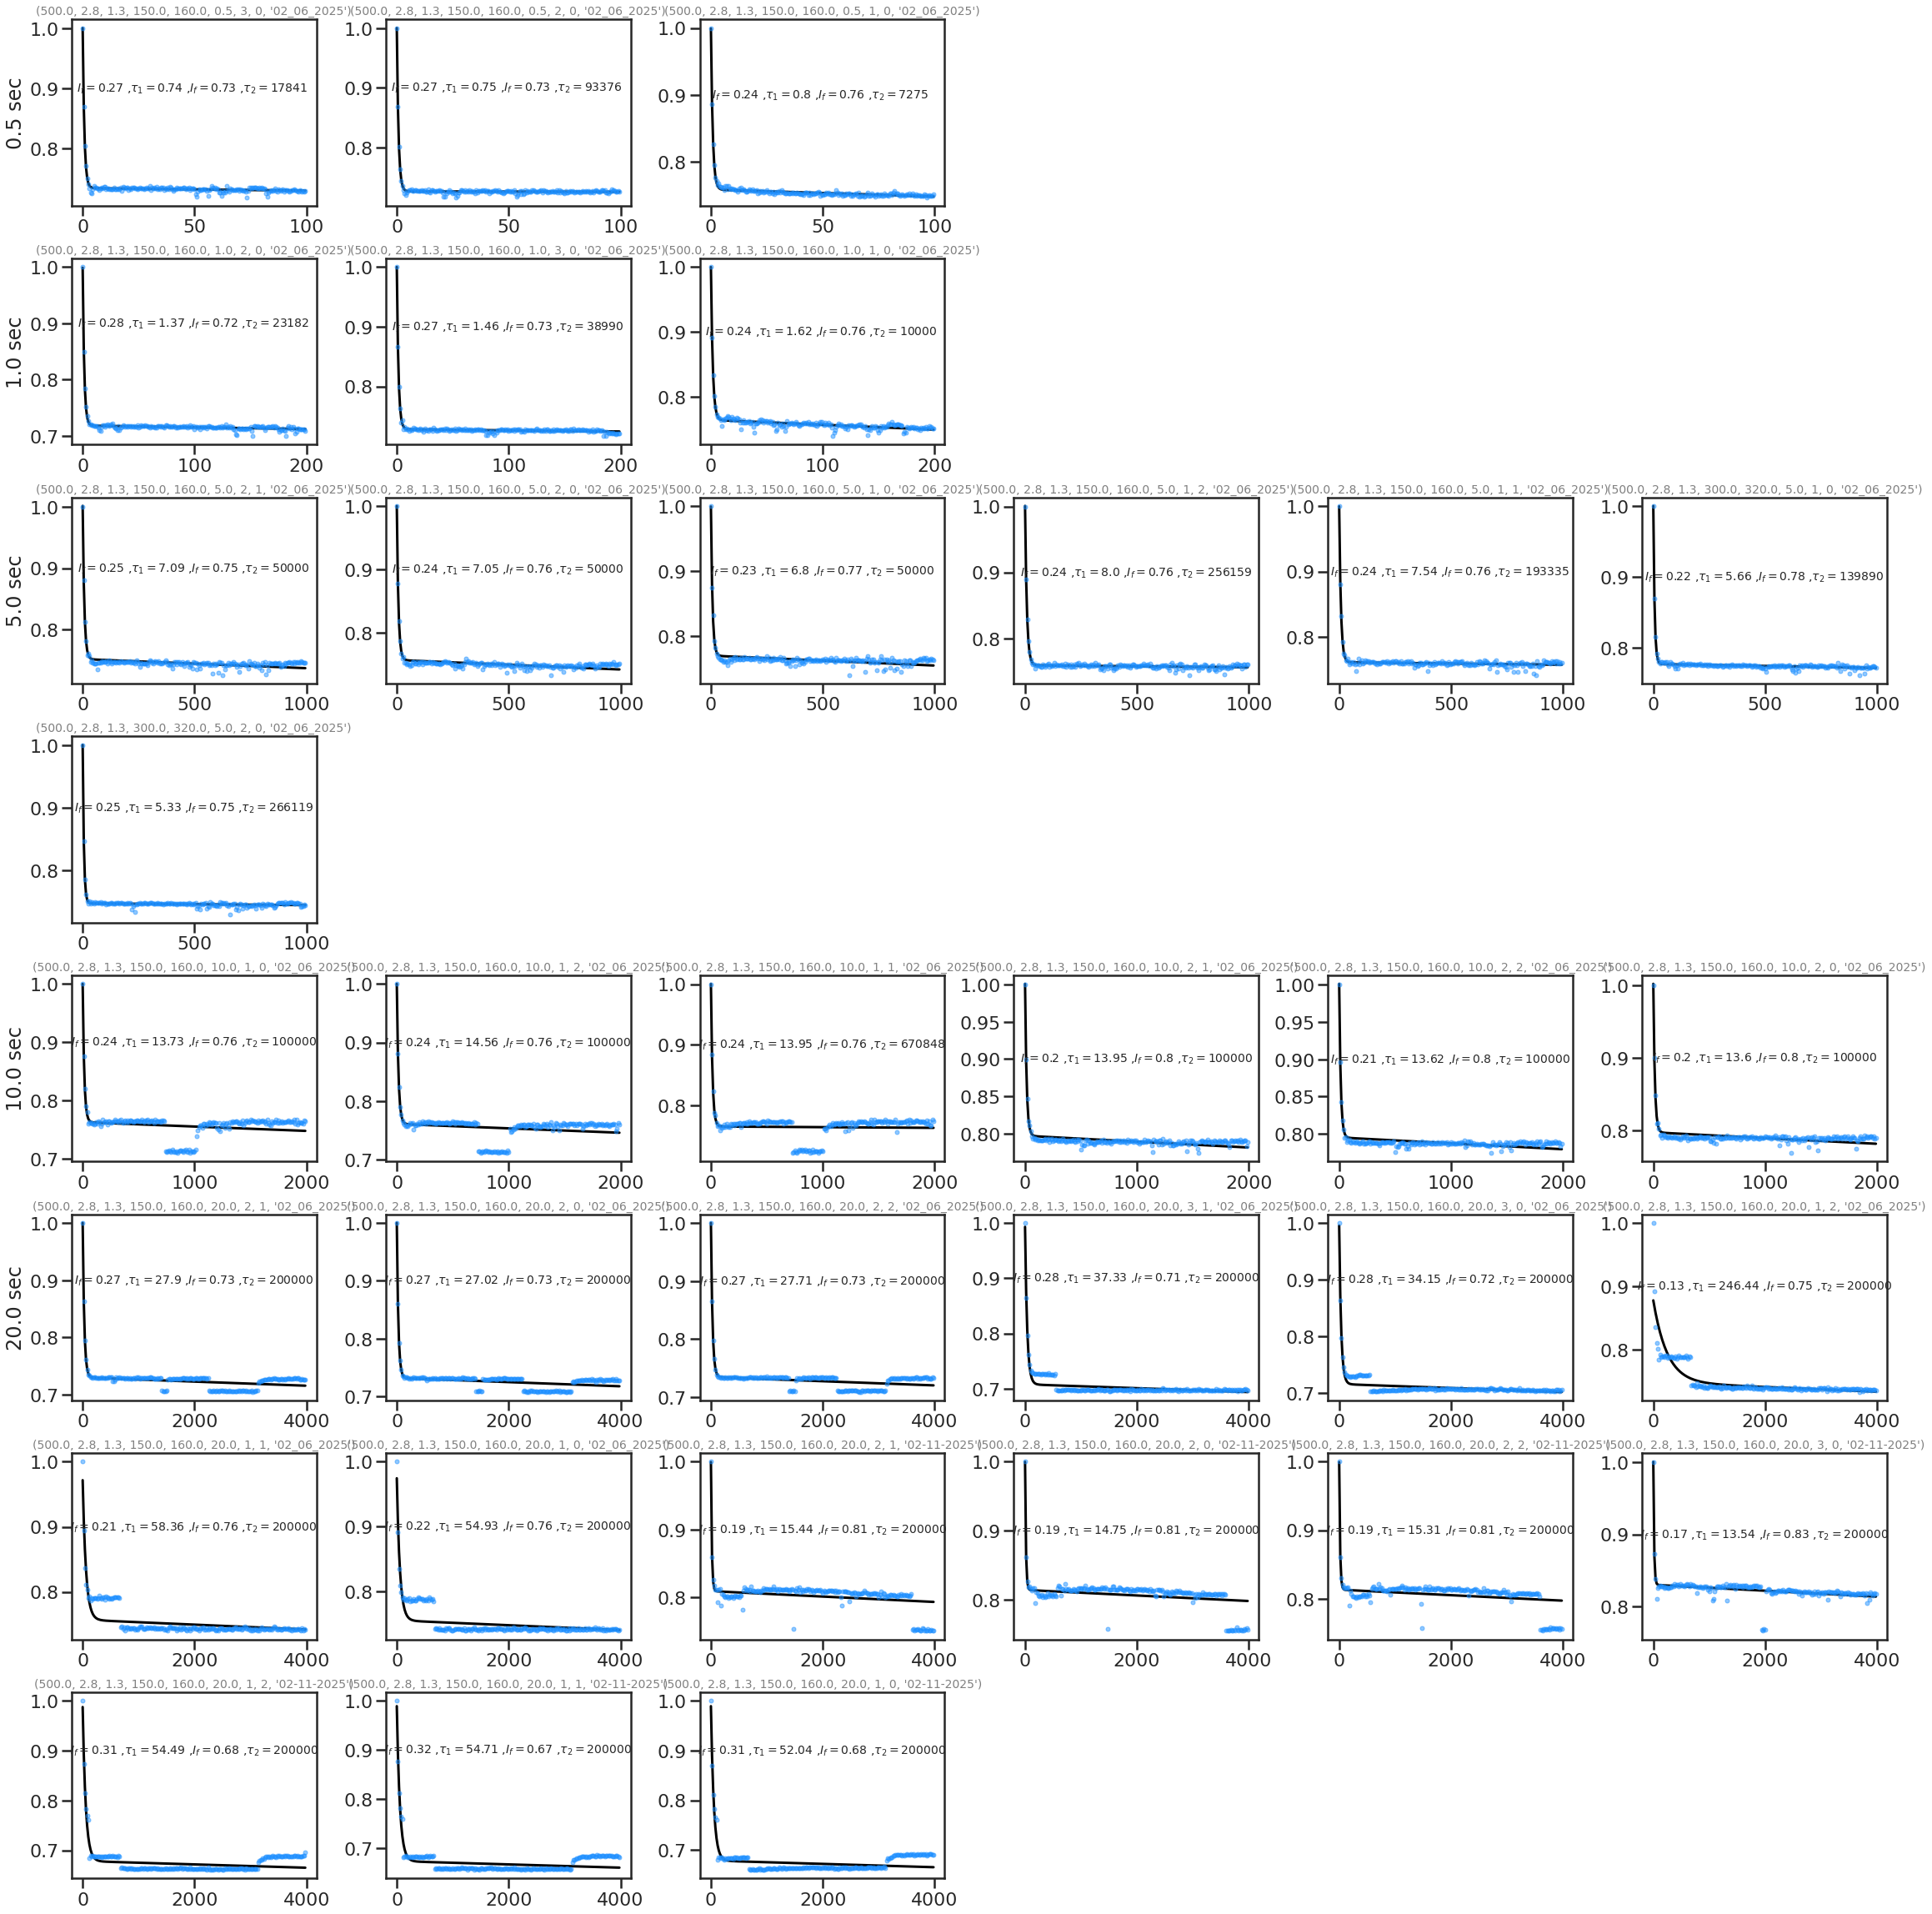

In [376]:
### Intervals
dataFitdir_unsrt = {}
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
#uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(32, 32))
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(intervals)):
    c = intervals[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(np.array(list(datadir.keys()))[:,5].astype(float) == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(str(intervals[ii]) + ' sec')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        jkey = list(datadir.keys())[idxsForThisC[j]]
        axs[rowCounter, colCounter].set_title(jkey, fontsize=14, color='grey')
        # Plot data
        fitDoubExp= doubExpFit(datadir[jkey]['timesSeconds'], datadir[jkey]['ims405avg']/datadir[jkey]['ims405avg'].max(), [0.35, c, 0.65, c*1e4])
        dataFitdir_unsrt[jkey]=fitDoubExp.x
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'], doubExp(datadir[jkey]['timesSeconds'], fitDoubExp.x), ls='-', color='k')


        fitString=r'$I_f=$'+str(round(fitDoubExp.x[0],2))+' ,'+r'$\tau_1=$'+str(round(fitDoubExp.x[1],2))+' ,'+r'$I_f=$'+str(round(fitDoubExp.x[2],2))+' ,'+r'$\tau_2=$'+str(round(fitDoubExp.x[3]))
        axs[rowCounter, colCounter].text(datadir[jkey]['timesSeconds'][-1]//2, 0.9, fitString, ha='center', va='center', fontsize=14)
        
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'],
                                    datadir[jkey]['ims405avg']/datadir[jkey]['ims405avg'].max(), 'o', ms=5, alpha=0.5, color='dodgerblue')       

        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

# Adjust layout and display the plot
plt.tight_layout()

#put the keys of the fit dictionary in the same order as datadir
dataFitdir_DE = {}
for item in list(datadir.keys()):
    dataFitdir_DE[item] = dataFitdir_unsrt[item]

# # plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_Motors_globalTimeCmap.pdf', 
# #             bbox_inches='tight')

fit to a crop before there are the big spikes down

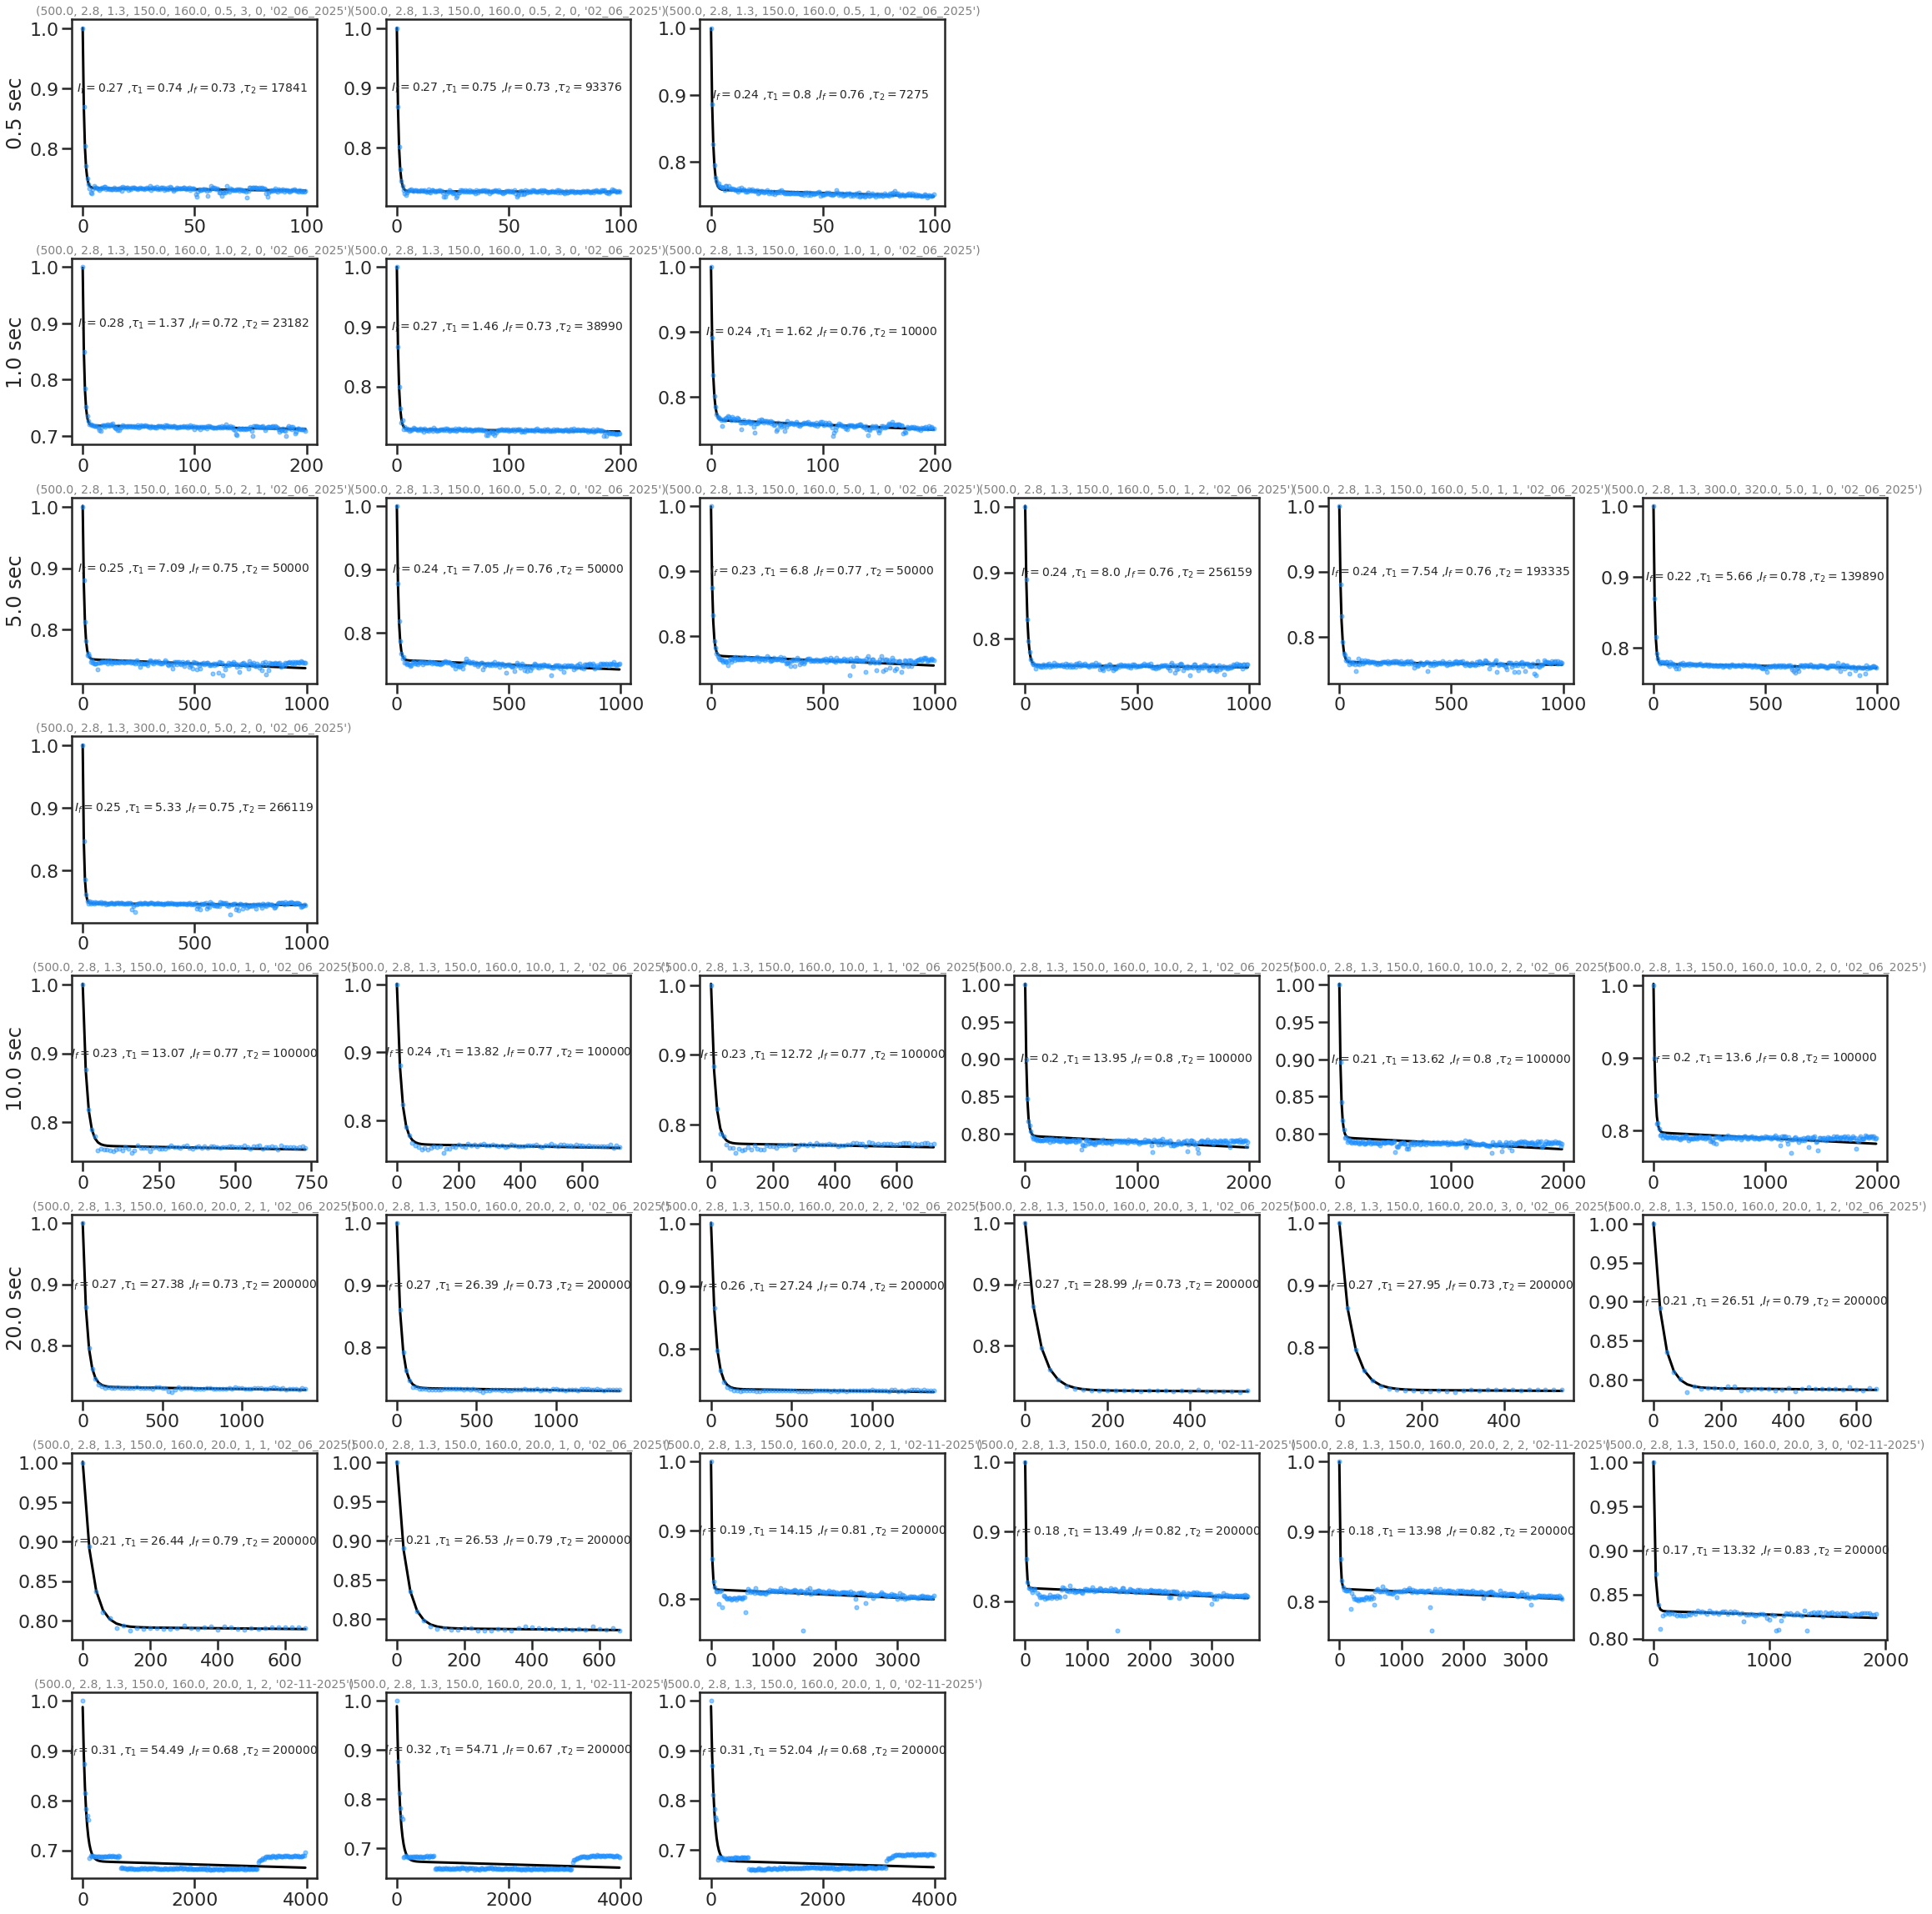

In [377]:
### Intervals
dataFitdir_unsrt = {}
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
#uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(32, 32))
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(intervals)):
    c = intervals[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(np.array(list(datadir.keys()))[:,5].astype(float) == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(str(intervals[ii]) + ' sec')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        jkey = list(datadir.keys())[idxsForThisC[j]]
        dirInfoKeyIdx = np.where(dirInfo['key'] == jkey)[0][0]
        jstop = dirInfo.iloc[dirInfoKeyIdx]['stop_idx']
        
        axs[rowCounter, colCounter].set_title(jkey, fontsize=14, color='grey')
        # Plot data
        fitDoubExp= doubExpFit(datadir[jkey]['timesSeconds'][:jstop], datadir[jkey]['ims405avg'][:jstop]/datadir[jkey]['ims405avg'][:jstop].max(), [0.35, c, 0.65, c*1e4])
        dataFitdir_unsrt[jkey]=fitDoubExp.x
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'][:jstop], doubExp(datadir[jkey]['timesSeconds'][:jstop], fitDoubExp.x), ls='-', color='k')


        fitString=r'$I_f=$'+str(round(fitDoubExp.x[0],2))+' ,'+r'$\tau_1=$'+str(round(fitDoubExp.x[1],2))+' ,'+r'$I_f=$'+str(round(fitDoubExp.x[2],2))+' ,'+r'$\tau_2=$'+str(round(fitDoubExp.x[3]))
        axs[rowCounter, colCounter].text(datadir[jkey]['timesSeconds'][:jstop][-1]//2, 0.9, fitString, ha='center', va='center', fontsize=14)
        
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'][:jstop],
                                    datadir[jkey]['ims405avg'][:jstop]/datadir[jkey]['ims405avg'][:jstop].max(), 'o', ms=5, alpha=0.5, color='dodgerblue')       

        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

# Adjust layout and display the plot
plt.tight_layout()

#put the keys of the fit dictionary in the same order as datadir
dataFitdir_DEcrop = {}
for item in list(datadir.keys()):
    dataFitdir_DEcrop[item] = dataFitdir_unsrt[item]

# # plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_Motors_globalTimeCmap.pdf', 
# #             bbox_inches='tight')

### Fit tau 2 based on single exp+const fit

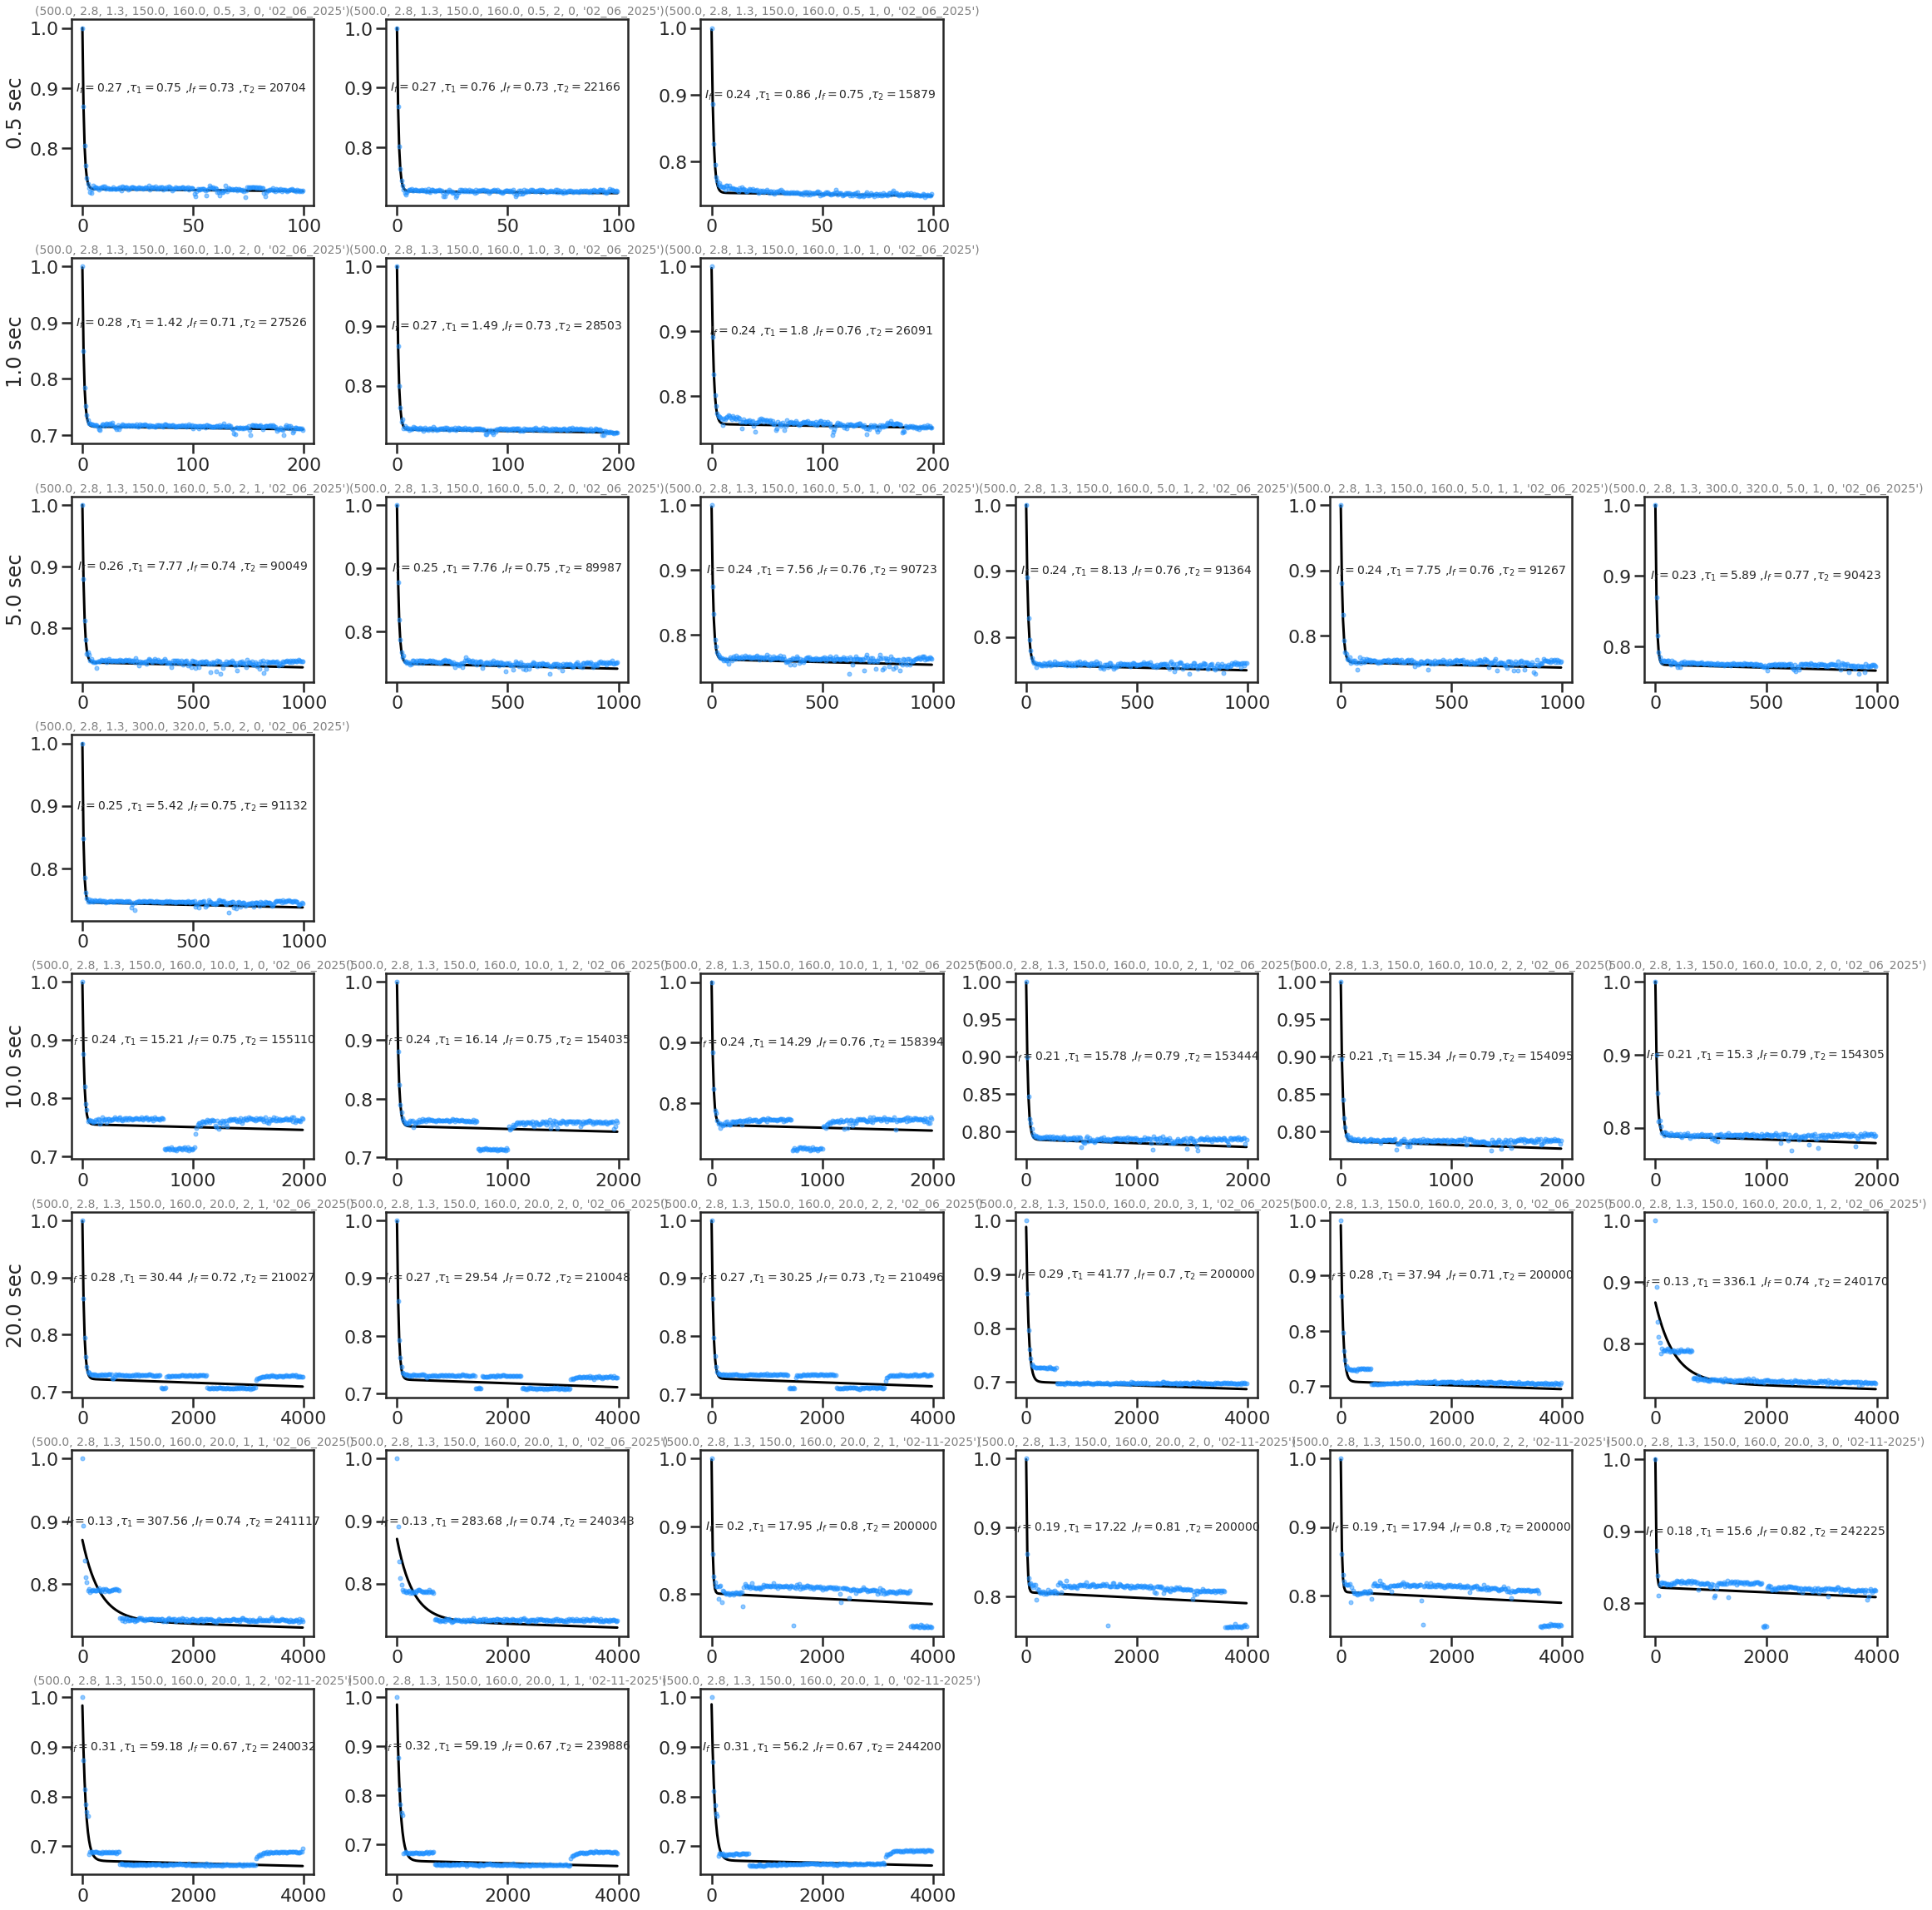

In [378]:
### Intervals
dataFitdir_unsrt = {}
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
#uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(32, 32))
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(intervals)):
    c = intervals[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(np.array(list(datadir.keys()))[:,5].astype(float) == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(str(intervals[ii]) + ' sec')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        jkey = list(datadir.keys())[idxsForThisC[j]]
        axs[rowCounter, colCounter].set_title(jkey, fontsize=14, color='grey')
        # Plot data
        fitDoubExp_tau2fit= doubExpFit_tau2fit(datadir[jkey]['timesSeconds'], datadir[jkey]['ims405avg']/datadir[jkey]['ims405avg'].max(), dataFitdir_SEC[jkey], [c*1e4])
        dataFitdir_unsrt[jkey]=np.concatenate((dataFitdir_SEC[jkey], fitDoubExp_tau2fit.x))
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'], doubExp_tau2fit(datadir[jkey]['timesSeconds'], dataFitdir_SEC[jkey], fitDoubExp_tau2fit.x), ls='-', color='k')


        fitString=r'$I_f=$'+str(round(dataFitdir_SEC[jkey][0],2))+' ,'+r'$\tau_1=$'+str(round(dataFitdir_SEC[jkey][1],2))+' ,'+r'$I_f=$'+str(round(dataFitdir_SEC[jkey][2],2))+' ,'+r'$\tau_2=$'+str(round(fitDoubExp_tau2fit.x[0]))
        axs[rowCounter, colCounter].text(datadir[jkey]['timesSeconds'][-1]//2, 0.9, fitString, ha='center', va='center', fontsize=14)
        
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'],
                                    datadir[jkey]['ims405avg']/datadir[jkey]['ims405avg'].max(), 'o', ms=5, alpha=0.5, color='dodgerblue')       

        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

# Adjust layout and display the plot
plt.tight_layout()

#put the keys of the fit dictionary in the same order as datadir
dataFitdir_DEtau2fit = {}
for item in list(datadir.keys()):
    dataFitdir_DEtau2fit[item] = dataFitdir_unsrt[item]

# # plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_Motors_globalTimeCmap.pdf', 
# #             bbox_inches='tight')

fit to a crop before there are the big spikes down ANA SEPARATE THE SAVE NAMES FOR PARAMS BASED ON CROP OR NOT

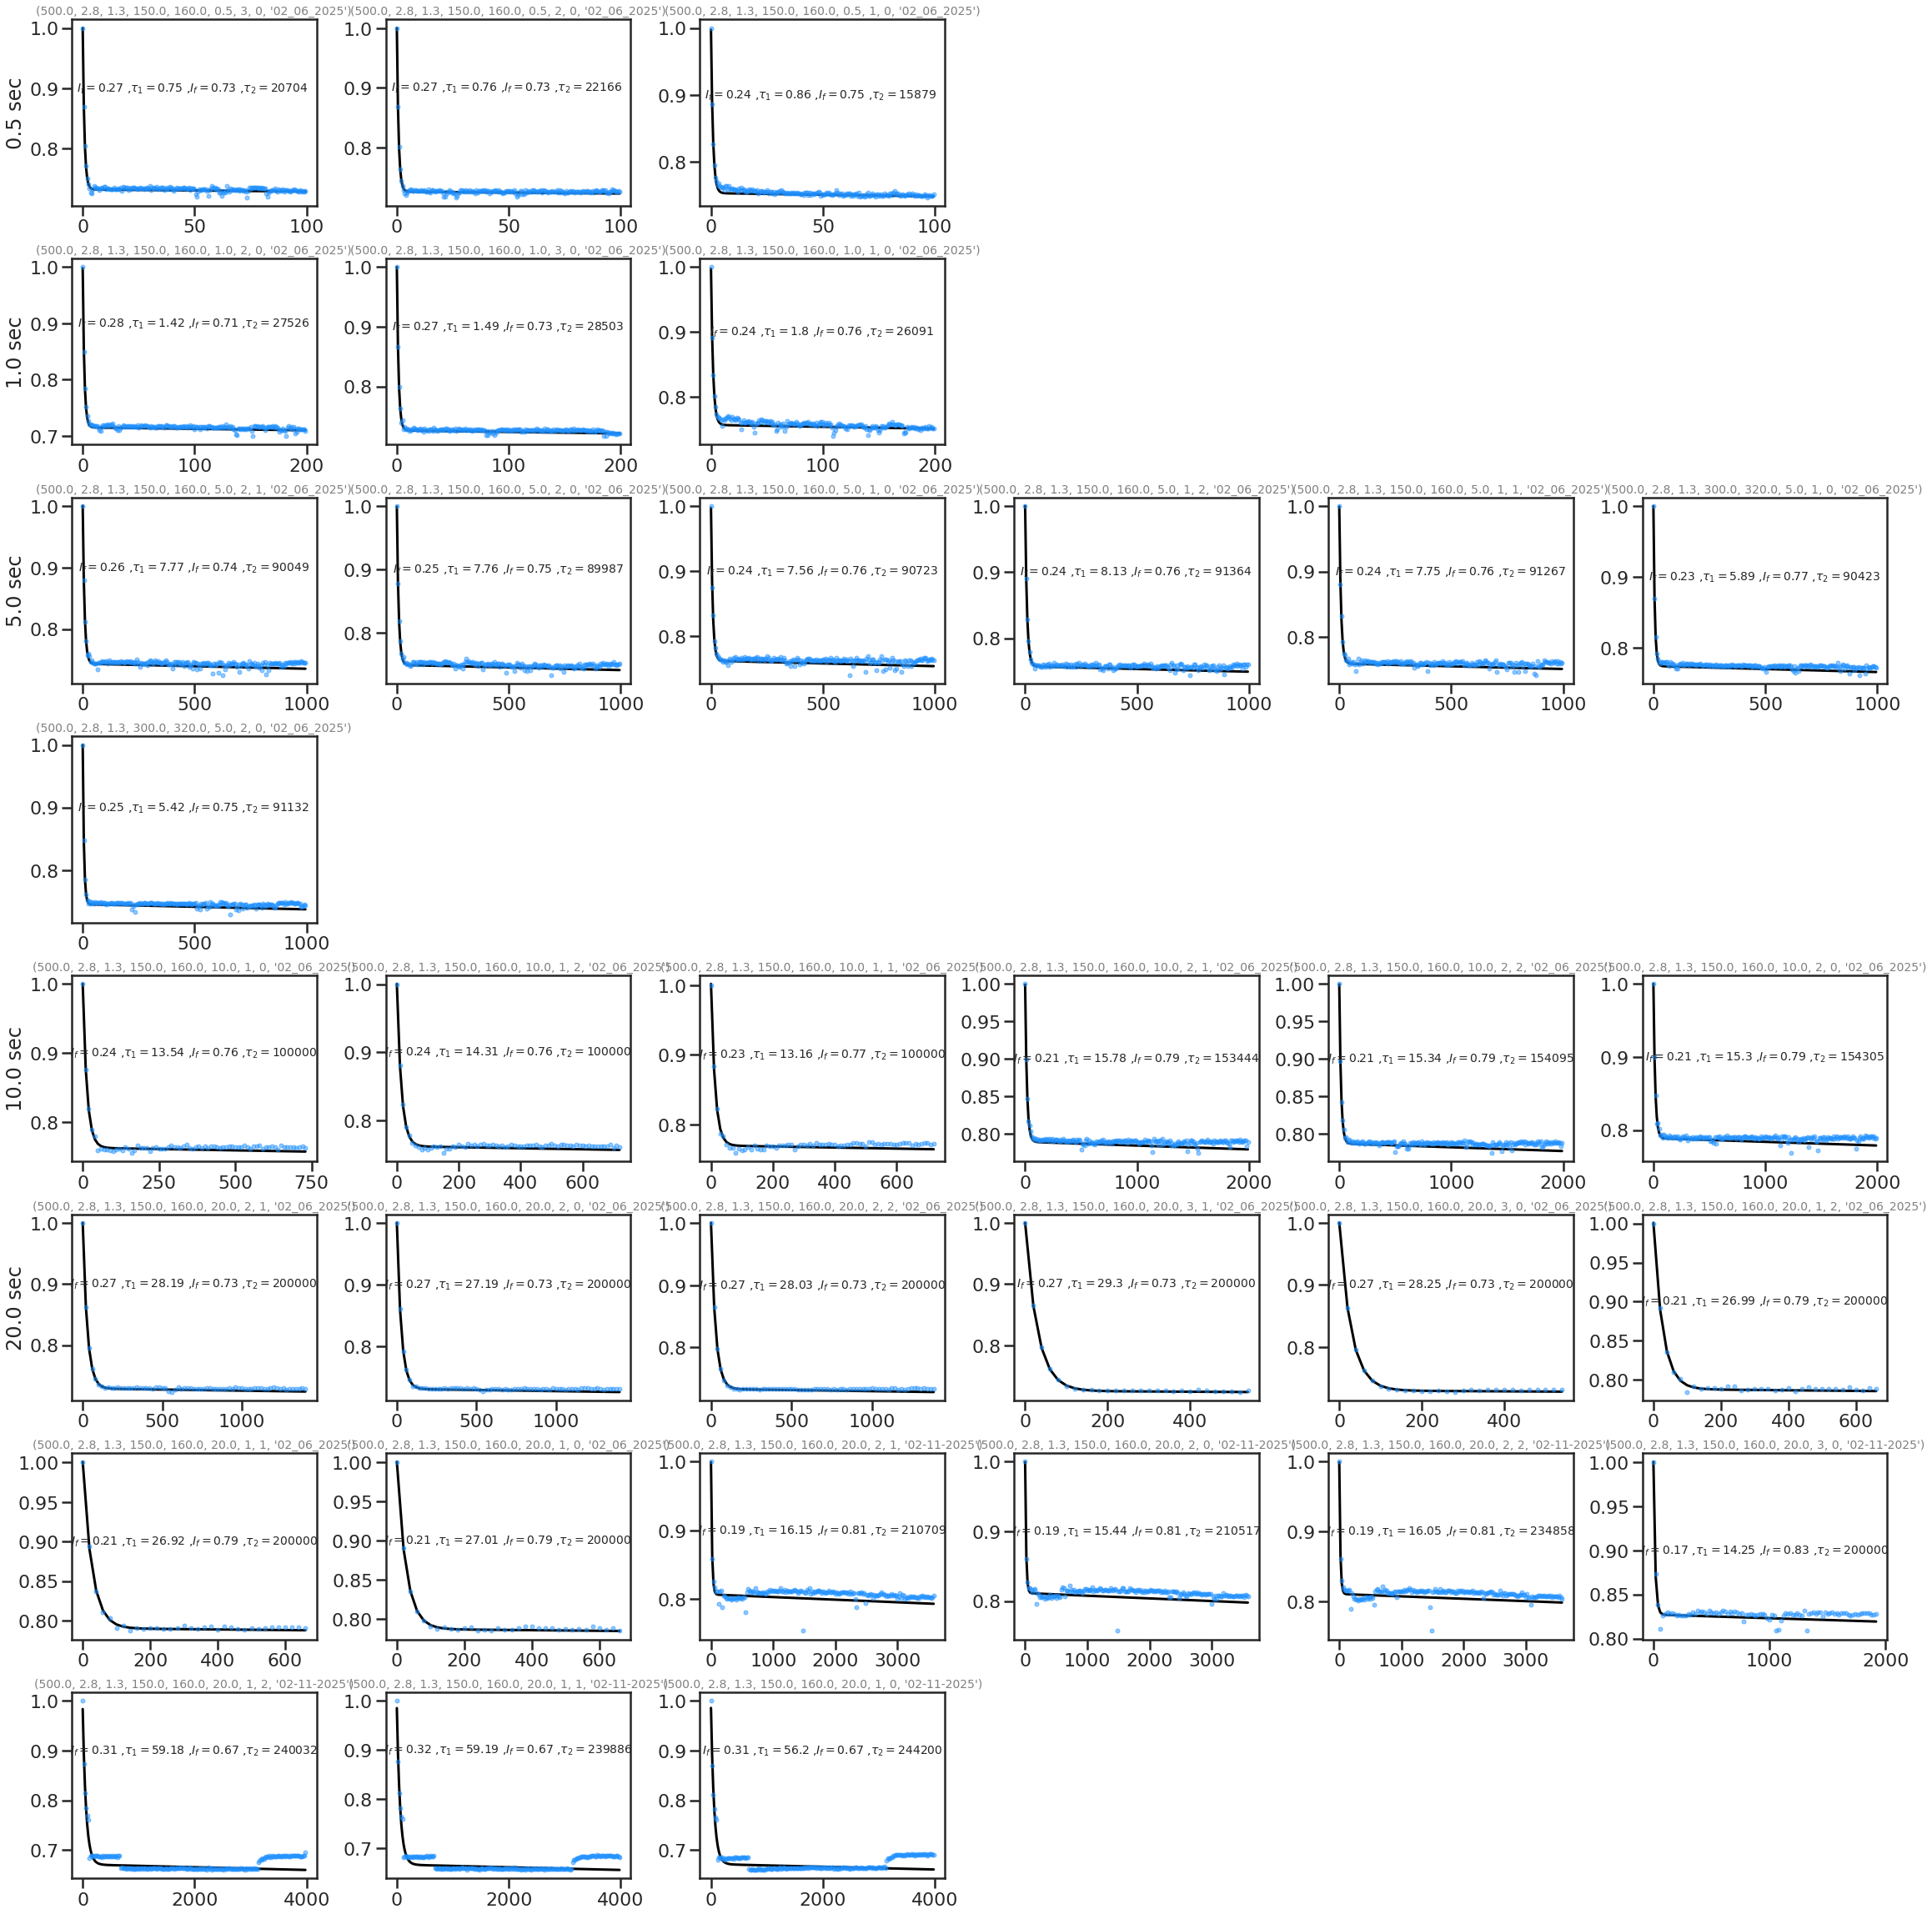

In [379]:
### Intervals
dataFitdir_unsrt = {}
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
#uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(32, 32))
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(intervals)):
    c = intervals[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(np.array(list(datadir.keys()))[:,5].astype(float) == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(str(intervals[ii]) + ' sec')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        jkey = list(datadir.keys())[idxsForThisC[j]]
        dirInfoKeyIdx = np.where(dirInfo['key'] == jkey)[0][0]
        jstop = dirInfo.iloc[dirInfoKeyIdx]['stop_idx']
        
        axs[rowCounter, colCounter].set_title(jkey, fontsize=14, color='grey')
        # Plot data
        fitDoubExp_tau2fit= doubExpFit_tau2fit(datadir[jkey]['timesSeconds'][:jstop], datadir[jkey]['ims405avg'][:jstop]/datadir[jkey]['ims405avg'][:jstop].max(), dataFitdir_SECcrop[jkey], [c*1e4])
        dataFitdir_unsrt[jkey]=np.concatenate((dataFitdir_SECcrop[jkey], fitDoubExp_tau2fit.x))
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'][:jstop], doubExp_tau2fit(datadir[jkey]['timesSeconds'][:jstop], dataFitdir_SECcrop[jkey], fitDoubExp_tau2fit.x), ls='-', color='k')


        fitString=r'$I_f=$'+str(round(dataFitdir_SECcrop[jkey][0],2))+' ,'+r'$\tau_1=$'+str(round(dataFitdir_SECcrop[jkey][1],2))+' ,'+r'$I_f=$'+str(round(dataFitdir_SECcrop[jkey][2],2))+' ,'+r'$\tau_2=$'+str(round(fitDoubExp_tau2fit.x[0]))
        axs[rowCounter, colCounter].text(datadir[jkey]['timesSeconds'][:jstop][-1]//2, 0.9, fitString, ha='center', va='center', fontsize=14)
        
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'][:jstop],
                                    datadir[jkey]['ims405avg'][:jstop]/datadir[jkey]['ims405avg'][:jstop].max(), 'o', ms=5, alpha=0.5, color='dodgerblue')       

        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

# Adjust layout and display the plot
plt.tight_layout()

#put the keys of the fit dictionary in the same order as datadir
dataFitdir_DEtau2fitcrop = {}
for item in list(datadir.keys()):
    dataFitdir_DEtau2fitcrop[item] = dataFitdir_unsrt[item]

# # plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_Motors_globalTimeCmap.pdf', 
# #             bbox_inches='tight')

(0.74, 0.78)

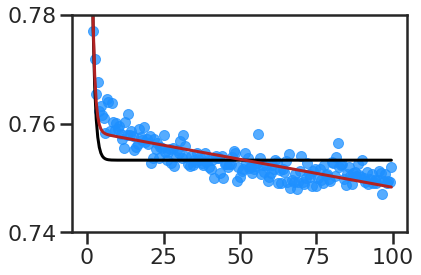

In [398]:
plt.plot(datadir[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]['timesSeconds'],
                                    datadir[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]['ims405avg']/datadir[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]['ims405avg'].max(), 'o', ms=10, alpha=0.75, color='dodgerblue')

plt.plot(datadir[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]['timesSeconds'], singExpConst(datadir[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]['timesSeconds'], dataFitdir_SEC[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]), ls='-', color='k')

plt.plot(datadir[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]['timesSeconds'], doubExp(datadir[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]['timesSeconds'], dataFitdir_DE[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')]), ls='-', color='firebrick')

plt.ylim(0.74,0.78)

In [401]:
print(dataFitdir_SEC[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')])
print(dataFitdir_DE[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')])
print(dataFitdir_DEtau2fit[(500.0, 2.8, 1.3, 150.0, 160.0, 0.5, 1, 0, '02_06_2025')])

[0.24410382 0.86371027 0.75327017]
[2.40615647e-01 8.01313569e-01 7.58619522e-01 7.27530128e+03]
[2.44103821e-01 8.63710268e-01 7.53270165e-01 1.58789547e+04]


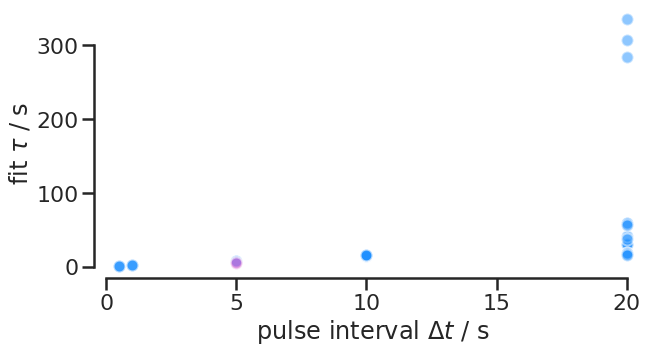

In [89]:
fig, ax = plt.subplots(figsize=(10,5))

plt.scatter(np.array(list(dataFitdir.keys()))[regExpTime_idx, 5].astype(float), 
            np.array(list(dataFitdir.values()))[regExpTime_idx, 1],
           color='dodgerblue',
           ec='white',
           alpha=0.5)
plt.scatter(np.array(list(dataFitdir.keys()))[doubExpTime_idx, 5].astype(float), 
            np.array(list(dataFitdir.values()))[doubExpTime_idx, 1],
           color='orchid',
           ec='white',
           alpha=0.5)
#plt.ylim(-1,75)
#plt.xlim(0,12)
#plt.yscale('log')

plt.ylabel(r'fit $\tau$ / s')
plt.xlabel(r'pulse interval $\Delta t$ / s')

sns.despine(trim=True)

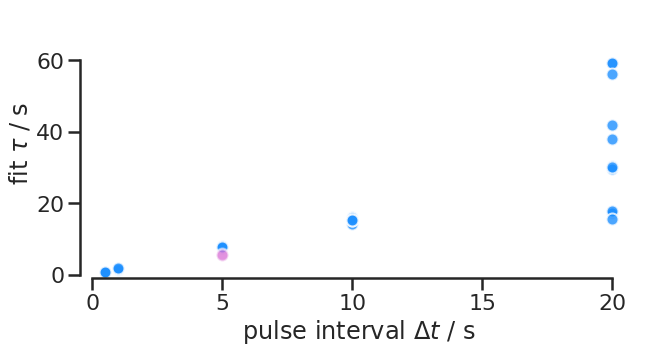

In [90]:
## zoom in (exclude the abberrent 20 second fits)
fig, ax = plt.subplots(figsize=(10,5))

plt.scatter(np.array(list(dataFitdir.keys()))[regExpTime_idx, 5].astype(float), 
            np.array(list(dataFitdir.values()))[regExpTime_idx, 1],
           color='dodgerblue',
           ec='white',
           alpha=0.8)
plt.scatter(np.array(list(dataFitdir.keys()))[doubExpTime_idx, 5].astype(float), 
            np.array(list(dataFitdir.values()))[doubExpTime_idx, 1],
           color='orchid',
           ec='white',
           alpha=0.5)

plt.ylim(-1,75)
#plt.xlim(0,12)
#plt.yscale('log')

plt.ylabel(r'fit $\tau$ / s')
plt.xlabel(r'pulse interval $\Delta t$ / s')

sns.despine(trim=True)

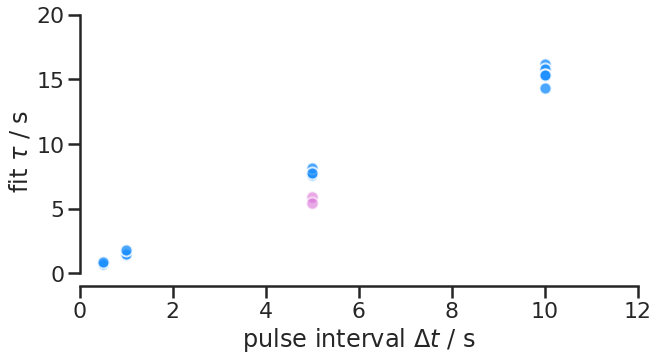

In [95]:
## zoom in (crop 20s interval all together)
fig, ax = plt.subplots(figsize=(10,5))

plt.scatter(np.array(list(dataFitdir.keys()))[regExpTime_idx, 5].astype(float), 
            np.array(list(dataFitdir.values()))[regExpTime_idx, 1],
           color='dodgerblue',
           ec='white',
           alpha=0.8)
plt.scatter(np.array(list(dataFitdir.keys()))[doubExpTime_idx, 5].astype(float), 
            np.array(list(dataFitdir.values()))[doubExpTime_idx, 1],
           color='orchid',
           ec='white',
           alpha=0.6)
#slope, intercept = np.polyfit(np.array(list(dataFitdir.keys()))[regExpTime_idx, 5].astype(float), np.array(list(dataFitdir.values()))[regExpTime_idx, 1], deg=1)
plt.ylim(-1,20)
plt.xlim(0,12)
#plt.yscale('log')

plt.ylabel(r'fit $\tau$ / s')
plt.xlabel(r'pulse interval $\Delta t$ / s')

sns.despine(trim=True)

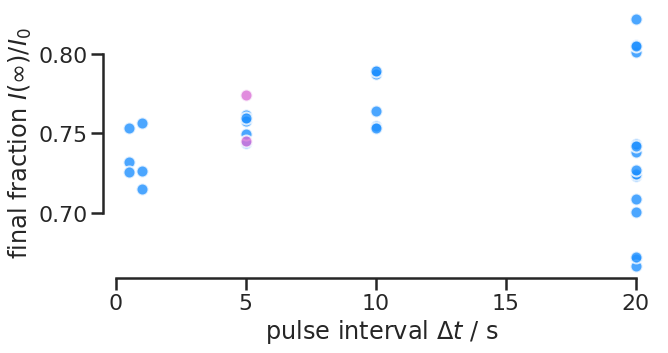

In [96]:
## zoom in (exclude the abberrent 20 second fits)
fig, ax = plt.subplots(figsize=(10,5))

plt.scatter(np.array(list(dataFitdir.keys()))[regExpTime_idx, 5].astype(float), 
            np.array(list(dataFitdir.values()))[regExpTime_idx, -1],
           color='dodgerblue',
           ec='white',
           alpha=0.8)
plt.scatter(np.array(list(dataFitdir.keys()))[doubExpTime_idx, 5].astype(float), 
            np.array(list(dataFitdir.values()))[doubExpTime_idx, -1],
           color='orchid',
           ec='white',
           alpha=0.8)
#plt.ylim(-1,75)
#plt.xlim(0,12)
#plt.yscale('log')

plt.ylabel(r'final fraction $I(\infty)/I_0$')
plt.xlabel(r'pulse interval $\Delta t$ / s')

sns.despine(trim=True)

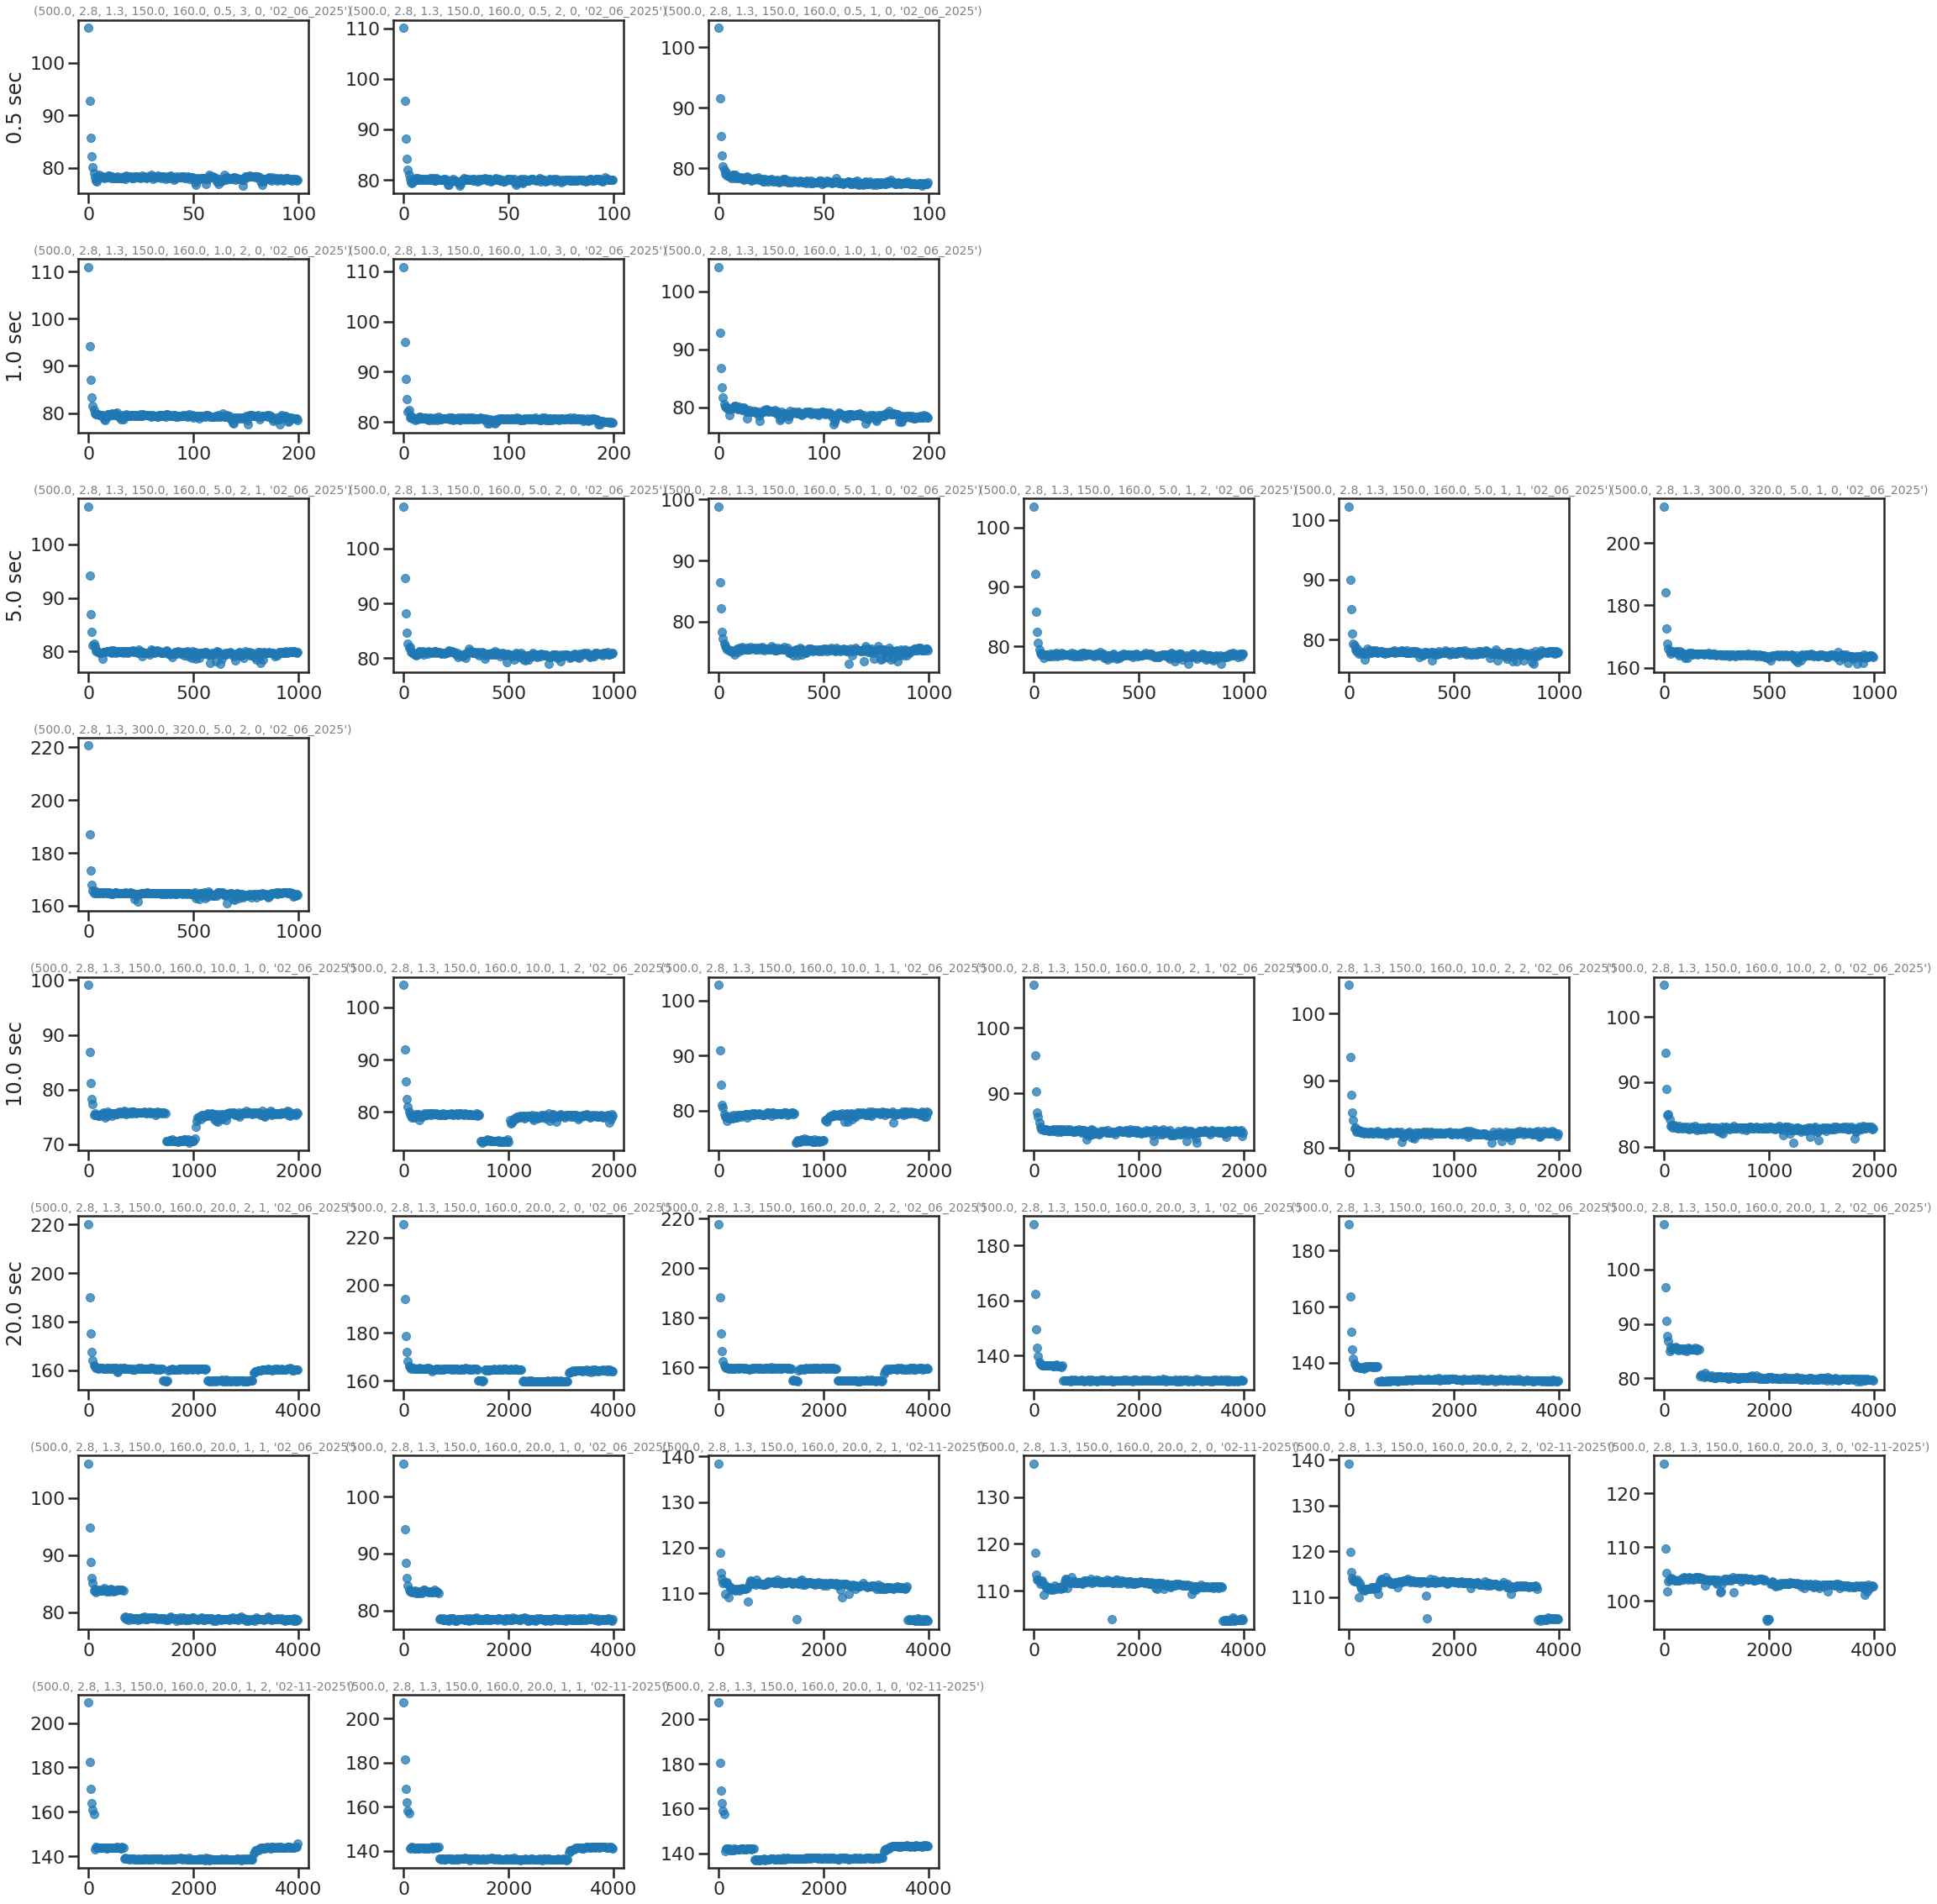

In [417]:
##### MOTORS, flexible axes limits

# # define helper function that takes as input an atp time and gives color
# global_timeCmap_ATP=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=minATPtime, vmax=maxATPtime)(time))
# global_timeCmap_Mot=lambda time:sns.color_palette("flare", as_cmap=True)(matplotlib.colors.Normalize(vmin=minMottime, vmax=maxMottime)(time))

### Intervals
intervals= np.unique(np.array(list(datadir.keys()))[:,5].astype(float))
#uniqueConcs = np.unique(allProps_verb[:, 1])
nrows, ncols = 8, 6  # Number of rows and columns in the subplot grid
fig, axs = plt.subplots(nrows=nrows, 
                        ncols=ncols,
                        figsize=(32, 32))
rowCounter = 0  # Initialize row counter
colCounter = 0  # Initialize column counter
# Iterate over unique concentrations
for ii in range(len(intervals)):
    c = intervals[ii]
    # Get indices for this concentration
    idxsForThisC = np.where(np.array(list(datadir.keys()))[:,5].astype(float) == c)[0]
    if colCounter==0:
        axs[rowCounter, colCounter].set_ylabel(str(intervals[ii]) + ' sec')
    
    # Iterate over indices for this concentration
    for j in range(len(idxsForThisC)):
        # Check if we've exceeded the subplot grid
        if rowCounter >= nrows:
            print("Warning: Not enough subplots to display all data.")
            break  # Exit if no more subplots are available
            
        jkey = list(datadir.keys())[idxsForThisC[j]]
        axs[rowCounter, colCounter].set_title(jkey, fontsize=14, color='grey')
        # Plot data
        axs[rowCounter, colCounter].plot(datadir[jkey]['timesSeconds'],
                                    datadir[jkey]['ims405avg'], 'o', ms=10, alpha=0.75)
        
        # #axs[rowCounter, colCounter].plot(1, 1, 'ro')
        # ## get this gname's analyzed data files & parse
        # #axs[thisSubplIdx].plot(1,1, 'ro')
        # h5spath=gnameList[idxsForThisC[j]].split('data')[0]+'analyzed_data'+gnameList[idxsForThisC[j]].split('data')[1]+'/'
        # h5dic = read_h5py(h5spath)
    
        # # this is (numTimes, numRbinMidpoints)
        # rMotmids=h5dic['all_rMotbins']*umperpixel
        # rMotavgs=h5dic['all_rMotavgs']
        # timesMot=h5dic['timesMot']
        # for time in range(rMotmids.shape[0]):
        #     axs[rowCounter, colCounter].plot(rMotmids[time,:],
        #                            rMotavgs[time,:], alpha=0.75, 
        #                            color=global_timeCmap_Mot(timesMot[time]))#sns.color_palette("flare", as_cmap=True)(time/rMotmids.shape[0]), lw=2)        
        
        

        
        
        # Move to the next column
        colCounter += 1
        # If we've reached the end of the columns, reset colCounter and increment rowCounter
        if colCounter >= ncols:
            colCounter = 0
            rowCounter += 1

    # After processing this concentration, move to the next row if not already at the start of a new row
    if colCounter != 0:
        colCounter = 0
        rowCounter += 1


# # [r'$' + str(c) + r'\ \mu$M NCD' for c in uniqueConcs]
# # hack for labeling
# axs[5,0].set_ylabel(r'$' + str(intervals[4]) + r'\ \mu$M NCD');
# axs[6,0].set_ylabel(r'$' + str(intervals[4]) + r'\ \mu$M NCD');

# Iterate through all subplots to hide empty ones
for ax in axs.flat:  # .flat iterates over all subplots in the grid
    if not ax.has_data():  # Check if the subplot has any data
        ax.set_visible(False)  # Hide the entire axis

# plt.suptitle('motor distributions')
# # Add a common x-label
# fig.text(0.5, -0.01, 'radial position $r$ / $\mu$m', ha='center', va='center')
# # Add a common y-label
# fig.text(-0.01, 0.5, '[NCD] / $\mu M$', ha='center', va='center', rotation=90)


# ######
# # Adjust the top margin to make space for the colorbar
# fig.subplots_adjust(top=0.85)

# # Create an axis for the colorbar that spans all columns
# cax = fig.add_axes([0.05, 1, 0.92, 0.012])  # [left, bottom, width, height]

# # Create the colorbar
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("flare", as_cmap=True), norm=mcolors.Normalize(vmin=minMottime, vmax=maxMottime)),
#                     cax=cax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=20)

# # Move colorbar label and ticks to the top
# cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
# cbar.ax.xaxis.set_label_position('top')   # Move label to top
# cbar.set_label('time / s', fontsize=20, labelpad=10)

# Adjust layout and display the plot
plt.tight_layout()

# # plt.savefig('20241118_initialMultipleAster_smlMltpls_crrctGrid_Motors_globalTimeCmap.pdf', 
# #             bbox_inches='tight')

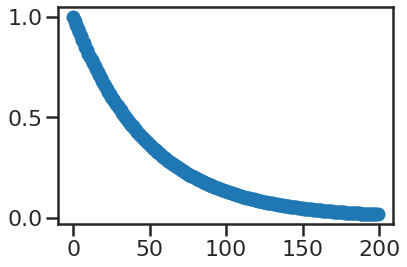

In [418]:
plt.scatter(np.arange(200), 0.98**np.arange(200))

In [365]:
[datadir[key] for key in datadir.keys() if key[3]==0.5 and key[2]==160]

[{'timesSeconds': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
          5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
         11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
         16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
         22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
         27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
         33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
         38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
         44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
         49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
         55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ,
         60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. , 64.5, 65. , 65.5,
         66. , 66.5, 67. , 67.5, 68. , 68.5, 69. , 69.5, 70. , 70.5, 71. ,
         

In [364]:
[datadir[key] for key in datadir.keys() if key[3]==0.5 and key[2]==160]

[{'timesSeconds': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
          5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
         11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
         16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
         22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
         27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
         33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
         38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
         44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
         49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
         55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ,
         60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. , 64.5, 65. , 65.5,
         66. , 66.5, 67. , 67.5, 68. , 68.5, 69. , 69.5, 70. , 70.5, 71. ,
         

In [358]:
datadir[500.0, 150.0, 160.0, 20.0, 2, '1', '02_06_2025']

{'timesSeconds': array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
         360.,  380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,
         540.,  560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,
         720.,  740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,
         900.,  920.,  940.,  960.,  980., 1000., 1020., 1040., 1060.,
        1080., 1100., 1120., 1140., 1160., 1180., 1200., 1220., 1240.,
        1260., 1280., 1300., 1320., 1340., 1360., 1380., 1400., 1420.,
        1440., 1460., 1480., 1500., 1520., 1540., 1560., 1580., 1600.,
        1620., 1640., 1660., 1680., 1700., 1720., 1740., 1760., 1780.,
        1800., 1820., 1840., 1860., 1880., 1900., 1920., 1940., 1960.,
        1980., 2000., 2020., 2040., 2060., 2080., 2100., 2120., 2140.,
        2160., 2180., 2200., 2220., 2240., 2260., 2280., 2300., 2320.,
        2340., 2360., 2380., 2400., 2420., 2440., 2460., 2480

# Pre h5's Do it with fixing uneven illumination

doesnt acount for anomolyous bright spots

perform uneven illum correction and then average images. For ratios, I took the mean first. If you divide and then take the mean there are NaNs from divide by zeros

Compute evened results and store the average value of images for all datasets

In [53]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)
crop = np.s_[300:900, 700:1300]
cropAcrossTimes = np.s_[:, 300:900, 700:1300]

In [54]:
tstart=time.time()
evenedResults={}
for key in results.keys():
    arrs = results[key]
    arrs_sub = backSubtract(arrs, dark_avg)
    arrs_even=norm_unev(np.array(arrs_sub)[cropAcrossTimes])
    evenedResults[key] = np.mean(arrs_even, axis=(1,2))


# for a, atp in enumerate(ATPconcs24):
#     for pos in Pos24:
#         for channel in ['405','480']:
#             arrs = results24[atp, pos, channel]
#             arrs_sub = backSubtract(arrs, dark_avg)
#             arrs_even=norm_unev(np.array(arrs_sub)[cropAcrossTimes])
#             # arrs_405even=norm_unev(arrs_sub[0][cropAcrossTimes])
#             # arrs_480even=norm_unev(arrs_sub[1][cropAcrossTimes])
#             #ratios = arrs_even[0]/arrs_even[1]

#             evenedResults24[(atp, pos, channel)] = np.mean(arrs_even, axis=(1,2))
#             #evenedResults24[(atp, pos, '480')] = np.mean(arrs_480even, axis=(1,2))
#         evenedResults24[(atp, pos, 'ratio')] = evenedResults24[(atp, pos, '405')]/evenedResults24[(atp, pos, '480')] #np.mean(arrs_405even, axis=(1,2))/np.mean(arrs_480even, axis=(1,2)) #np.nanmean(ratios, axis=(1,2)) #mean first
#             #evenedResults[(atp, pos, 'ratio')] = np.nanmean(ratios, axis=(1,2)) #divide first

#         # Manual Status bar
#         print("\r"+str(round((a+1)*100/len(ATPconcs24)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
        
# print('')

# tstart=time.time()
# evenedResults23={}
# for a, atp in enumerate(ATPconcs23):
#     for pos in Pos23:
#         for channel in ['405','480']:
#             arrs = results23[atp, pos, channel]
#             arrs_sub = backSubtract(arrs, dark_avg)
#             arrs_even=norm_unev(np.array(arrs_sub)[cropAcrossTimes])
#             # arrs_405even=norm_unev(arrs_sub[0][cropAcrossTimes])
#             # arrs_480even=norm_unev(arrs_sub[1][cropAcrossTimes])
#             #ratios = arrs_even[0]/arrs_even[1]

#             evenedResults23[(atp, pos, channel)] = np.mean(arrs_even, axis=(1,2))
#             #evenedResults23[(atp, pos, '480')] = np.mean(arrs_480even, axis=(1,2))
#         evenedResults23[(atp, pos, 'ratio')] = evenedResults23[(atp, pos, '405')]/evenedResults23[(atp, pos, '480')] #np.mean(arrs_405even, axis=(1,2))/np.mean(arrs_480even, axis=(1,2)) #np.nanmean(ratios, axis=(1,2)) #mean first
#             #evenedResults[(atp, pos, 'ratio')] = np.nanmean(ratios, axis=(1,2)) #divide first

#         # Manual Status bar
#         print("\r"+str(round((a+1)*100/len(ATPconcs23)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")

In [62]:
list(evenedResults.keys())

[(500.0, 'Pos0', '405', 150.0, 1.0, 2),
 (500.0, 'Pos0', '480', 160.0, 1.0, 2),
 (500.0, 'Pos0', '405', 150.0, 10.0, 1),
 (500.0, 'Pos0', '480', 160.0, 10.0, 1),
 (500.0, 'Pos2', '405', 150.0, 10.0, 1),
 (500.0, 'Pos2', '480', 160.0, 10.0, 1),
 (500.0, 'Pos1', '405', 150.0, 10.0, 1),
 (500.0, 'Pos1', '480', 160.0, 10.0, 1),
 (500.0, 'Pos1', '405', 150.0, 5.0, 2),
 (500.0, 'Pos1', '480', 160.0, 5.0, 2),
 (500.0, 'Pos0', '405', 150.0, 5.0, 2),
 (500.0, 'Pos0', '480', 160.0, 5.0, 2),
 (500.0, 'Pos0', '405', 150.0, 5.0, 1),
 (500.0, 'Pos0', '480', 160.0, 5.0, 1),
 (500.0, 'Pos1', '405', 150.0, 10.0, 2),
 (500.0, 'Pos1', '480', 160.0, 10.0, 2),
 (500.0, 'Pos2', '405', 150.0, 10.0, 2),
 (500.0, 'Pos2', '480', 160.0, 10.0, 2),
 (500.0, 'Pos0', '405', 150.0, 10.0, 2),
 (500.0, 'Pos0', '480', 160.0, 10.0, 2),
 (500.0, 'Pos2', '405', 150.0, 5.0, 1),
 (500.0, 'Pos2', '480', 160.0, 5.0, 1),
 (500.0, 'Pos1', '405', 150.0, 5.0, 1),
 (500.0, 'Pos1', '480', 160.0, 5.0, 1),
 (500.0, 'Pos0', '405', 150.

In [108]:
oneSecIntervalFiles405 = [evenedResults[key] for key in results.keys() if key[-2]==1 and key[2]=='405']
oneSecIntervalFiles480 = [evenedResults[key] for key in results.keys() if key[-2]==1 and key[2]=='480']
fiveSecIntervalFiles405 =[evenedResults[key] for key in results.keys() if key[-2]==5 and key[2]=='405']
fiveSecIntervalFiles480 =[evenedResults[key] for key in results.keys() if key[-2]==5 and key[2]=='480']
tenSecIntervalFiles405 = [evenedResults[key] for key in results.keys() if key[-2]==10 and key[2]=='405' and key[-1]==2]# excise problematic drop
tenSecIntervalFiles480 = [evenedResults[key] for key in results.keys() if key[-2]==10 and key[2]=='480' and key[-1]==2]# excise problematic drop

In [109]:
withkeys_oneSecIntervalFiles405 = [(evenedResults[key], key) for key in results.keys() if key[-2]==1 and key[2]=='405']
withkeys_oneSecIntervalFiles480 = [(evenedResults[key], key) for key in results.keys() if key[-2]==1 and key[2]=='480']
withkeys_fiveSecIntervalFiles405 =[(evenedResults[key], key) for key in results.keys() if key[-2]==5 and key[2]=='405']
withkeys_fiveSecIntervalFiles480 =[(evenedResults[key], key) for key in results.keys() if key[-2]==5 and key[2]=='480']
withkeys_tenSecIntervalFiles405 = [(evenedResults[key], key) for key in results.keys() if key[-2]==10 and key[2]=='405' and key[-1]==2] # excise problematic drop
withkeys_tenSecIntervalFiles480 = [(evenedResults[key], key) for key in results.keys() if key[-2]==10 and key[2]=='480' and key[-1]==2]# excise problematic drop

In [110]:
## 405
oneColor='olive'
fiveColor='dodgerblue'
tenColor='orchid'

medOne405=np.median(np.array(oneSecIntervalFiles405), axis=0)
medFive405=np.median(np.array(fiveSecIntervalFiles405),axis=0)
medTen405=np.median(np.array(tenSecIntervalFiles405), axis=0)

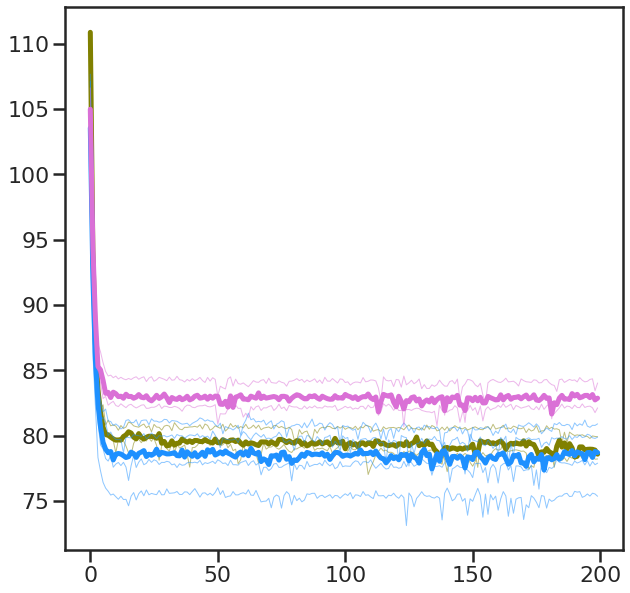

In [111]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(medOne405, lw=5, alpha=1, color=oneColor)
for ii in range(len(oneSecIntervalFiles405)):
    plt.plot(oneSecIntervalFiles405[ii], lw=1, alpha=0.5, color=oneColor)

plt.plot(medFive405, lw=5, alpha=1, color=fiveColor)
for ii in range(len(fiveSecIntervalFiles405)):
    plt.plot(fiveSecIntervalFiles405[ii], lw=1, alpha=0.5, color=fiveColor)

plt.plot(medTen405, lw=5, alpha=1, color=tenColor)
for ii in range(len(tenSecIntervalFiles405)):
    plt.plot(tenSecIntervalFiles405[ii], lw=1, alpha=0.5, color=tenColor)

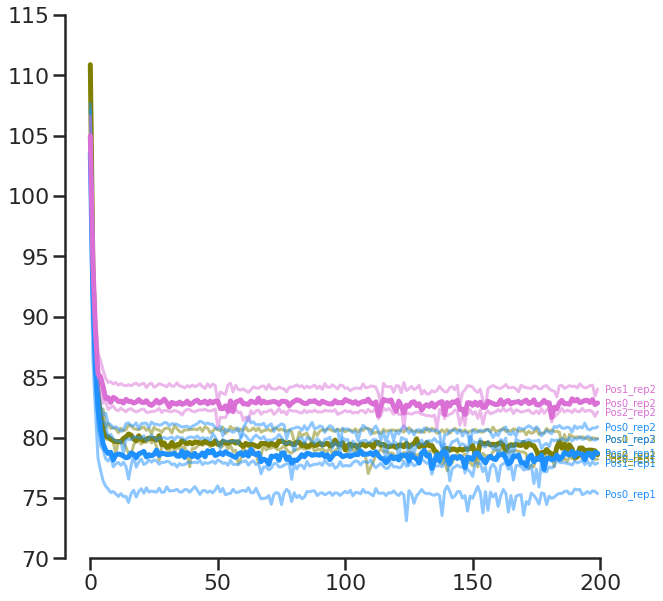

In [162]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
plt.plot(medOne405, lw=5, alpha=1, color=oneColor)
for ii in range(len(oneSecIntervalFiles405)):
    plt.plot(oneSecIntervalFiles405[ii],  alpha=0.5, color=oneColor)
    plt.text(200+2, oneSecIntervalFiles405[ii][-1], 
             withkeys_oneSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_oneSecIntervalFiles405[ii][-1][-1]),color=oneColor, ha='left', va='center')
ax.set_ylim([70,115])
sns.despine(trim=True, ax=ax)

# fig, ax = plt.subplots(figsize=(10,10))
plt.plot(medFive405, lw=5, alpha=1, color=fiveColor)
for ii in range(len(fiveSecIntervalFiles405)):
    plt.plot(fiveSecIntervalFiles405[ii], alpha=0.5, color=fiveColor)
    plt.text(200+2, fiveSecIntervalFiles405[ii][-1], 
             withkeys_fiveSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_fiveSecIntervalFiles405[ii][-1][-1]),color=fiveColor, ha='left', va='center')
sns.despine(trim=True, ax=ax)

# fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim([70,115])
plt.plot(medTen405, lw=5, alpha=1, color=tenColor)
for ii in range(len(tenSecIntervalFiles405)):
    plt.plot(tenSecIntervalFiles405[ii], alpha=0.5, color=tenColor)
    plt.text(200+2, tenSecIntervalFiles405[ii][-1], 
             withkeys_tenSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_tenSecIntervalFiles405[ii][-1][-1]),color=tenColor, ha='left', va='center')
ax.set_ylim([70,115])
sns.despine(trim=True, ax=ax)




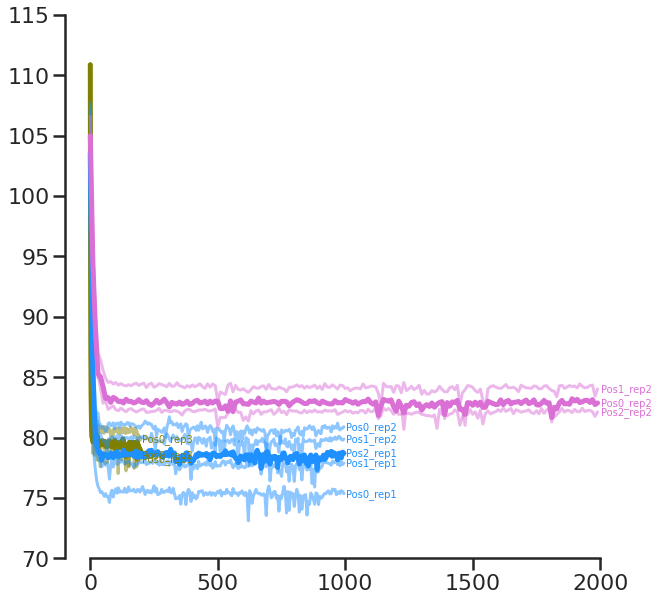

In [141]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
plt.plot(medOne405, lw=5, alpha=1, color=oneColor)
for ii in range(len(oneSecIntervalFiles405)):
    plt.plot(oneSecIntervalFiles405[ii],  alpha=0.5, color=oneColor)
    plt.text(200+2, oneSecIntervalFiles405[ii][-1], 
             withkeys_oneSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_oneSecIntervalFiles405[ii][-1][-1]),color=oneColor, ha='left', va='center')
#sns.despine(trim=True, ax=ax)

# fig, ax = plt.subplots(figsize=(10,10))
plt.plot(np.arange(len(fiveSecIntervalFiles405[-1]))*5, medFive405, lw=5, alpha=1, color=fiveColor)
for ii in range(len(fiveSecIntervalFiles405)):
    plt.plot(np.arange(len(fiveSecIntervalFiles405[ii]))*5, fiveSecIntervalFiles405[ii], alpha=0.5, color=fiveColor)
    plt.text(200*5+2, fiveSecIntervalFiles405[ii][-1], 
             withkeys_fiveSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_fiveSecIntervalFiles405[ii][-1][-1]),color=fiveColor, ha='left', va='center')
#sns.despine(trim=True, ax=ax)

# fig, ax = plt.subplots(figsize=(10,10))
plt.plot(np.arange(len(tenSecIntervalFiles405[-1]))*10, medTen405, lw=5, alpha=1, color=tenColor)
for ii in range(len(tenSecIntervalFiles405)):
    plt.plot(np.arange(len(tenSecIntervalFiles405[ii]))*10, tenSecIntervalFiles405[ii], alpha=0.5, color=tenColor)
    plt.text(200*10+2, tenSecIntervalFiles405[ii][-1], 
             withkeys_tenSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_tenSecIntervalFiles405[ii][-1][-1]),color=tenColor, ha='left', va='center')
ax.set_ylim([70,115])
sns.despine(trim=True, ax=ax)




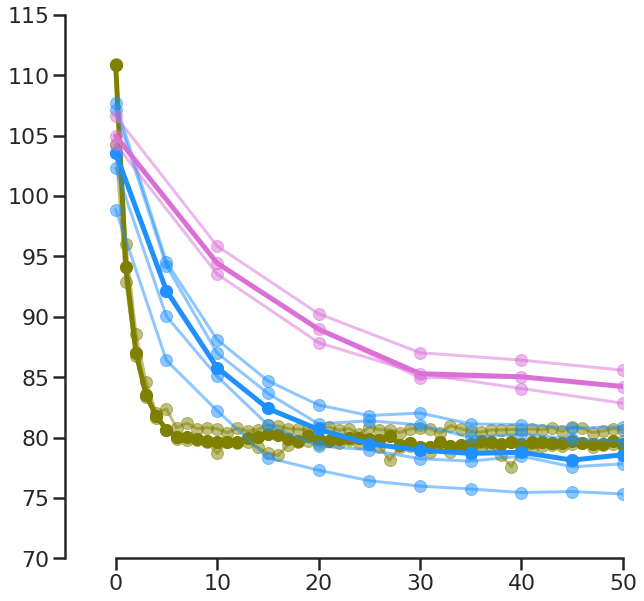

In [188]:
# just zoooooooom 
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
plt.plot(medOne405, 'o-',lw=5, alpha=1, color=oneColor)
for ii in range(len(oneSecIntervalFiles405)):
    plt.plot(oneSecIntervalFiles405[ii],  'o-', alpha=0.5, color=oneColor)
    #plt.text(200+2, oneSecIntervalFiles405[ii][-1], 
    #         withkeys_oneSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_oneSecIntervalFiles405[ii][-1][-1]),color=oneColor, ha='left', va='center')
#sns.despine(trim=True, ax=ax)

# fig, ax = plt.subplots(figsize=(10,10))
plt.plot(np.arange(len(fiveSecIntervalFiles405[-1]))*5, medFive405, 'o-', lw=5, alpha=1, color=fiveColor)
for ii in range(len(fiveSecIntervalFiles405)):
    plt.plot(np.arange(len(fiveSecIntervalFiles405[ii]))*5, fiveSecIntervalFiles405[ii], 'o-', alpha=0.5, color=fiveColor)
    #plt.text(200*5+2, fiveSecIntervalFiles405[ii][-1], 
    #         withkeys_fiveSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_fiveSecIntervalFiles405[ii][-1][-1]),color=fiveColor, ha='left', va='center')
#sns.despine(trim=True, ax=ax)

# fig, ax = plt.subplots(figsize=(10,10))
plt.plot(np.arange(len(tenSecIntervalFiles405[-1]))*10, medTen405, lw=5, alpha=1, color=tenColor)
for ii in range(len(tenSecIntervalFiles405)):
    plt.plot(np.arange(len(tenSecIntervalFiles405[ii]))*10, tenSecIntervalFiles405[ii], 'o-', alpha=0.5, color=tenColor)
    #plt.text(200*10+2, tenSecIntervalFiles405[ii][-1], 
    #         withkeys_tenSecIntervalFiles405[ii][-1][1]+'_rep'+str(withkeys_tenSecIntervalFiles405[ii][-1][-1]),color=tenColor, ha='left', va='center')
ax.set_ylim([70,115])

ax.set_xlim(-5,50)
sns.despine(trim=True, ax=ax)




/tmp/ipykernel_420984/3980115588.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(len(oneSecIntervalFiles405[ii])), np.log(oneSecIntervalFiles405[0]- oneSecIntervalFiles405[0].min()), 'o-',alpha=0.5, color=oneColor)
/tmp/ipykernel_420984/3980115588.py:9: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(len(fiveSecIntervalFiles405[ii]))*5, np.log(fiveSecIntervalFiles405[0]- fiveSecIntervalFiles405[0].min()), 'o-',alpha=0.5, color=fiveColor)
/tmp/ipykernel_420984/3980115588.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(len(tenSecIntervalFiles405[ii]))*10, np.log(tenSecIntervalFiles405[0]- tenSecIntervalFiles405[0].min()), 'o-',alpha=0.5, color=tenColor)


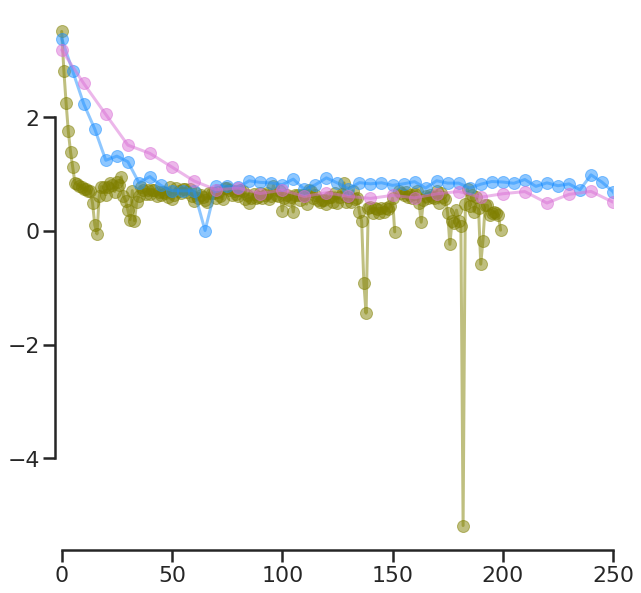

In [189]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))

#plt.plot(medOne405, lw=5, alpha=1, color=oneColor)
plt.plot(np.arange(len(oneSecIntervalFiles405[ii])), np.log(oneSecIntervalFiles405[0]- oneSecIntervalFiles405[0].min()), 'o-',alpha=0.5, color=oneColor)

#plt.plot(np.arange(len(medFive405))*5, np.log(medFive405 - np.min(medFive405)), lw=5, alpha=1, color=fiveColor)
plt.plot(np.arange(len(fiveSecIntervalFiles405[ii]))*5, np.log(fiveSecIntervalFiles405[0]- fiveSecIntervalFiles405[0].min()), 'o-',alpha=0.5, color=fiveColor)
plt.xlim([-3, 250])
#plt.plot(np.arange(len(medTen405))*10, medTen405, lw=5, alpha=1, color=tenColor)
plt.plot(np.arange(len(tenSecIntervalFiles405[ii]))*10, np.log(tenSecIntervalFiles405[0]- tenSecIntervalFiles405[0].min()), 'o-',alpha=0.5, color=tenColor)
sns.despine(trim=True, ax=ax)


In [117]:
## 480
oneColor='olive'
fiveColor='dodgerblue'
tenColor='orchid'

medOne480=np.median(np.array(oneSecIntervalFiles480), axis=0)
medFive480=np.median(np.array(fiveSecIntervalFiles480),axis=0)
medTen480=np.median(np.array(tenSecIntervalFiles480), axis=0)

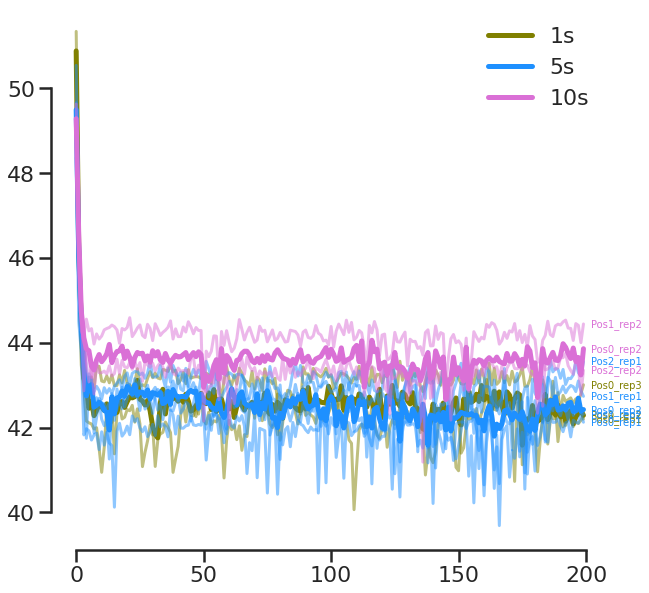

In [128]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
plt.plot(medOne480, lw=5, alpha=1, color=oneColor, label='1s')
for ii in range(len(oneSecIntervalFiles480)):
    plt.plot(oneSecIntervalFiles480[ii],  alpha=0.5, color=oneColor)
    plt.text(200+2, oneSecIntervalFiles480[ii][-1], 
             withkeys_oneSecIntervalFiles480[ii][-1][1]+'_rep'+str(withkeys_oneSecIntervalFiles480[ii][-1][-1]),color=oneColor, ha='left', va='center')
#ax.set_ylim([70,115])
sns.despine(trim=True, ax=ax)

# # fig, ax = plt.subplots(figsize=(10,10))
plt.plot(medFive480, lw=5, alpha=1, color=fiveColor, label='5s')
for ii in range(len(fiveSecIntervalFiles480)):
    plt.plot(fiveSecIntervalFiles480[ii], alpha=0.5, color=fiveColor)
    plt.text(200+2, fiveSecIntervalFiles480[ii][-1], 
             withkeys_fiveSecIntervalFiles480[ii][-1][1]+'_rep'+str(withkeys_fiveSecIntervalFiles480[ii][-1][-1]),color=fiveColor, ha='left', va='center')
sns.despine(trim=True, ax=ax)

# # fig, ax = plt.subplots(figsize=(10,10))
plt.plot(medTen480, lw=5, alpha=1, color=tenColor, label='10s')
for ii in range(len(tenSecIntervalFiles480)):
    plt.plot(tenSecIntervalFiles480[ii], alpha=0.5, color=tenColor)
    plt.text(200+2, tenSecIntervalFiles480[ii][-1], 
             withkeys_tenSecIntervalFiles480[ii][-1][1]+'_rep'+str(withkeys_tenSecIntervalFiles480[ii][-1][-1]),color=tenColor, ha='left', va='center')
#ax.set_ylim([70,115])
sns.despine(trim=True, ax=ax)

plt.legend(frameon=False)

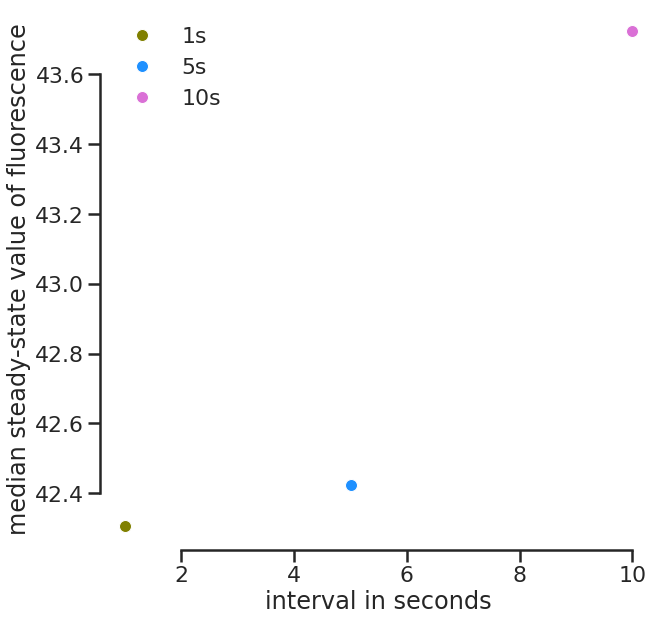

In [130]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))

plt.plot(1, np.median(medOne480[-10:]), 'o', mec='white', color=oneColor, label='1s')
plt.plot(5, np.median(medFive480[-10:]), 'o', mec='white', color=fiveColor, label='5s')
plt.plot(10, np.median(medTen480[-10:]), 'o', mec='white', color=tenColor, label='10s')
plt.xlabel('interval in seconds')
plt.ylabel('median steady-state value of fluorescence')

sns.despine(trim=True, ax=ax)

# # # fig, ax = plt.subplots(figsize=(10,10))
# plt.plot(medFive480, lw=5, alpha=1, color=fiveColor, label='5s')
# for ii in range(len(fiveSecIntervalFiles480)):
#     plt.plot(fiveSecIntervalFiles480[ii], alpha=0.5, color=fiveColor)
#     plt.text(200+2, fiveSecIntervalFiles480[ii][-1], 
#              withkeys_fiveSecIntervalFiles480[ii][-1][1]+'_rep'+str(withkeys_fiveSecIntervalFiles480[ii][-1][-1]),color=fiveColor, ha='left', va='center')
# sns.despine(trim=True, ax=ax)

# # # fig, ax = plt.subplots(figsize=(10,10))
# plt.plot(medTen480, lw=5, alpha=1, color=tenColor, label='10s')
# for ii in range(len(tenSecIntervalFiles480)):
#     plt.plot(tenSecIntervalFiles480[ii], alpha=0.5, color=tenColor)
#     plt.text(200+2, tenSecIntervalFiles480[ii][-1], 
#              withkeys_tenSecIntervalFiles480[ii][-1][1]+'_rep'+str(withkeys_tenSecIntervalFiles480[ii][-1][-1]),color=tenColor, ha='left', va='center')
# #ax.set_ylim([70,115])
# sns.despine(trim=True, ax=ax)

plt.legend(frameon=False)

## Fitting 

20250123 for now i will just look at fitting the 2024 data

In [190]:
tol=1e-7 #if you want to set a precision to the solver

def singExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1], where w1 is the weight of the exponential, 
        tau1 is the decay constant of the exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]

    return w1*np.exp(-times/tau1)
    
def singExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def singExpConst(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, Iinf], where w1 is the weight of the exponential,
        tau1 is the decay constant of the exponential and w2 is the limit of the intensity as you go to infinity
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]

    return w1*np.exp(-times/tau1)+w2
    
def singExpConstFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExpConst(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def doubExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2], where w1(w2) is the weight of the first(second) exponential, 
        tau1(tau2) is the decay constant of the first(second) exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    
def doubExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def tripExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2, w3, tau3], where w1(w2,w3) is the weight of the first(second, third) exponential, 
        tau1(tau2, tau3) is the decay constant of the first(second, third) exponential 
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]
    w3 = p0[4]
    tau3 = p0[5]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)+w3*np.exp(-times/tau3)
    
def tripExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-tripExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00430223414831107
        x: [ 1.641e-01  1.258e+00  8.357e-01]
      nit: 24
      jac: [ 0.000e+00 -5.821e-11 -3.667e-09]
 hess_inv: [[ 4.797e-01 -2.957e+00 -2.136e-03]
            [-2.957e+00  1.144e+02 -6.266e-02]
            [-2.136e-03 -6.266e-02  2.551e-03]]
     nfev: 146
     njev: 36

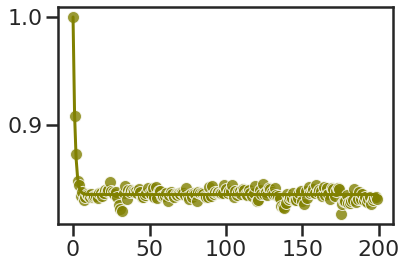

In [208]:
## Test fit - single exponential
times1=1*np.arange(len(medOne480))
times5=5*np.arange(len(medFive480))
times10=10*np.arange(len(medTen480))

plt.plot(times1, medOne480/medOne480.max(), 'o', lw=5, alpha=0.8, mec='white', color=oneColor, label='5s')
oneFit_sing= singExpConstFit(times1, medOne480/medOne480.max(), [0.15, 20,0.85])
plt.plot(times1, singExpConst(times1, oneFit_sing.x), ls='-', label='Single Exponential', color=oneColor)
oneFit_sing

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.00605310168004225
        x: [ 1.417e-01  7.753e+00  8.577e-01]
      nit: 22
      jac: [ 6.822e-08 -1.164e-10  1.738e-06]
 hess_inv: [[ 4.441e-01  1.153e-01  1.322e-02]
            [ 1.153e-01  3.067e+00  7.108e-03]
            [ 1.322e-02  7.108e-03  6.068e-03]]
     nfev: 302
     njev: 73

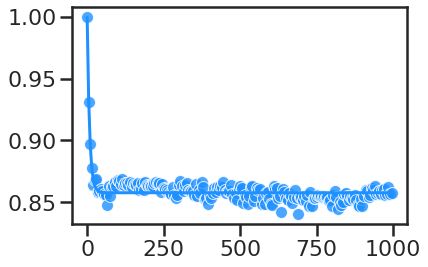

In [213]:
plt.plot(times5, medFive480/medFive480.max(), 'o', lw=5, alpha=0.8, mec='white', color=fiveColor, label='5s')
fiveFit_sing= singExpConstFit(times5, medFive480/medFive480.max(), [0.15, 20,0.85])
plt.plot(times5, singExpConst(times5, fiveFit_sing.x), ls='-', label='Single Exponential', color=fiveColor)
fiveFit_sing

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.004231101460310575
        x: [ 1.170e-01  1.348e+01  8.842e-01]
      nit: 27
      jac: [ 9.721e-08  2.328e-10  2.355e-06]
 hess_inv: [[ 4.470e-01 -3.248e+01 -3.266e-03]
            [-3.248e+01  1.903e+04  6.684e-02]
            [-3.266e-03  6.684e-02  2.658e-03]]
     nfev: 329
     njev: 79

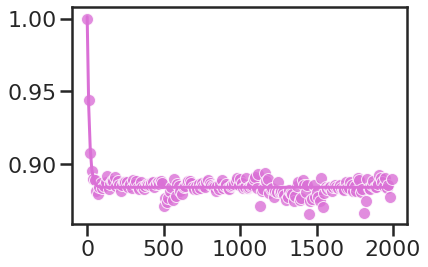

In [214]:
plt.plot(times10, medTen480/medTen480.max(), 'o', lw=5, alpha=0.8, mec='white', color=tenColor, label='5s')
tenFit_sing= singExpConstFit(times10, medTen480/medTen480.max(), [0.15, 200,0.85])
plt.plot(times10, singExpConst(times10, tenFit_sing.x), ls='-', label='Single Exponential', color=tenColor)
tenFit_sing

In [274]:
temparr = evenedResults24[(500, 2, '405')]
tempevenarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds

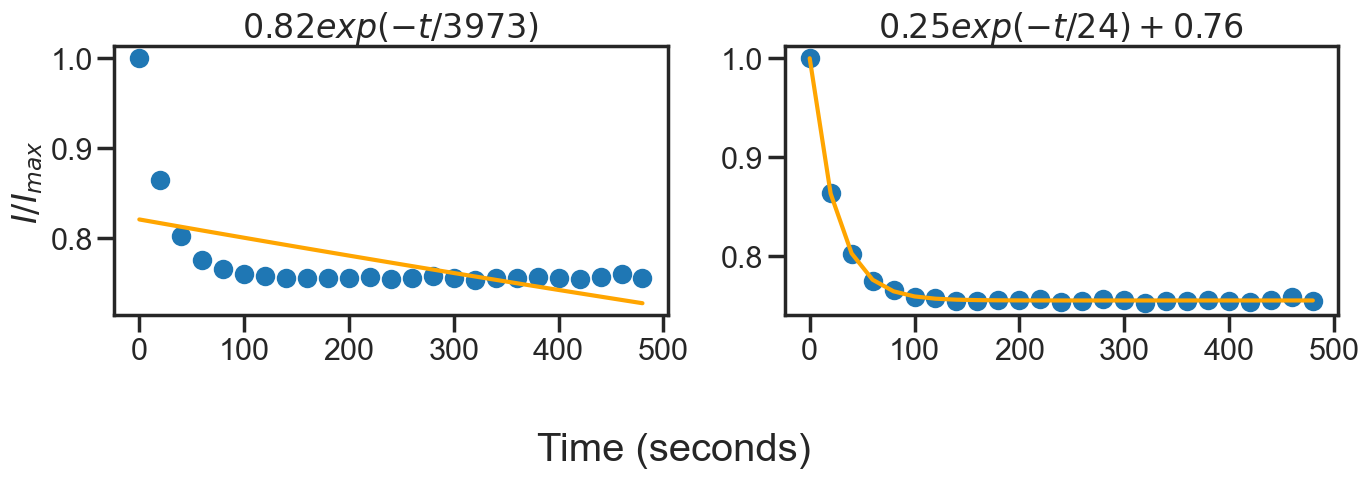

In [275]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

#Single Exponential
tempfit = singExpFit(temptimes, tempevenarr, [0.7, 2000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])
ax[0].scatter(temptimes, tempevenarr)
ax[0].plot(temptimes, singExp(temptimes, tempfit.x), ls='-', label='Single Exponential', color='orange')
ax[0].set_title(f'${round(tempfit.x[0],2)} exp({{-t/{round(tempfit.x[1])}}})$')#[round(p,2) for p in tempfit.x], fontsize=15)
#ax[0].set_title([round(p,2) for p in tempfit.x], fontsize=15)
#ax[0].legend(fontsize=10)
#print('single exp')
#print(tempfit)

#Single Exponential + Constant
tempfit = singExpConstFit(temptimes, tempevenarr, [0.2, 25, 0.8])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])
ax[1].scatter(temptimes, tempevenarr)
ax[1].plot(temptimes, singExpConst(temptimes, tempfit.x), ls='-',label='Single+Constnat Exponential', color='orange')
#ax[1].set_title([round(p,2) for p in tempfit.x], fontsize=15)
ax[1].set_title(f'${round(tempfit.x[0],2)} exp({{-t/{round(tempfit.x[1])}}})+{round(tempfit.x[2],2)}$')

#ax[1].legend(fontsize=10)
#print('\n single exp + const')
#print(tempfit)

# #Double Exponential
# tempfit = doubExpFit(temptimes, tempevenarr, [0.2, 25, 0.8, 10000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])
# ax[2].scatter(temptimes, tempevenarr)
# ax[2].plot(temptimes, doubExp(temptimes, tempfit.x), ls='-', label='Double Exponential', color='orange')
# #ax[2].set_title([round(p,2) for p in tempfit.x], fontsize=15)
# ax[2].set_title(f'${round(tempfit.x[0],2)} exp({{-t/{round(tempfit.x[1])}}})+{round(tempfit.x[2],2)} exp({{-t/{round(tempfit.x[3])}}})$')
# #ax[2].legend(fontsize=10)
# #print('\n double exp')
# #print(tempfit)

# #Triple Exponential
# tempfit = tripExpFit(temptimes, tempevenarr, [0.2, 25, 0.5, 1e4, 0.3, 1e7])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])
# ax[3].scatter(temptimes, tempevenarr)
# ax[3].plot(temptimes, tripExp(temptimes, tempfit.x), ls='--', label='Triple Exponential', color='orange')
# ax[3].legend(fontsize=10)
# ax[3].set_title([round(p,2) for p in tempfit.x], fontsize=15)#(100, 0.9, [round(p,2) for p in tempfit.x], fontsize=20)
# print('\n triple exp ')
# print(tempfit)

ax[0].set_ylabel(f'$I/I_{{max}}$')
fig.supxlabel('Time (seconds)')
plt.tight_layout()
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126multiFits.pdf')

In [329]:
np.sum((tempevenarr-singExpConst(temptimes, tempfit_spc.x)**2))

4.323119418164125

#### fit tau 2 based on single exponential+constant

In [276]:
#--------------------------------------------------------------------#
def doubExpT2(times, fixed_params, tau2):
    """
    times: array of time points
    fixed_params: parameters for [w1, tau1, w2]
    tau2: initial parameter value guess for the decay constant of the second exponential 
    """
    w1 = fixed_params[0]
    tau1 = fixed_params[1]
    w2 = fixed_params[2]
   
    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    
def doubExpT2Fit(times, fixed_params, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExpT2(times, fixed_params, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

In [277]:
#Single Exponential + Constant
tempfit_spc = singExpConstFit(temptimes, tempevenarr, [0.2, 25, 0.8])
tempfit_spc.x

array([ 0.24500649, 24.42532402,  0.75523681])

In [310]:
2%3

2

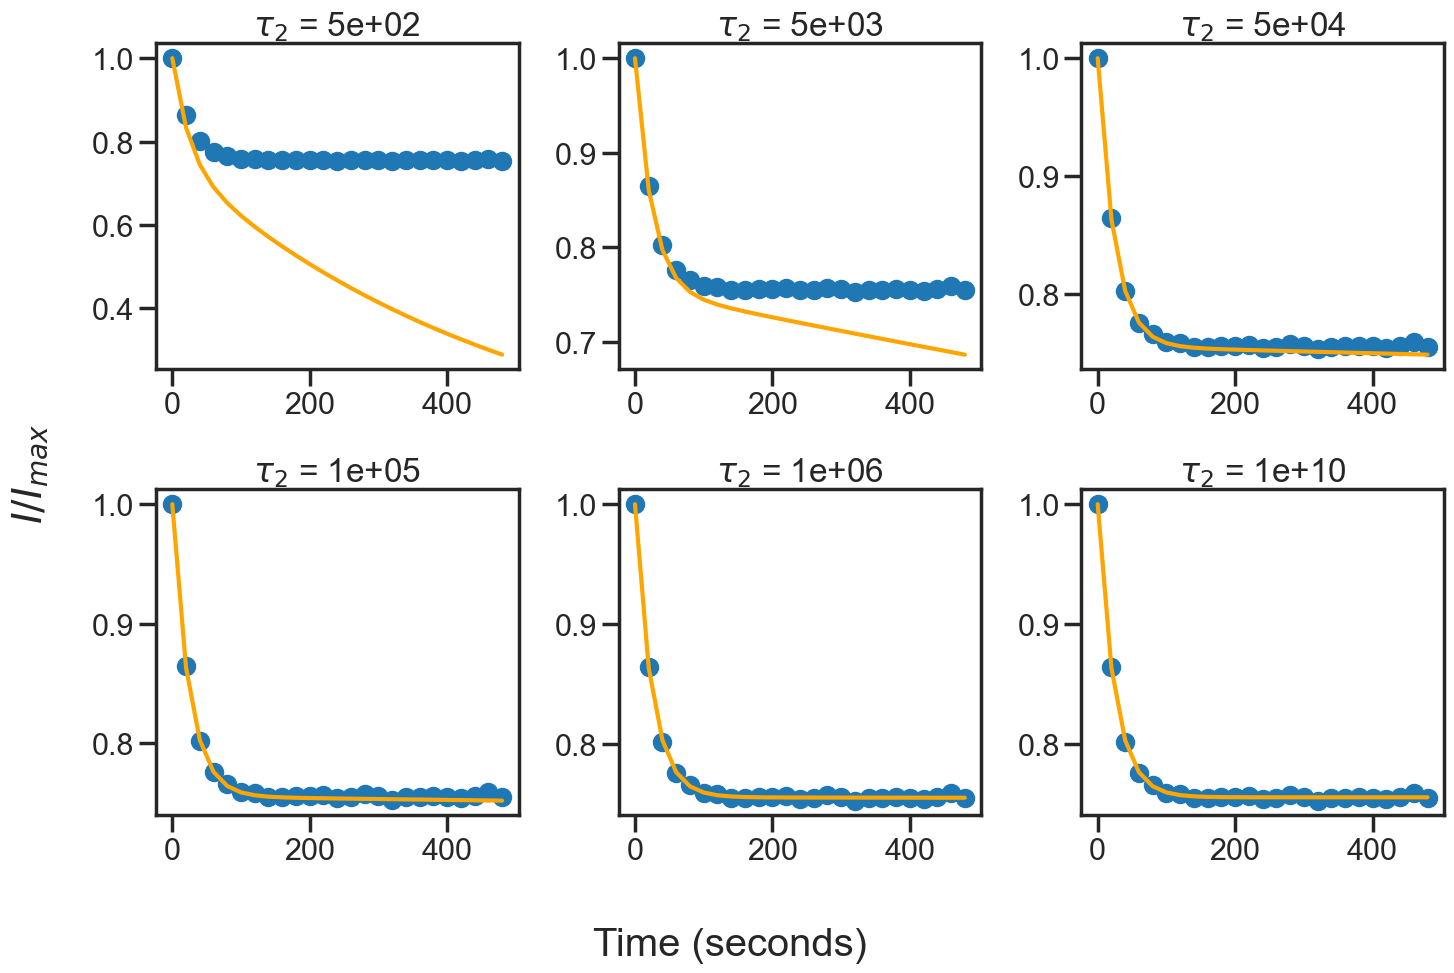

In [327]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
tau2 = [5e2, 5e3, 5e4, 1e5, 1e6, 1e10]
for i in range(6):
    ax[int(i/3)][i%3].scatter(temptimes, tempevenarr)
    ax[int(i/3)][i%3].plot(temptimes, doubExpT2(temptimes, tempfit_spc.x, tau2=tau2[i]), ls='-', label='Double Exponential', color='orange')
    ax[int(i/3)][i%3].set_title(r'$\tau_2$ = '+"{:.0e}".format(tau2[i]))#str(round(tau2[i])))
fig.supylabel(f'$I/I_{{max}}$')
fig.supxlabel('Time (seconds)')
plt.tight_layout()

#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126rangeT2.pdf')

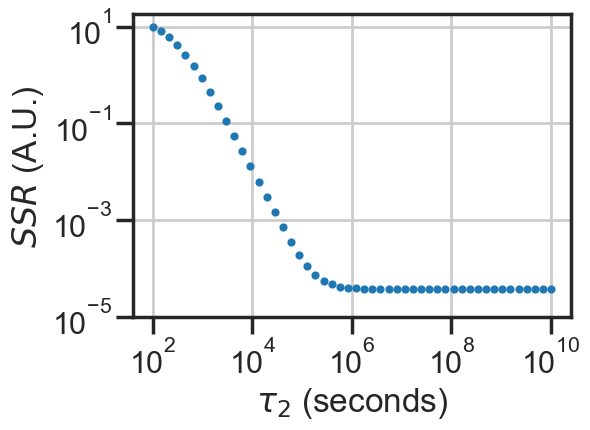

In [282]:
tau2array = np.logspace(2, 10, num=50)
plt.scatter(tau2array, [np.sum((tempevenarr-doubExpT2(temptimes, tempfit_spc.x, tau2=tau2))**2) for tau2 in tau2array], s=15)
plt.xscale('log')
plt.yscale('log')
plt.xticks(np.logspace(2, 10, num=5))
plt.yticks(np.logspace(1, -5, num=4))
plt.grid()
plt.xlabel(r'$\tau_2$ (seconds)')
plt.ylabel(r'$SSR$ (A.U.)')
plt.tight_layout()
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126minimizeT2.pdf')

### Fit to a double exponential

In [168]:
#fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time() # to keep track of runtime
doubExpFitResults={} #store results of fit
maxVals = {} #store array maximums
for a, atp in enumerate(ATPconcs24): 
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            plotarr = evenedResults24[(atp, pos, colname)]
            maxVals[atp, pos, colname] = plotarr.max() #store maximums
            plottimes = np.arange(len(plotarr))*20 #seconds 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            fit = doubExpFit(plottimes, plotnormarr, (plotnormarr.max()-plotnormarr.min(), 25, plotnormarr.min(), 100000))
            doubExpFitResults[atp, pos, colname] = fit
            
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs24)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
    
    
    

100%, time elapsed: 0 seconds 

In [169]:
np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if '405' in k])

array([100000.0000172 , 100000.00002065, 100000.00001447, 100000.00000156,
       100000.00001363, 100000.00000787, 100000.00000681, 100000.00000966,
       100000.00001888, 100000.00001043, 100000.0000029 , 100000.00000106,
       100000.000006  , 100000.00000516, 100000.00000726, 100000.00001919,
       100000.00001514, 100000.00001374, 100000.00002988, 100000.00001621,
       100000.00001554, 100000.00001622, 100000.0000221 , 100000.00005954,
       100000.00004633, 100000.00000992, 100000.0000251 , 100000.00000763,
       100000.00000397, 100000.00000608,  99999.99999308,  99999.99999492,
        99999.99999119])

Text(0.5, 0, 'time')

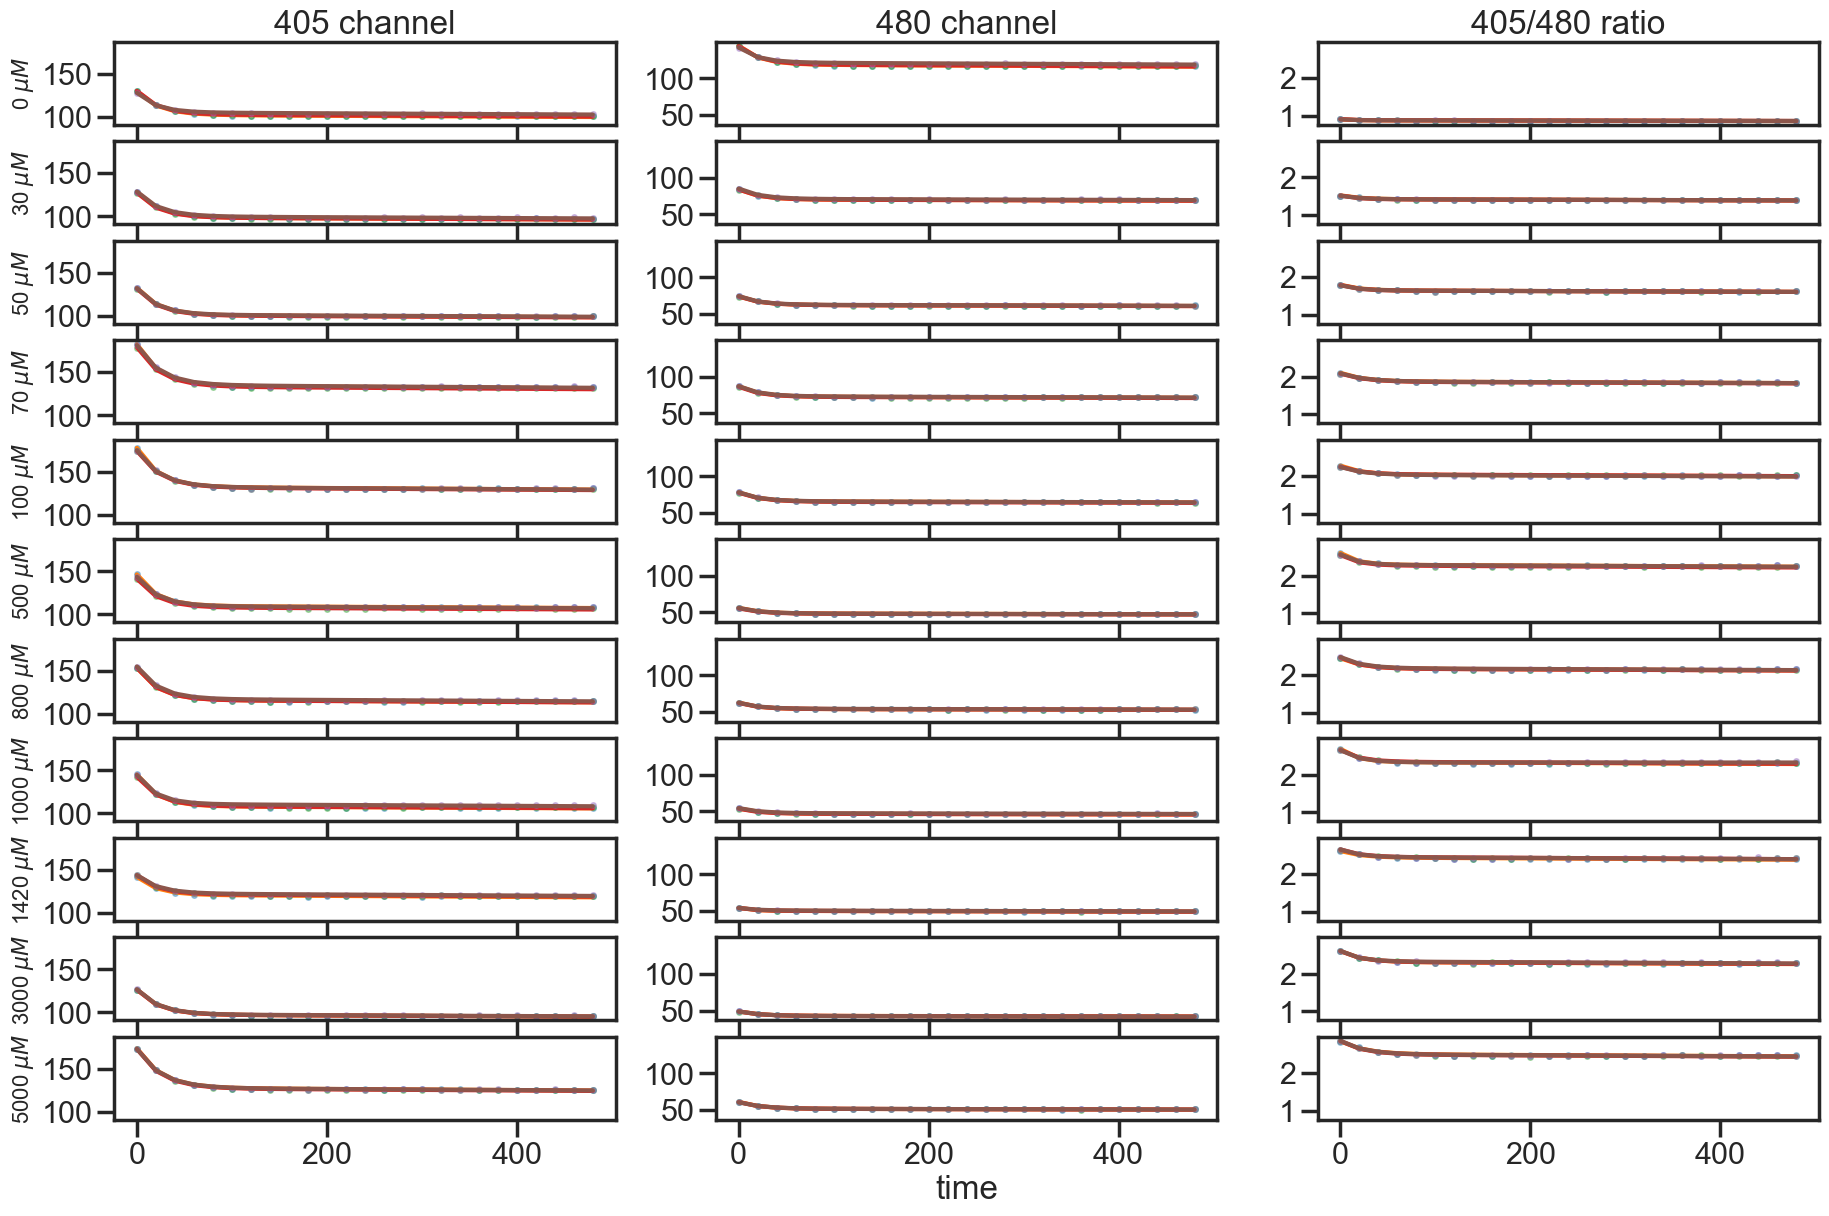

In [160]:
fig, ax = plt.subplots(len(ATPconcs24),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs24): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr, 'o', ms=4, alpha=0.4) 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, doubExp(plottimes, doubExpFitResults[atp, pos, colname].x)*plotarr.max())
           
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Text(0.5, 0, 'time')

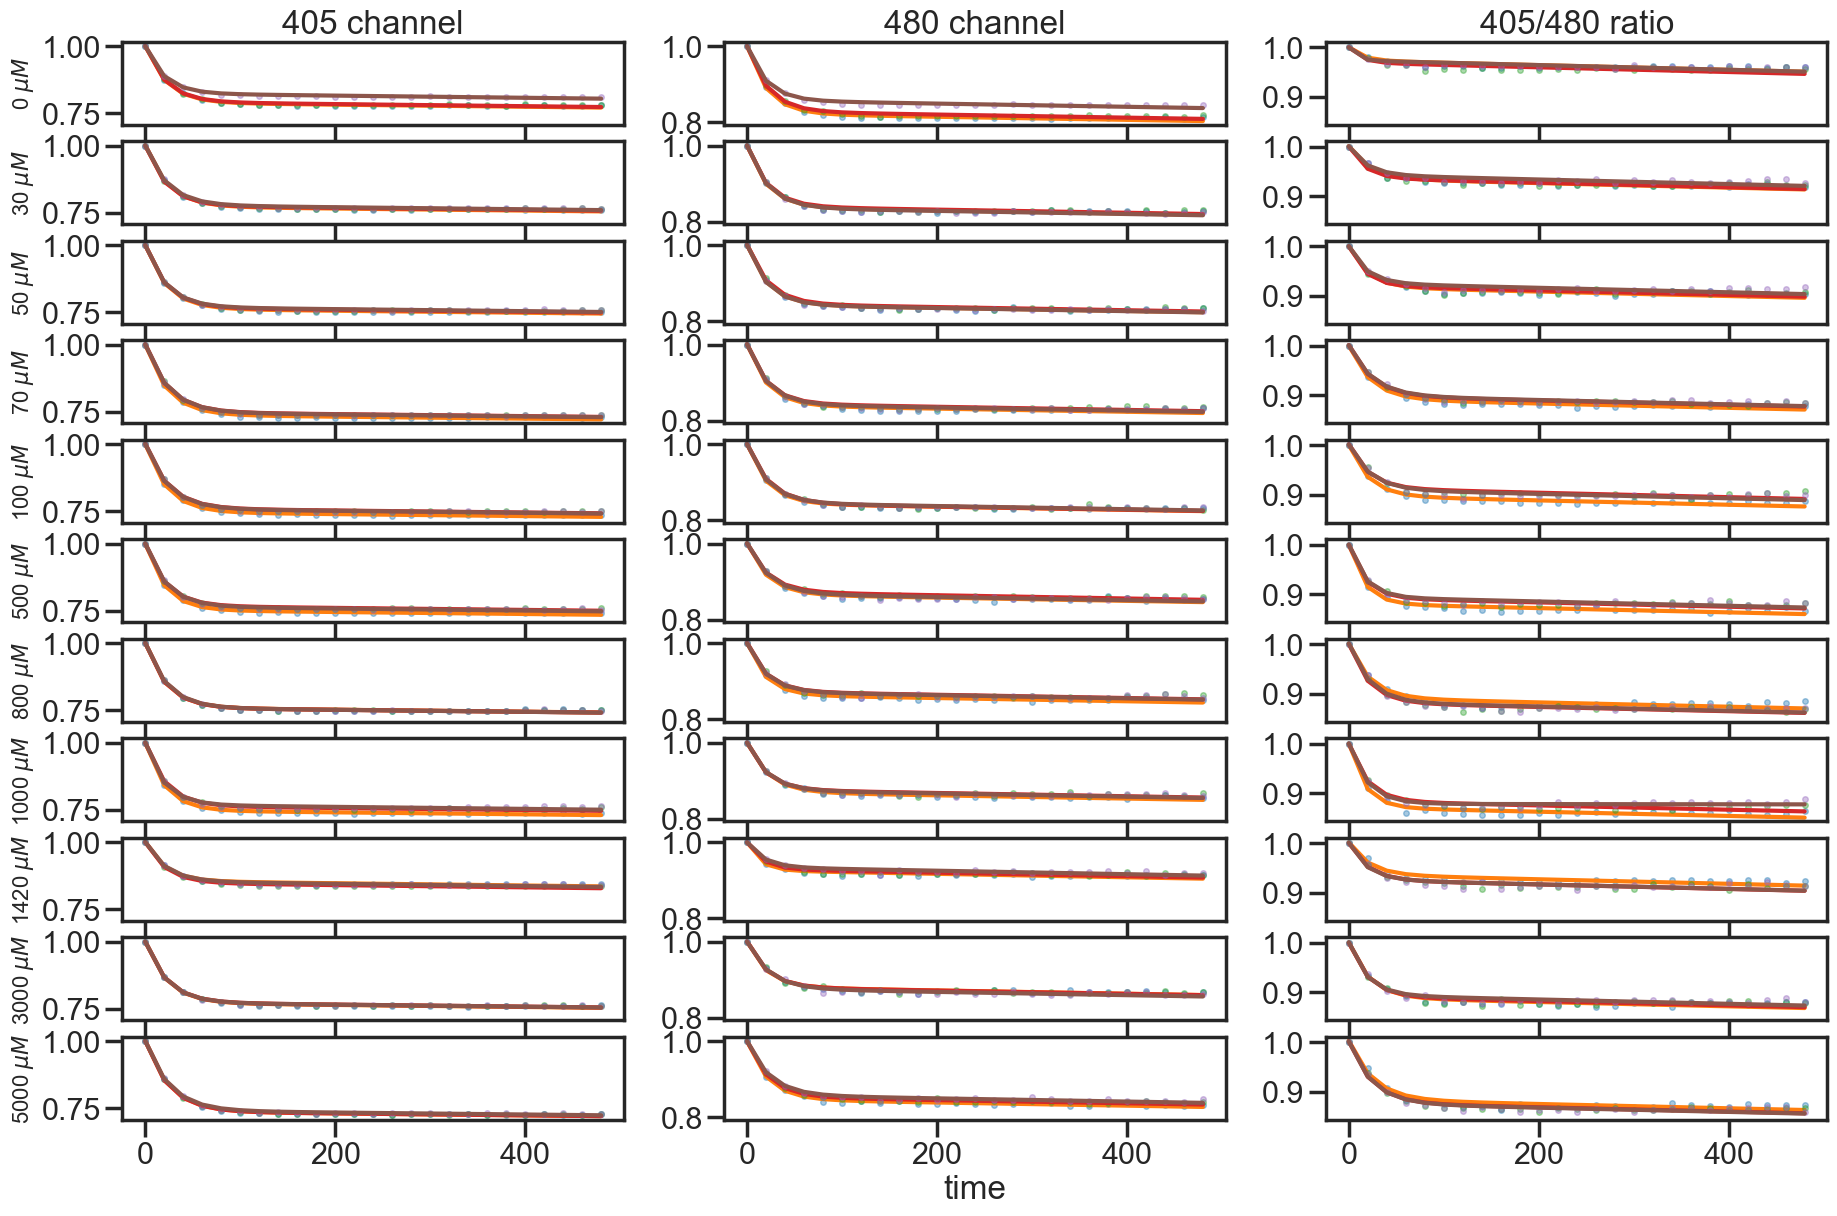

In [161]:
fig, ax = plt.subplots(len(ATPconcs24),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs24): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, plotnormarr, 'o', ms=4, alpha=0.4) 

        
            ax[a][col].plot(plottimes, doubExp(plottimes, doubExpFitResults[atp, pos, colname].x))
           
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

In [165]:
np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if '405' in k])

array([20000.00171559, 20000.00175222, 20000.0024358 , 20000.00109654,
       20000.00143109, 20000.00128792, 20000.00116993, 20000.00130572,
       20000.00141246, 20000.00098591, 20000.0008976 , 20000.00086214,
       20000.00097727, 20000.00105354, 20000.0011269 , 20000.00133067,
       20000.00143758, 20000.00133419, 20000.00148583, 20000.00129829,
       20000.00131565, 20000.00124244, 20000.00155974, 20000.00231679,
       20000.00401623, 20000.00311069, 20000.00365472, 20000.00126328,
       20000.00118681, 20000.00121232, 20000.00056463, 20000.0006172 ,
       20000.0005766 ])

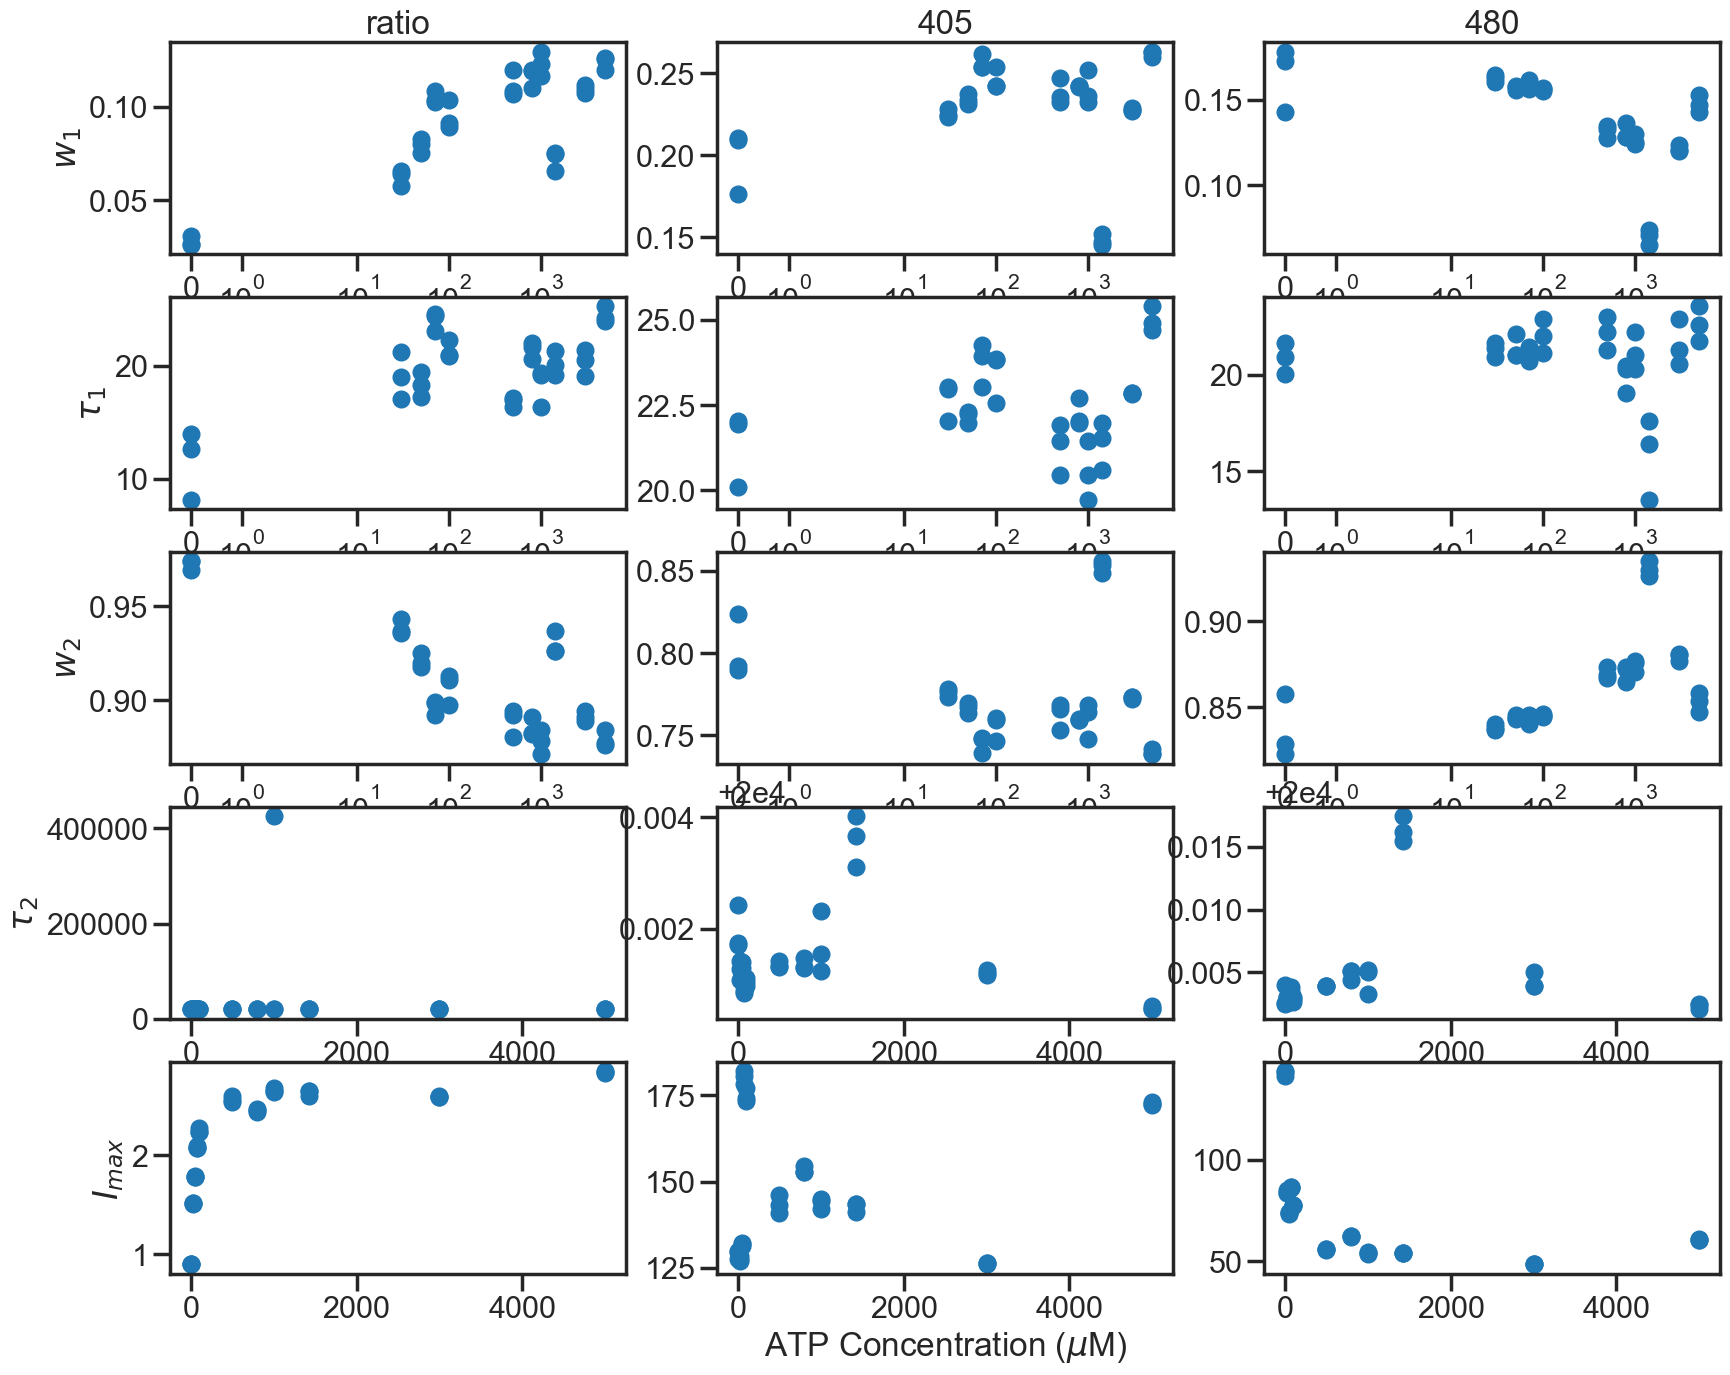

In [164]:
fig, ax = plt.subplots(5,3, figsize = (20, 16))

ax[0][0].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[0] for k in doubExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[0][1].plot(np.repeat(ATPconcs24,3), np.array([doubExpFitResults[k].x[0] for k in doubExpFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[0][2].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[0] for k in doubExpFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[0][0].set_ylabel(r'$w_1$')

ax[0][0].set_title('ratio')
ax[0][1].set_title('405')
ax[0][2].set_title('480')


ax[1][0].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[1] for k in doubExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[1][1].plot(np.repeat(ATPconcs24,3), np.array([doubExpFitResults[k].x[1] for k in doubExpFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[1][2].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[1] for k in doubExpFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[1][0].set_ylabel(r'$\tau_1$')

ax[2][0].plot(np.repeat(ATPconcs24,3), np.array([doubExpFitResults[k].x[2] for k in doubExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[2][1].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[2] for k in doubExpFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[2][2].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[2] for k in doubExpFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[2][0].set_ylabel(r'$w_2$')

ax[3][0].plot(np.repeat(ATPconcs24,3), np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[3][1].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[3][2].plot(np.repeat(ATPconcs24,3),  np.array([doubExpFitResults[k].x[3] for k in doubExpFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[3][0].set_ylabel(r'$\tau_2$')

ax[4][0].plot(np.repeat(ATPconcs24,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]), 'o-', label='ratio', lw=0)
ax[4][1].plot(np.repeat(ATPconcs24,3),  np.array([maxVals[k] for k in maxVals.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[4][2].plot(np.repeat(ATPconcs24,3),  np.array([maxVals[k] for k in maxVals.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[4][0].set_ylabel(r'$I_{max}$')


ax[4][1].set_xlabel(r'ATP Concentration ($\mu$M)')

for i in range(3):
    for j in range(3):
        ax[i][j].set_xscale('symlog')

### Do the Fit to single exponential + const and store max vals

In [154]:
#fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time() # to keep track of runtime
singExpConstFitResults={} #store results of fit
maxVals = {} #store array maximums
for a, atp in enumerate(ATPconcs24): 
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            plotarr = evenedResults24[(atp, pos, colname)]
            maxVals[atp, pos, colname] = plotarr.max() #store maximums
            plottimes = np.arange(len(plotarr))*20 #seconds 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            fit = singExpConstFit(plottimes, plotnormarr, (plotnormarr.max()-plotnormarr.min(), 25, plotnormarr.min()))
            singExpConstFitResults[atp, pos, colname] = fit
            
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs24)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
    
    
    

100%, time elapsed: 0 seconds 

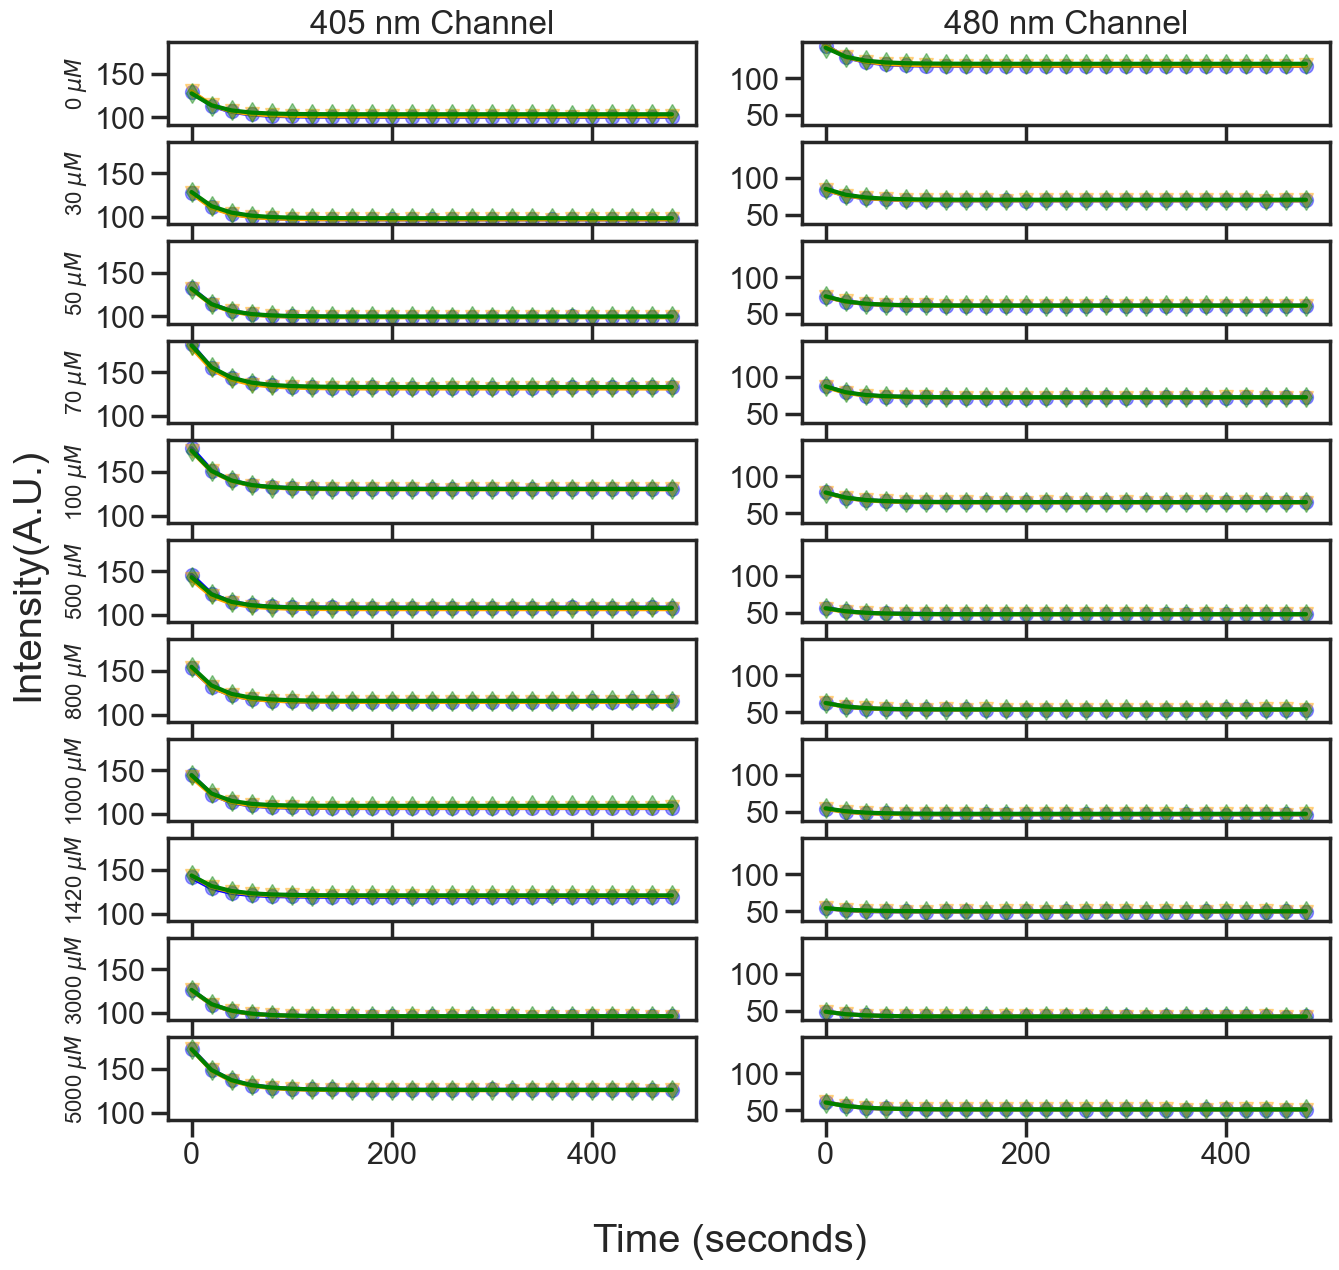

In [344]:
fig, ax = plt.subplots(len(ATPconcs24),2, figsize=(15,14), sharey='col')
markers = ['o', 'v','d']
linecolors = ['b', 'orange', 'g']
for a, atp in enumerate(ATPconcs24): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480']): #, 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr, marker=markers[pos], ms=10, alpha=0.4, lw=0, color=linecolors[pos]) 

            #fit the intensity values to a decaying exponential
            #if col<2:
            #normalize the intensity values
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, singExpConst(plottimes, singExpConstFitResults[atp, pos, colname].x)*plotarr.max(), color=linecolors[pos])
           
ax[0][0].set_title('405 nm Channel')
ax[0][1].set_title('480 nm Channel')
# ax[0][2].set_title('405/480 ratio')
fig.supxlabel('Time (seconds)')
fig.supylabel('Intensity(A.U.)')
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126FittedSingConst.pdf')

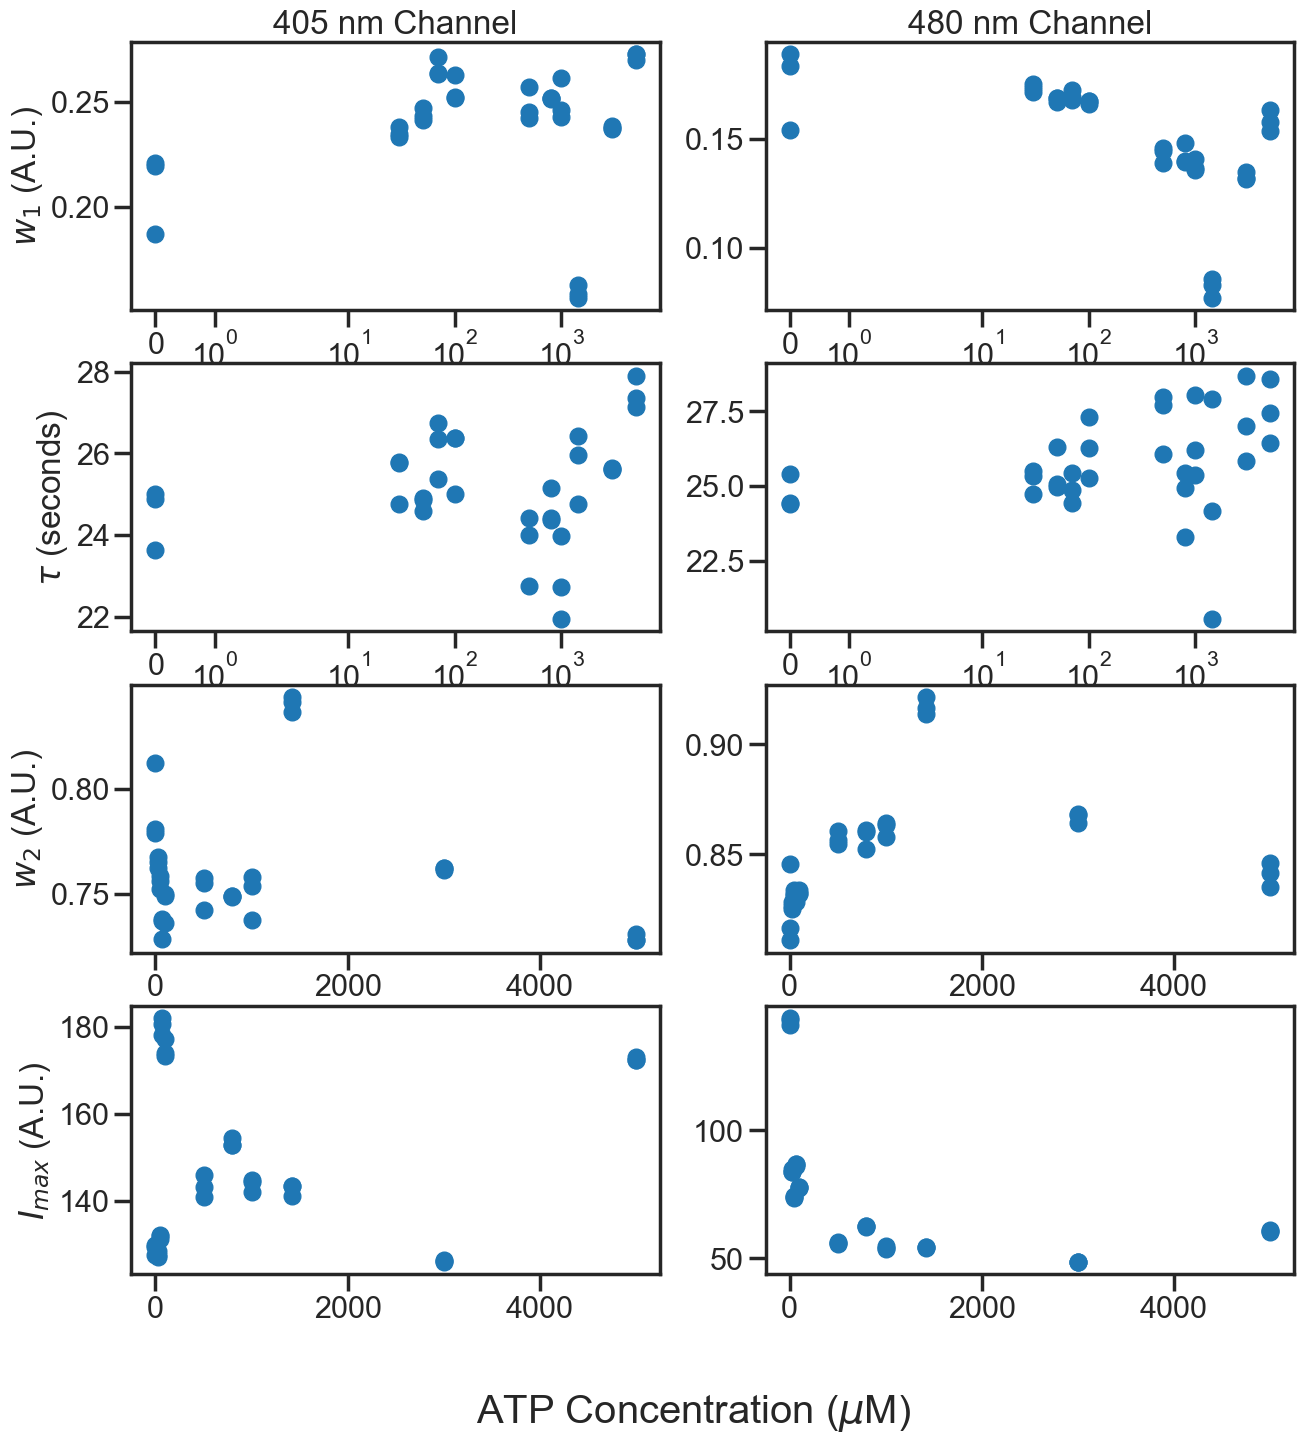

In [351]:
fig, ax = plt.subplots(4,2, figsize = (15, 16))

#ax[0][0].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[0] for k in singExpConstFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[0][0].plot(np.repeat(ATPconcs24,3), np.array([singExpConstFitResults[k].x[0] for k in singExpConstFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[0][1].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[0] for k in singExpConstFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[0][0].set_ylabel('$w_1$ (A.U.)')

#ax[0][0].set_title('ratio')
ax[0][0].set_title('405 nm Channel')
ax[0][1].set_title('480 nm Channel')


#ax[1][0].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[1] for k in singExpConstFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1][0].plot(np.repeat(ATPconcs24,3), np.array([singExpConstFitResults[k].x[1] for k in singExpConstFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[1][1].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[1] for k in singExpConstFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[1][0].set_ylabel(r'$\tau$ (seconds)')

#ax[2][0].plot(np.repeat(ATPconcs24,3), np.array([singExpConstFitResults[k].x[2] for k in singExpConstFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[2][0].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[2] for k in singExpConstFitResults.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[2][1].plot(np.repeat(ATPconcs24,3),  np.array([singExpConstFitResults[k].x[2] for k in singExpConstFitResults.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[2][0].set_ylabel(r'$w_2$ (A.U.)')

#ax[3][0].plot(np.repeat(ATPconcs24,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[3][0].plot(np.repeat(ATPconcs24,3),  np.array([maxVals[k] for k in maxVals.keys() if '405' in k]), 'o-', label='405', lw=0)
ax[3][1].plot(np.repeat(ATPconcs24,3),  np.array([maxVals[k] for k in maxVals.keys() if '480' in k]), 'o-', label='480', lw=0) 
ax[3][0].set_ylabel(r'$I_{max}$ (A.U.)')

fig.supxlabel(r'ATP Concentration ($\mu$M)')

for i in range(2):
    for j in range(2):
        ax[i][j].set_xscale('symlog')
        
#plt.savefig('../../analyzed_data/atp_cal/ATP_Calibration_Dec2024/ATP_Calibration_Dec2024-20250126paramVsATP.pdf')

Text(0.5, 0, 'time')

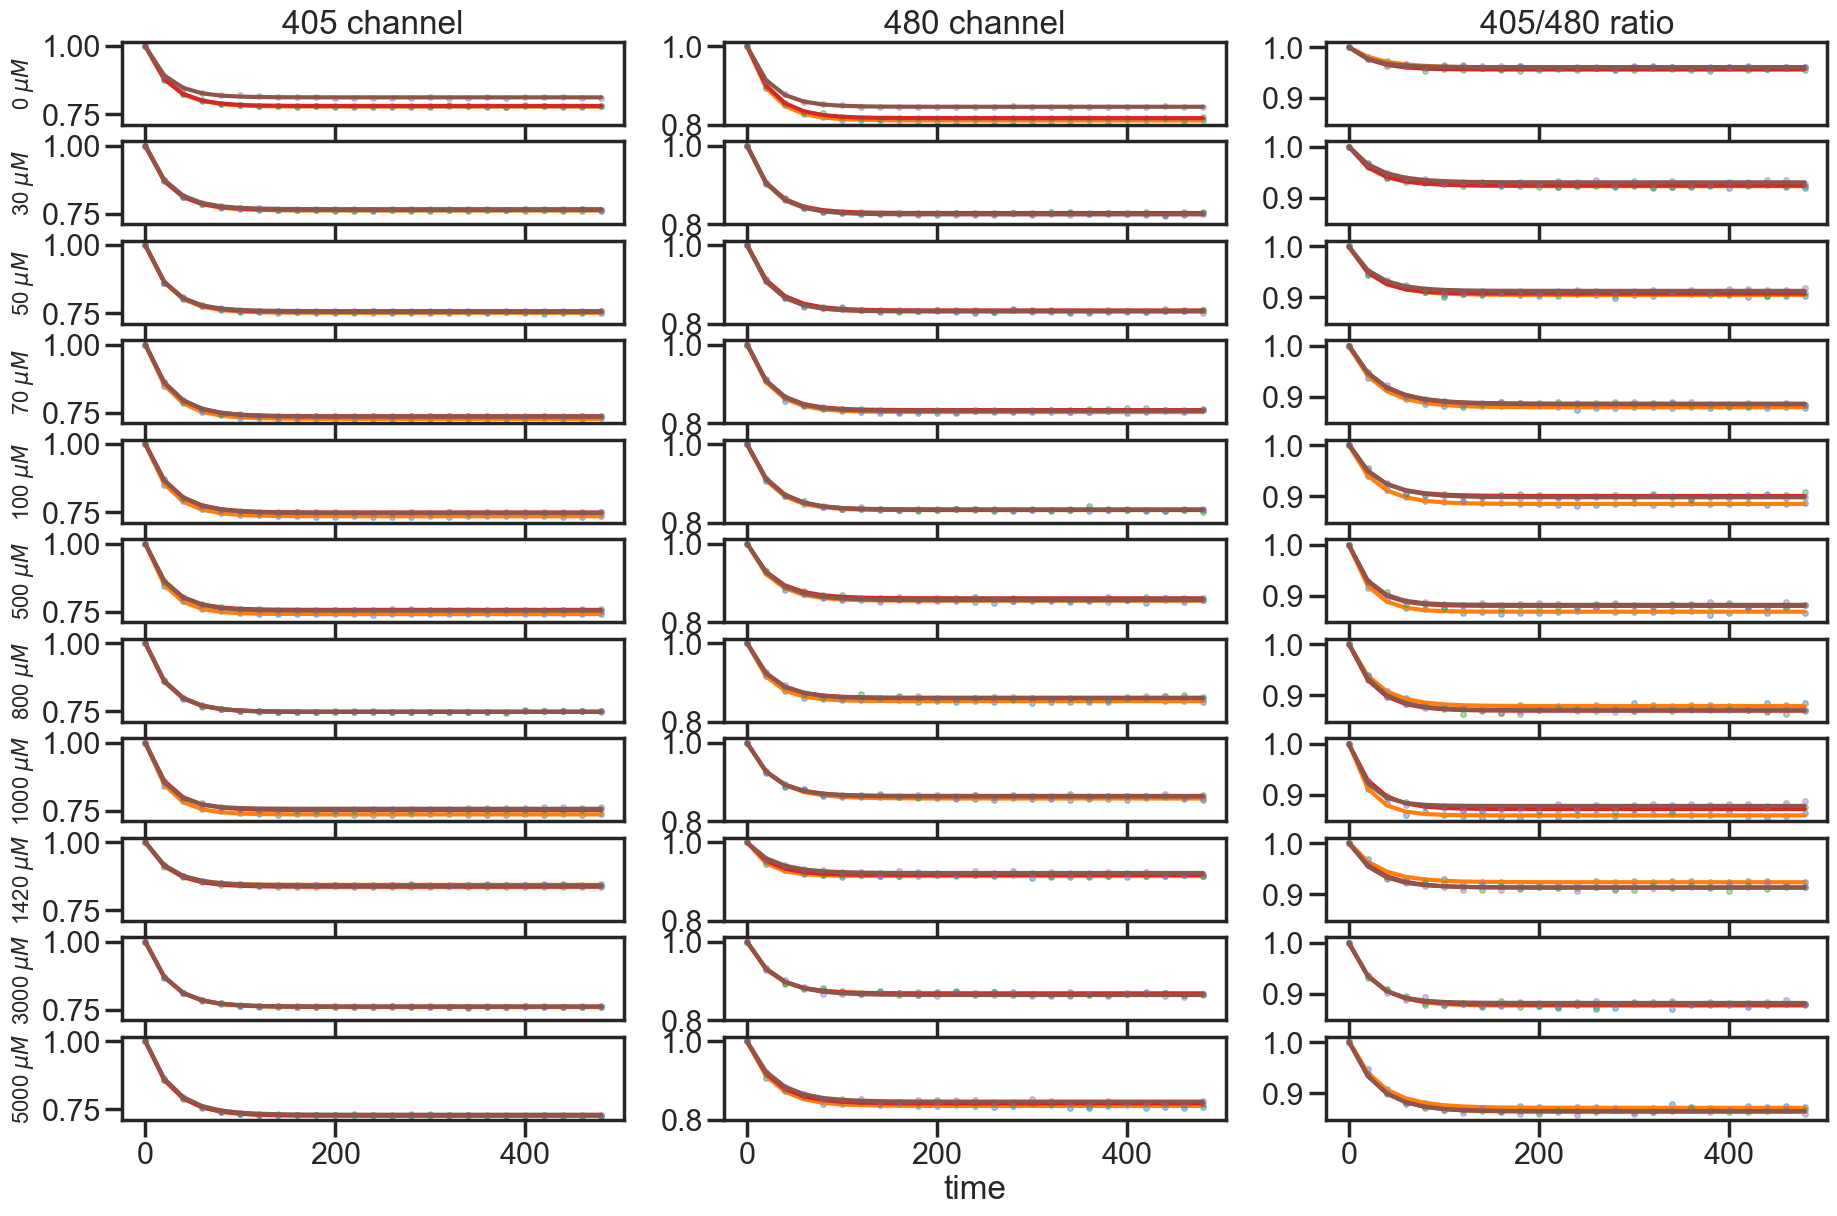

In [156]:
fig, ax = plt.subplots(len(ATPconcs24),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs24): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            plotnormarr = plotarr/plotarr.max()
            ax[a][col].plot(plottimes, plotnormarr, 'o', ms=4, alpha=0.4) 

        
            ax[a][col].plot(plottimes, singExpConst(plottimes, singExpConstFitResults[atp, pos, colname].x))
           
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

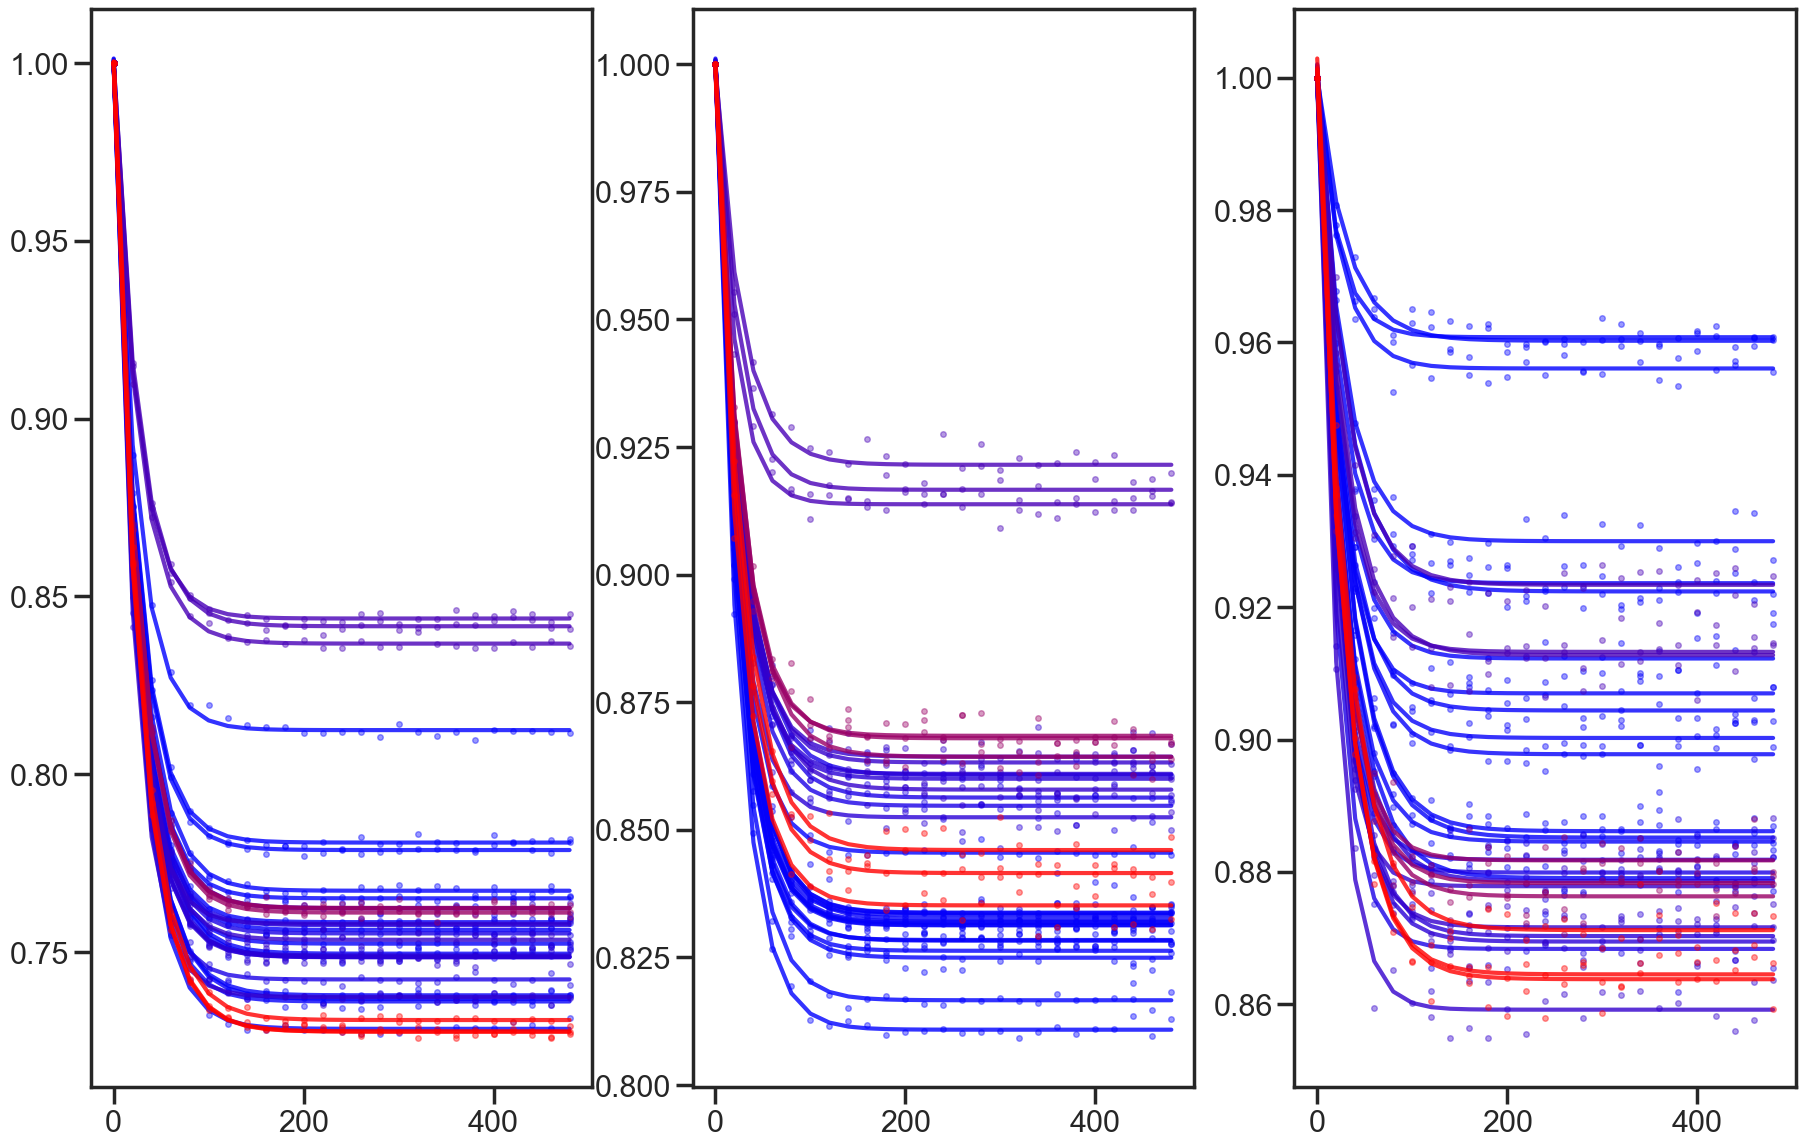

In [157]:
fig, ax = plt.subplots(1,3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs24): 
    for pos in range(3): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults24[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            plotnormarr = plotarr/plotarr.max()
            ax[col].plot(plottimes, plotnormarr, 'o', ms=4, alpha=0.4, color=(atp/ATPconcs24.max(), 0, 1-atp/ATPconcs24.max(), 0.8)) 

        
            ax[col].plot(plottimes, singExpConst(plottimes, singExpConstFitResults[atp, pos, colname].x), color=(atp/ATPconcs24.max(), 0, 1-atp/ATPconcs24.max(), 0.8))
           
# ax[0][0].set_title('405 channel')
# ax[0][1].set_title('480 channel')
# ax[0][2].set_title('405/480 ratio')
# ax[-1][1].set_xlabel('time')

In [48]:
w1For405 =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '405' in k])
tauFor405=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '405' in k])
intFor405=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k])

w1For480 =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '480' in k])
tauFor480=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '480' in k])
intFor480=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k])

w1Forratio =np.median([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if 'ratio' in k])
tauForratio=np.median([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if 'ratio' in k])
intForratio=np.median([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k])

print(w1For405, tauFor405, intFor405)
print(w1For480, tauFor480, intFor480)
print(w1Forratio, tauForratio, intForratio)


0.24501234599103164 24.99999754107892 0.7552375357777457
0.15380049578055022 25.000003237233877 0.8453946803458241
0.11520954424900257 26.857834854297625 0.88457730184607


In [49]:
k=list(singExpFitResults.keys())[-1]
np.sqrt(np.diag(singExpFitResults[k].hess_inv))

array([7.00735563e-01, 2.97794537e+02, 1.60159766e-01])

In [106]:
k

(np.int64(5000), 0, 'ratio')

In [107]:
singExpFitResults[k].hess_inv

array([[ 4.95743866e-01, -6.52070247e+01, -1.94813429e-02],
       [-6.52070247e+01,  8.45664739e+04, -1.68917040e+01],
       [-1.94813429e-02, -1.68917040e+01,  2.57591440e-02]])

In [111]:
### Grab fit parameter uncertainty
unc_w1Forratio =[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[0] for k in singExpFitResults.keys() if 'ratio' in k]
unc_tauForratio=[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[1] for k in singExpFitResults.keys() if 'ratio' in k]
unc_intForratio=[np.sqrt(np.diag(singExpFitResults[k].hess_inv))[-1] for k in singExpFitResults.keys() if 'ratio' in k]
#unc_tauForratio
unc_intForratio

[np.float64(0.15911570462063357),
 np.float64(0.15881599646686606),
 np.float64(0.15926975287717837),
 np.float64(0.16145441724086176),
 np.float64(0.15830565301176872),
 np.float64(0.15819791835076655),
 np.float64(0.1579910418184234),
 np.float64(0.1570166360156736),
 np.float64(0.1612510823221165),
 np.float64(0.15923997954917685),
 np.float64(0.16049655443813718)]

In [113]:
singExpFitResults[k].x[-1]

np.float64(0.8637799856019528)

In [53]:
np.repeat(ATPconcs,3)

array([   0,    0,    0,   30,   30,   30,   50,   50,   50,   70,   70,
         70,  100,  100,  100,  500,  500,  500,  800,  800,  800, 1000,
       1000, 1000, 1420, 1420, 1420, 3000, 3000, 3000, 5000, 5000, 5000])

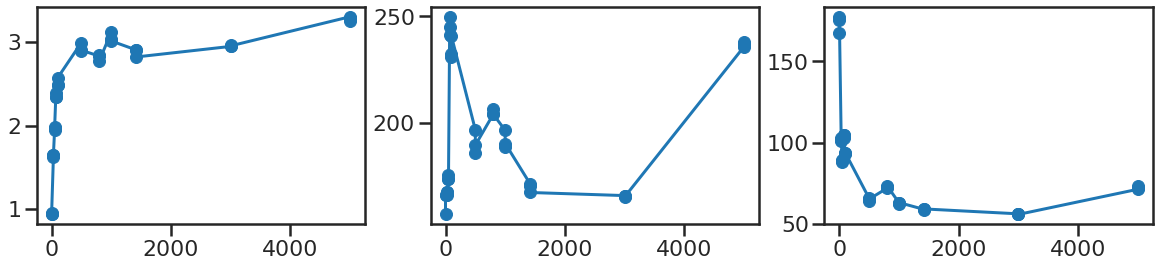

In [54]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) / np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 


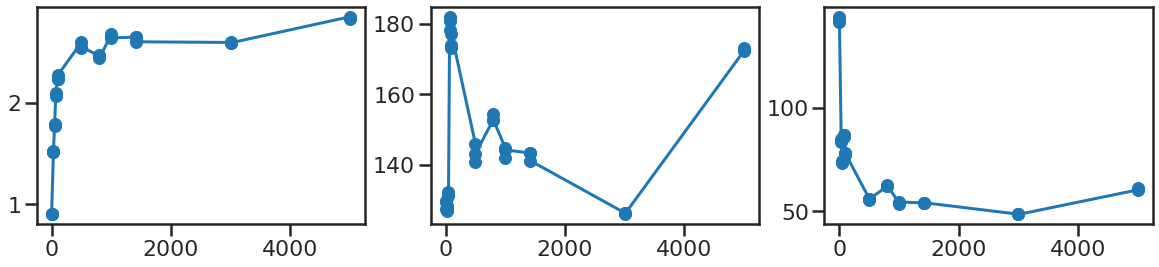

In [56]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) , 'o-',label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) , 'o-',label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) , 'o-', label='480') 


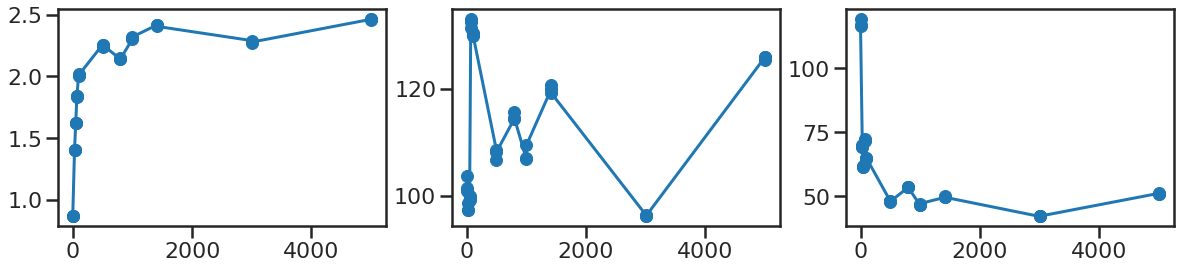

In [57]:
fig, ax = plt.subplots(1,3, figsize = (20, 4))
ax[0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '405' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if '480' in k]) * np.array([singExpFitResults[k].x[-1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 


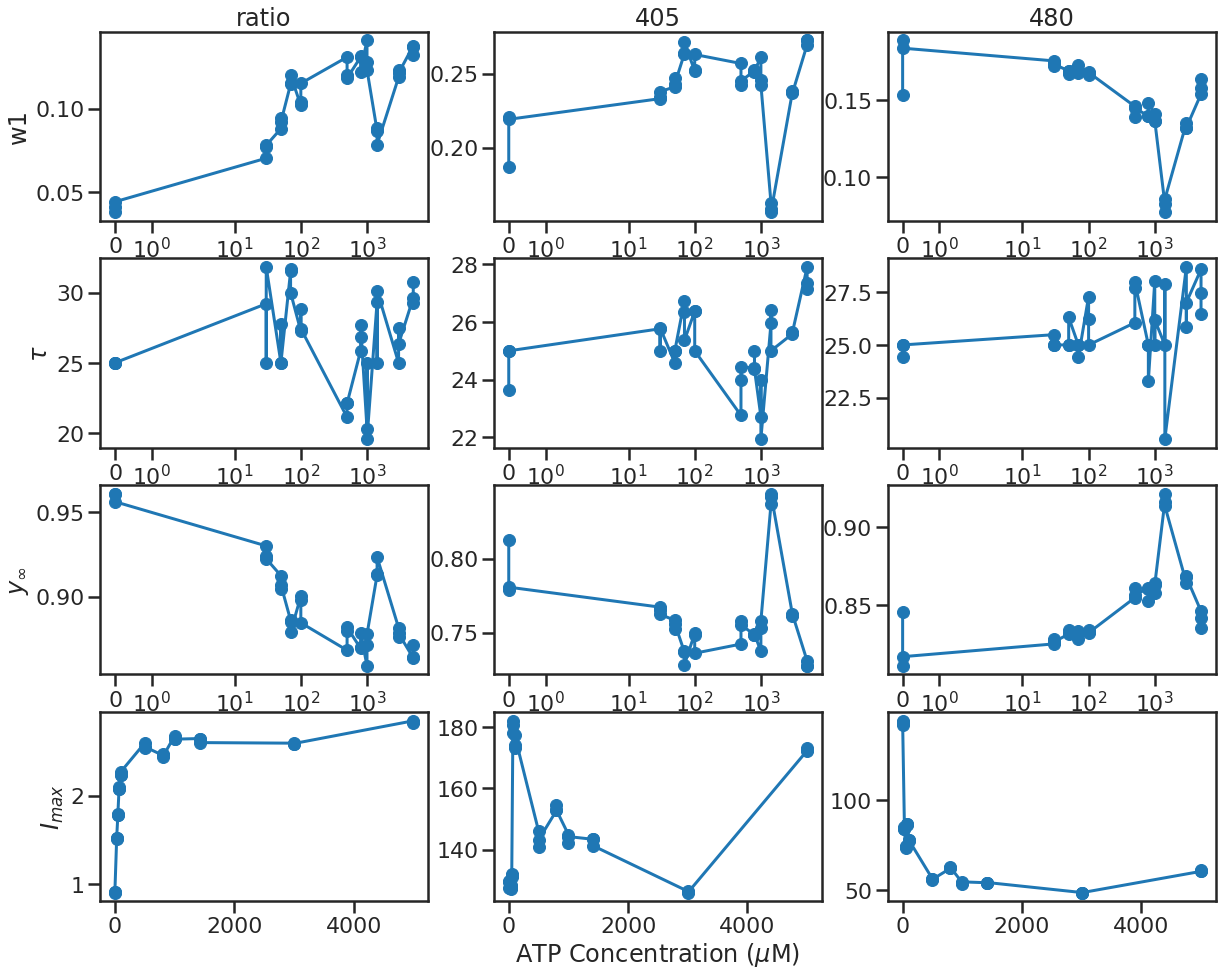

In [75]:
fig, ax = plt.subplots(4,3, figsize = (20, 16))

ax[0][0].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[0][1].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[0][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[0] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[0][0].set_ylabel('w1')

ax[0][0].set_title('ratio')
ax[0][1].set_title('405')
ax[0][2].set_title('480')


ax[1][0].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[1][1].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[1][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[1] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[1][0].set_ylabel(r'$\tau$')

ax[2][0].plot(np.repeat(ATPconcs,3), np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[2][1].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if '405' in k]), 'o-', label='405')
ax[2][2].plot(np.repeat(ATPconcs,3),  np.array([singExpFitResults[k].x[2] for k in singExpFitResults.keys() if '480' in k]), 'o-', label='480') 
ax[2][0].set_ylabel(r'$y_\infty$')

ax[3][0].plot(np.repeat(ATPconcs,3), np.array([maxVals[k] for k in maxVals.keys() if 'ratio' in k]), 'o-', label='ratio')
ax[3][1].plot(np.repeat(ATPconcs,3),  np.array([maxVals[k] for k in maxVals.keys() if '405' in k]), 'o-', label='405')
ax[3][2].plot(np.repeat(ATPconcs,3),  np.array([maxVals[k] for k in maxVals.keys() if '480' in k]), 'o-', label='480') 
ax[3][0].set_ylabel(r'$I_{max}$')
ax[3][1].set_xlabel(r'ATP Concentration ($\mu$M)')

for i in range(3):
    for j in range(3):
        ax[i][j].set_xscale('symlog')

In [93]:
evenedResults[5000, 0, 'ratio'].max()/singExpFitResults[5000,0,'ratio'].x[2]


np.float64(3.3015130717811285)

KeyError: (1, 0, '405')

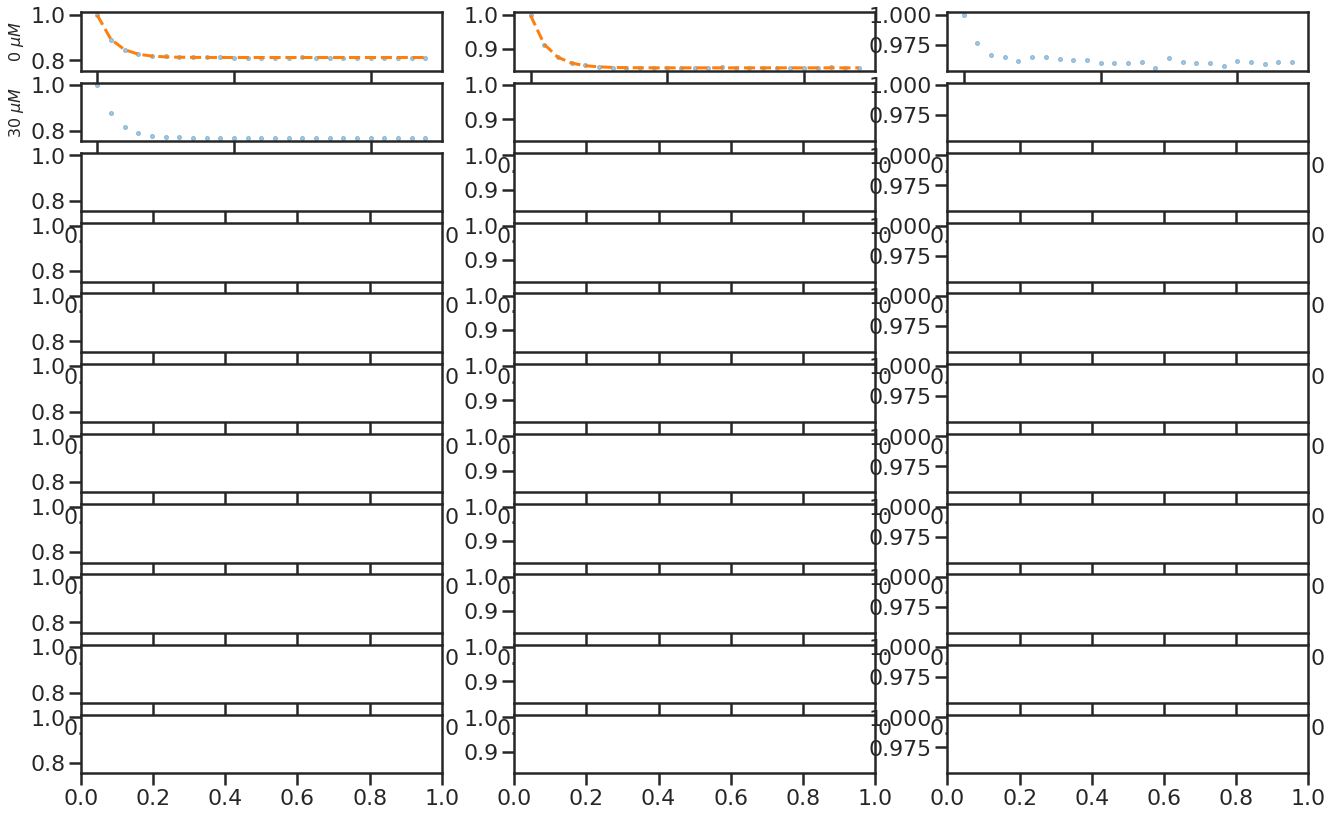

In [61]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
for a, atp in enumerate(ATPconcs): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(1): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr/plotarr.max(), 'o', ms=4, alpha=0.4)

            if col<2:
                ax[a][col].plot(plottimes, singExp(plottimes, singExpFitResults[(a, 0, colname)].x), ls='--')

KeyError: (0, 0, 0)

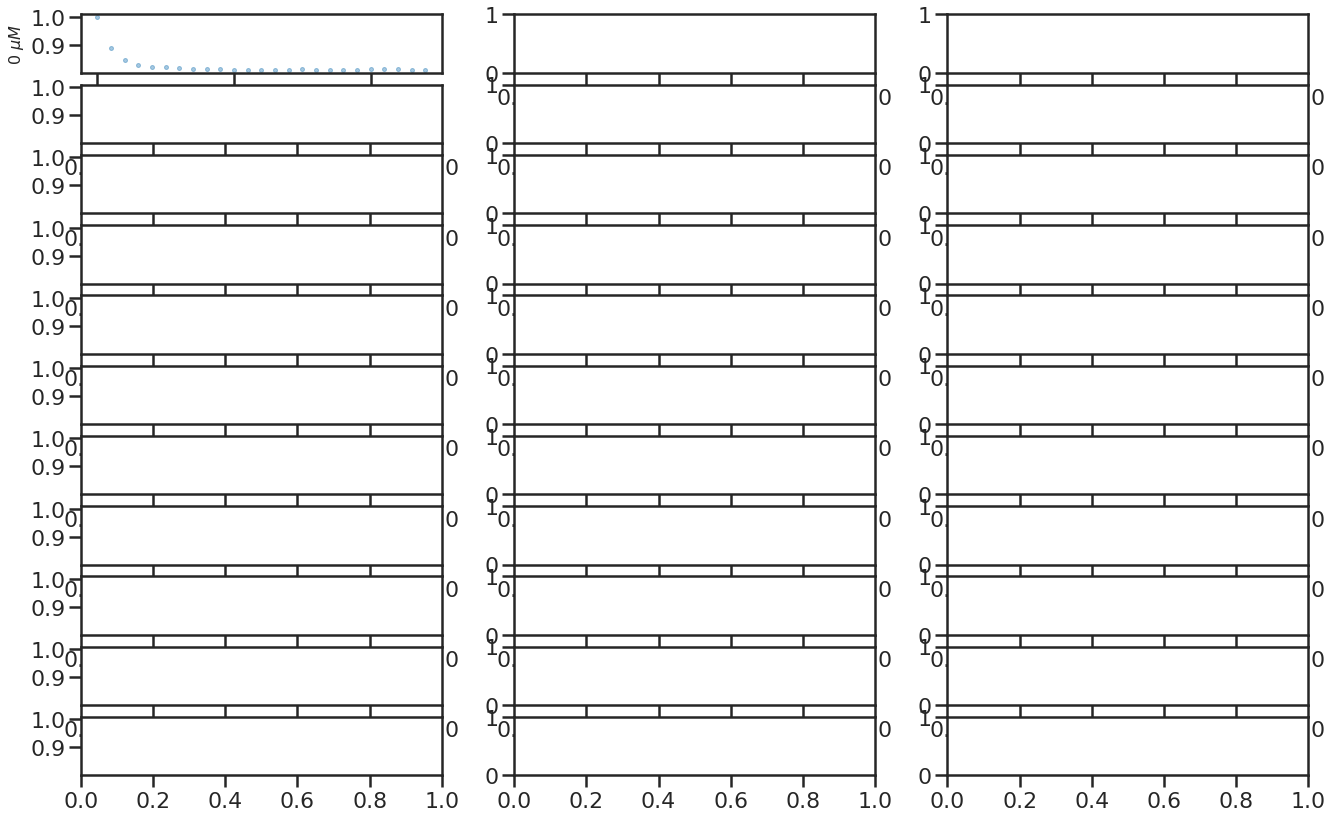

In [55]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time() # to keep track of runtime
#singExpFitResults={} #store results of fit
for a, atp in enumerate(ATPconcs): 
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16) # add axis labels
    for pos in range(1): 
        for col, colname in enumerate(['405', '480', 'ratio']):
            
            #plot intensity (and ratio) values over time
            plotarr = evenedResults[(atp, pos, colname)]
            plottimes = np.arange(len(plotarr))*20 #seconds
            ax[a][col].plot(plottimes, plotarr/plotarr.max(), 'o', ms=4, alpha=0.4)

            #fit the intensity values to a decaying exponential
            if col<2:
                #normalize the intensity values
                plotnormarr = plotarr/plotarr.max()
                #fit = singExpFit(plottimes, plotnormarr, (plotnormarr.max()-plotnormarr.min(), 25, plotnormarr.min()))
                ax[a][col].plot(plottimes, singExp(plottimes, singExpFitResults[(a, 0, col)].x))
                #singExpFitResults[atp, pos, colname] = fit
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

Yippee

In [28]:
singExpFitResults

{(np.int64(0),
  0,
  '405'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 5.740625747608287e-05
         x: [ 1.868e-01  2.365e+01  8.124e-01]
       nit: 6
       jac: [-1.108e-06  5.383e-08  5.852e-06]
  hess_inv: [[ 4.976e-01 -4.648e+01 -1.964e-02]
             [-4.648e+01  4.086e+04 -1.109e+01]
             [-1.964e-02 -1.109e+01  2.535e-02]]
      nfev: 60
      njev: 15,
 (np.int64(0),
  0,
  '480'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 2.702698912799086e-05
         x: [ 1.534e-01  2.500e+01  8.454e-01]
       nit: 2
       jac: [-3.923e-08  9.999e-06  1.644e-08]
  hess_inv: [[ 1.010e+00  2.575e-05 -7.206e-02]
             [ 2.575e-05  1.000e+00 -2.963e-04]
             [-7.206e-02 -2.963e-04  2.514e-02]]
      nfev: 20
      njev: 5,
 (np.int64(30),
  0,
  '405'):   message: Optimization terminated successfully.
   success: True
    status: 0
       fun: 2.3031877852253627e-05

## Fitting to Double Exponential

In [24]:
def doubExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, w2, tau2], where w1(2) is the weight of the first(second) exponential, tau1(2) is the decay constant of the first(second) exponential
    """
    w1 = p0[0]
    tau1 = p0[1]
    w2 = p0[2]
    tau2 = p0[3]

    return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
    

In [28]:
def doubExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess)
    return result

In [ ]:
temparr = evenedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr, (10, 50, 5, 300 ))

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)


73%, time elapsed: 1 seconds 

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/home/aduarte/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-time

91%, time elapsed: 1 seconds 

/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)
/home/aduarte/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/tmp/ipykernel_448096/3042285851.py:11: RuntimeWarning: overflow encountered in exp
  return w1*np.exp(-times/tau1)+w2*np.exp(-times/tau2)
/tmp/ipykernel_448096/1372903659.py:2: RuntimeWarning: overflow encountered in square
  residual=lambda p0: np.sum((vals-doubExp(times, p0))**2)


100%, time elapsed: 2 seconds 

Text(0.5, 0, 'time')

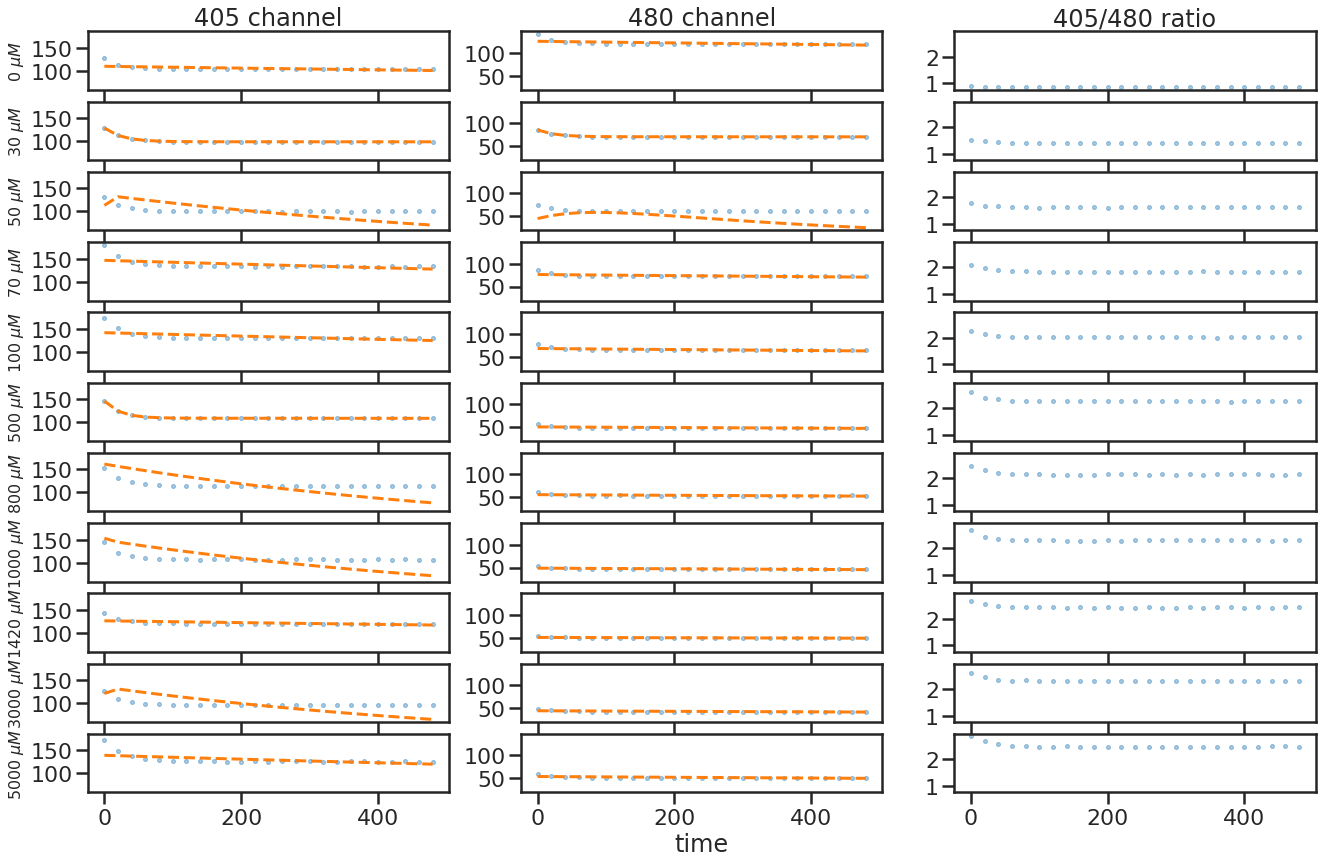

In [59]:
fig, ax = plt.subplots(len(ATPconcs),3, figsize=(22,14), sharey='col')
tstart = time.time()
doubExpFitResults={}
for a, atp in enumerate(ATPconcs):
    ax[a][0].set_ylabel(str(atp)+r' $\mu M$', fontsize=16)
    for pos in range(1):
        for col, colname in enumerate(['405', '480', 'ratio']):

            plottimes = np.arange(len(evenedResults[(atp, pos, colname)]))*20 #seconds
            ax[a][col].plot(plottimes, evenedResults[(atp, pos, colname)], 'o', ms=4, alpha=0.4) 

            if col<2:
                fit = doubExpFit(plottimes, evenedResults[(atp, pos, colname)], (10, 50, 15, 300 ))
                ax[a][col].plot(plottimes, doubExp(plottimes, fit.x))
                doubExpFitResults[atp, pos, colname] = fit
            # else:
            #     ax[a][col].plot(summaryResults[(atp, pos, 0)]/summaryResults[(atp, pos, 1)], 'o', ms=4, alpha=0.4)
            # ax[a][col].set_yscale('log')
    # Manual Status bar
    print("\r"+str(round((a+1)*100/len(ATPconcs)))+"%, time elapsed: " + str(round(time.time()-tstart)) + " seconds" , end=" ")
ax[0][0].set_title('405 channel')
ax[0][1].set_title('480 channel')
ax[0][2].set_title('405/480 ratio')
ax[-1][1].set_xlabel('time')

In [60]:
doubExpFitResults

{(np.int64(0),
  0,
  '405'):   message: Desired error not necessarily achieved due to precision loss.
   success: False
    status: 2
       fun: 442.40177120377376
         x: [ 2.982e+01  2.985e+03  8.023e+01  7.826e+03]
       nit: 42
       jac: [-2.556e-04  8.240e-04  8.011e-04 -3.357e-04]
  hess_inv: [[ 8.481e+01  1.320e+03 -8.281e+01  3.089e+03]
             [ 1.320e+03  3.459e+04 -1.309e+03  8.258e+04]
             [-8.281e+01 -1.309e+03  8.090e+01 -3.066e+03]
             [ 3.089e+03  8.258e+04 -3.066e+03  1.972e+05]]
      nfev: 434
      njev: 84,
 (np.int64(0),
  0,
  '480'):   message: Desired error not necessarily achieved due to precision loss.
   success: False
    status: 2
       fun: 377.1621667061019
         x: [-7.300e+01  6.789e+03  1.982e+02  6.950e+03]
       nit: 63
       jac: [ 2.442e-02 -2.289e-05  2.443e-02  1.907e-05]
  hess_inv: [[ 1.268e+03  1.043e+03 -1.260e+03 -4.509e+03]
             [ 1.043e+03  8.577e+02 -1.036e+03 -3.708e+03]
             [-1.260

In [52]:
temparr = evenedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr, (10, 50, 5, 300 ))

In [53]:
tempfit.x

array([2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05])

In [54]:
temptimes

array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480])

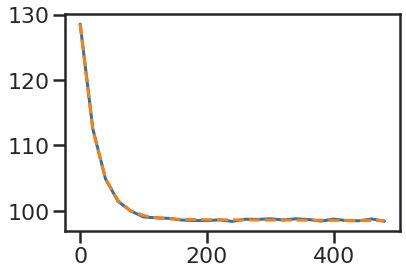

In [58]:
plt.plot(temptimes, evenedResults[(30, 0, '405')])
plt.plot(temptimes, doubExp(temptimes, [2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05]), ls='--')

## try normalizing

In [81]:
def singExp(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [w1, tau1, Iinf], where w1 is the weight of the exponential, tau1 is the decay constant of the exponential and Iinf is the limit of the intensity
    """
    w1 = p0[0]
    tau1 = p0[1]
    Iinf = p0[2]

    return w1*np.exp(-times/tau1)+Iinf
    
def singExpFit(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExp(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess)
    return result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.627362095438604e-05
        x: [ 2.726e-01  2.736e+01  7.277e-01]
      nit: 6
      jac: [ 2.814e-07 -4.743e-09  5.213e-07]
 hess_inv: [[ 4.883e-01 -3.344e+01 -1.850e-02]
            [-3.344e+01  2.080e+04 -8.207e+00]
            [-1.850e-02 -8.207e+00  2.556e-02]]
     nfev: 60
     njev: 15

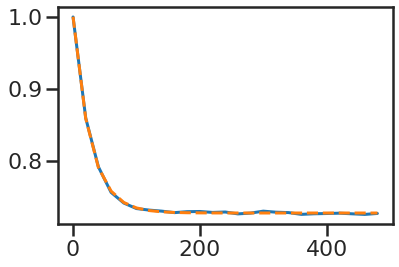

In [83]:
temparr = evenedResults[(5000, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = singExpFit(temptimes, tempnormarr, [0.2, 25, 0.8])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, singExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.7523687655807497e-05
        x: [ 2.321e-01  2.549e+01  7.683e-01  2.168e+05]
      nit: 0
      jac: [ 1.061e-08 -4.547e-13  3.284e-07  3.865e-12]
 hess_inv: [[1 0 0 0]
            [0 1 0 0]
            [0 0 1 0]
            [0 0 0 1]]
     nfev: 5
     njev: 1

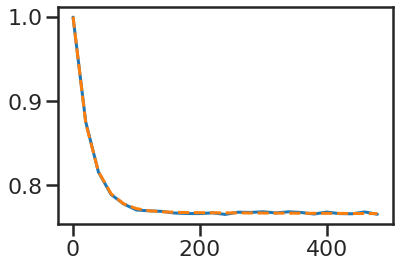

In [72]:
temparr = normedResults[(30, 0, '405')]
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, temparr/temparr.max(), [2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, temparr/temparr.max())
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.165363217309855e-05
        x: [ 2.368e-01  2.550e+01  7.634e-01  2.000e+05]
      nit: 6
      jac: [ 1.583e-07 -7.562e-10 -7.654e-07  1.501e-11]
 hess_inv: [[ 4.811e-01 -3.601e+01 -1.668e-02  8.002e-05]
            [-3.601e+01  2.527e+04 -8.679e+00 -5.615e-02]
            [-1.668e-02 -8.679e+00  2.467e-02  1.928e-05]
            [ 8.002e-05 -5.615e-02  1.928e-05  1.000e+00]]
     nfev: 75
     njev: 15

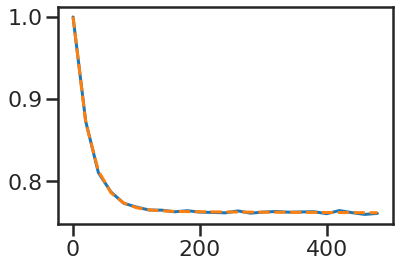

In [75]:
temparr = normedResults[(30, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, tempnormarr, [0.2, 25, 0.8, 200000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00039617608998355076
        x: [ 2.416e-01  2.171e+01  7.590e-01  2.000e+05]
      nit: 7
      jac: [ 4.095e-07  1.601e-09  8.959e-07 -2.619e-10]
 hess_inv: [[ 4.861e-01 -2.731e+01 -2.291e-02  1.079e-04]
            [-2.731e+01  1.869e+04 -6.738e+00 -7.387e-02]
            [-2.291e-02 -6.738e+00  2.479e-02  2.663e-05]
            [ 1.079e-04 -7.387e-02  2.663e-05  1.000e+00]]
     nfev: 80
     njev: 16

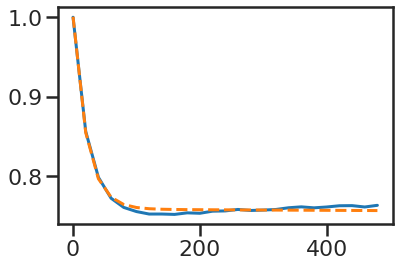

In [80]:
temparr = normedResults[(1000, 2, '405')]
tempnormarr = temparr/temparr.max()
temptimes = np.arange(len(temparr))*20 #seconds
tempfit = doubExpFit(temptimes, tempnormarr, [0.2, 25, 0.8, 200000])#[2.98392383e+01/temparr.max(), 2.54884934e+01, 9.87514545e+01/temparr.max(), 2.16805966e+05])

plt.plot(temptimes, tempnormarr)
plt.plot(temptimes, doubExp(temptimes, tempfit.x), ls='--')
tempfit

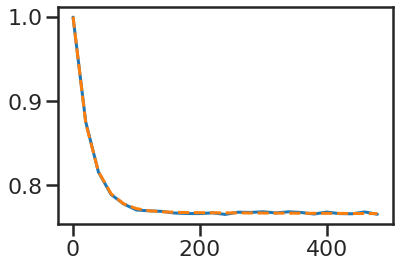

In [71]:
plt.plot(temptimes, normedResults[(30, 0, '405')]/temparr.max())
plt.plot(temptimes, doubExp(temptimes, [2.98392383e+01, 2.54884934e+01, 9.87514545e+01, 2.16805966e+05])/temparr.max(), ls='--')

In [78]:
ATPconcs

array([   0,   30,   50,   70,  100,  500,  800, 1000, 1420, 3000, 5000])

In [ ]:
def gauss2Dfit(vals, coord):
    residual=lambda pvec: np.sum((vals-evalGauss2Dsimple(coord, pvec))**2)
    initialGuess=(np.median(coord[0]), np.median(coord[1]), np.std(coord[0]), np.percentile(vals, 99))
    print(initialGuess)
    bounds=[(min(coord[0]), max(coord[0])), #limits on muy are the image coordinates subsampled on display!
            (min(coord[1]), max(coord[1])), #limits on mux are ^""
            (0, 5000), #limits on sigma are just positivity
            (0, None)] #limits on I0 are just positivity: GOOD VIBES ONLY
    result=scipy.optimize.minimize(residual, initialGuess, method='L-BFGS-B', options={'gtol':1e-7, 'maxiter':1000})

    return result 

######### the above works for normalization ########


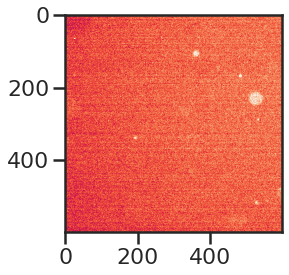

In [191]:
testim = arrs_sub[0][cropAcrossTimes][0]
plt.imshow(testim, vmax=np.percentile(testim, 99))

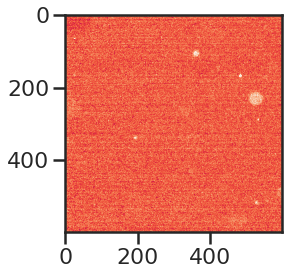

In [190]:
testim = arrs_norm[0][0]
plt.imshow(testim, vmax=np.percentile(testim, 99))

In [149]:
mask = np.zeros_like(results[0][0][0])
print(np.sum(mask>0))
mask[cropAcrossTimes] = 1
print(np.sum(mask>0))
allcrop_coords = np.where(mask==1)

0
9000000


In [152]:
crop_coords

(array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [151]:
allcrop_coords


(array([ 0,  0,  0, ..., 24, 24, 24]),
 array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [168]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)
crop = np.s_[300:900, 700:1300]
cropAcrossTimes = np.s_[:, 300:900, 700:1300]

mask = np.zeros_like(results[0][0][0][0])
mask[crop] = 1
crop_coords = np.where(mask==1)

mask = np.zeros_like(results[0][0][0])
mask[cropAcrossTimes] = 1
allcrop_coords = np.where(mask==1)


normedResults={}
for atp in ATPconcs[0:1]:
    for pos in range(len(results[atp])):
        arrs = results[atp][pos]
        arrs_sub = backSubtract(arrs, dark_avg)
        arrs_norm=norm_unev(arrs_sub, crop_coords, cropAcrossTimes)
        #ratios = arrs_norm[0][allcrop_coords]/arrs_norm[1][allcrop_coords]

/tmp/ipykernel_440503/3365823086.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_mat = scalar/biv_filt


(360000,)


ValueError: operands could not be broadcast together with shapes (25,600,600) (360000,) 

In [174]:
results[0][0][0].shape

(25, 1200, 1920)

In [173]:
results[0][0][0][0].shape

(1200, 1920)

In [166]:
arrs_sub[0][cropAcrossTimes].shape

(25, 600, 600)

In [169]:
len(arrs_sub)

2

In [170]:
arrs_sub[0].shape

(25, 1200, 1920)

In [171]:
arrs_sub[0][crop_coords]

IndexError: index 300 is out of bounds for axis 0 with size 25

In [172]:
crop_coords

(array([300, 300, 300, ..., 899, 899, 899]),
 array([ 700,  701,  702, ..., 1297, 1298, 1299]))

In [161]:
25*600*600

9000000

In [141]:
allcrop_coords[0].shape, crop_coords[0].shape

((9000000,), (360000,))

In [127]:
arrs_sub[1][allcrop_coords]

array([168.        , 144.        , 114.66666667, ..., 106.66666667,
       138.66666667, 117.33333333])